In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the JSON data
with open("lichess_games.json", 'r') as file:
    games = json.load(file)

# Display a sample of the data
print(f"Total games loaded: {len(games)}")
print("Sample Game Data:")
print(games[0])  # Displaying the first game as an example

Total games loaded: 1341
Sample Game Data:
{'id': 'G71MNNH8', 'rated': True, 'variant': 'standard', 'speed': 'blitz', 'perf': 'blitz', 'createdAt': 1734258237967, 'lastMoveAt': 1734258475213, 'status': 'mate', 'source': 'pool', 'players': {'white': {'user': {'name': 'Mr-suschenko', 'id': 'mr-suschenko'}, 'rating': 1151, 'ratingDiff': -5}, 'black': {'user': {'name': 'tazedurum07', 'id': 'tazedurum07'}, 'rating': 1164, 'ratingDiff': 5}}, 'fullId': 'G71MNNH8JOZx', 'winner': 'black', 'moves': 'e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Bc5 Nf3 d6 Bc4 Nf6 Ng5 O-O c3 b6 O-O Bb7 Re1 h6 Bxf7+ Rxf7 Nxf7 Kxf7 Qb3+ d5 exd5 Qxd5 c4 Qd4 Be3 Qe5 Bxc5 Qxe1#', 'pgn': '[Event "Rated blitz game"]\n[Site "https://lichess.org/G71MNNH8"]\n[Date "2024.12.15"]\n[White "Mr-suschenko"]\n[Black "tazedurum07"]\n[Result "0-1"]\n[UTCDate "2024.12.15"]\n[UTCTime "10:23:57"]\n[WhiteElo "1151"]\n[BlackElo "1164"]\n[WhiteRatingDiff "-5"]\n[BlackRatingDiff "+5"]\n[Variant "Standard"]\n[TimeControl "180+2"]\n[ECO "C45"]\n[Termination "

In [40]:
# Process data
data_list = []
for game in games:
    if game.get('speed') == 'blitz':
        timestamp = pd.to_datetime(game['createdAt'], unit='ms')
        white_player = game['players']['white']
        black_player = game['players']['black']
        
        am_i_white = white_player.get('user', {}).get('name', '').lower() == "tazedurum07"
        
        if game.get('status') in ['draw', 'stalemate'] or game.get('winner') is None:
            result = 'Draw'
        else:
            winner = game.get('winner', '')
            result = 'Won' if (am_i_white and winner == 'white') or (not am_i_white and winner == 'black') else 'Lost'
        
        if am_i_white:
            my_rating = white_player.get('rating', None)
            opponent_rating = black_player.get('rating', None)
        else:
            my_rating = black_player.get('rating', None)
            opponent_rating = white_player.get('rating', None)
        
        rating_diff = my_rating - opponent_rating if my_rating and opponent_rating else 0

        # Create rating difference category
        if rating_diff >= 200:
            diff_category = "Large Advantage (200+)"
        elif rating_diff >= 100:
            diff_category = "Medium Advantage (100-199)"
        elif rating_diff >= 0:
            diff_category = "Small Advantage (0-99)"
        elif rating_diff >= -100:
            diff_category = "Small Disadvantage (-1 to -99)"
        elif rating_diff >= -200:
            diff_category = "Medium Disadvantage (-100 to -199)"
        else:
            diff_category = "Large Disadvantage (-200+)"
            
        data_list.append({
            'rating_diff': rating_diff,
            'result': result,
            'diff_category': diff_category
        })

df = pd.DataFrame(data_list)
print("Processed Data Sample:")
print(df.head())

Processed Data Sample:
   rating_diff result                   diff_category
0           13    Won          Small Advantage (0-99)
1          -23   Lost  Small Disadvantage (-1 to -99)
2           -6    Won  Small Disadvantage (-1 to -99)
3          -37    Won  Small Disadvantage (-1 to -99)
4          -11    Won  Small Disadvantage (-1 to -99)


/var/folders/g_/qxd37kgj1cb_c9yxwb54sjhw0000gn/T/ipykernel_96671/230311430.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='result', y='rating_diff',


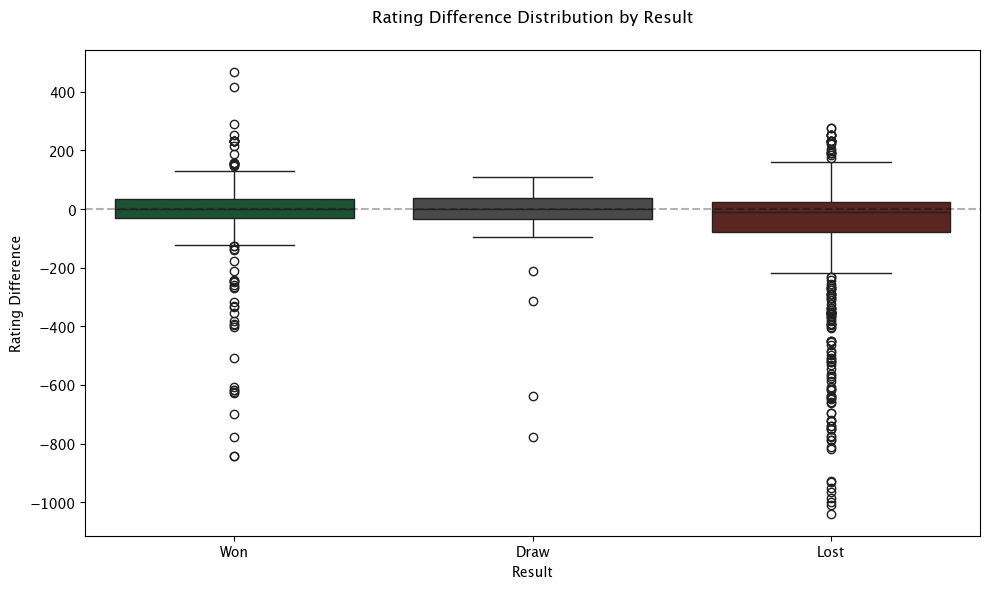

In [41]:
# Define colors
COLORS = {
    'Won': '#145A32',    # Green
    'Draw': '#4a4a4a',   # Gray
    'Lost': '#641E16'    # Red
}

# Create figure
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='result', y='rating_diff',
            order=['Won', 'Draw', 'Lost'],
            palette=[COLORS['Won'], COLORS['Draw'], COLORS['Lost']])
plt.title('Rating Difference Distribution by Result', pad=20)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Result')
plt.ylabel('Rating Difference')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

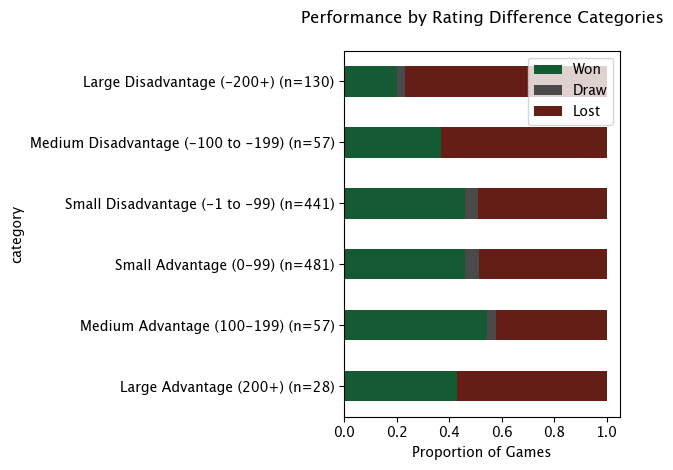

In [42]:
# Create performance data
categories = ['Large Advantage (200+)', 'Medium Advantage (100-199)', 
              'Small Advantage (0-99)', 'Small Disadvantage (-1 to -99)',
              'Medium Disadvantage (-100 to -199)', 'Large Disadvantage (-200+)']

performance_data = []
for cat in categories:
    cat_data = df[df['diff_category'] == cat]
    if len(cat_data) > 0:
        wins = (cat_data['result'] == 'Won').mean()
        draws = (cat_data['result'] == 'Draw').mean()
        losses = (cat_data['result'] == 'Lost').mean()
        games = len(cat_data)
        performance_data.append({
            'category': cat,
            'Won': wins,
            'Draw': draws,
            'Lost': losses,
            'games': games
        })

performance_df = pd.DataFrame(performance_data)
performance_df.set_index('category', inplace=True)

# Create figure
plt.figure(figsize=(12, 8))

# Plot stacked bar chart
performance_df[['Won', 'Draw', 'Lost']].plot(kind='barh', stacked=True,
                                            color=[COLORS['Won'], COLORS['Draw'], COLORS['Lost']])
plt.title('Performance by Rating Difference Categories', pad=20)
plt.xlabel('Proportion of Games')

# Add game counts to labels
labels = [f"{idx} (n={int(performance_df.loc[idx, 'games'])})" for idx in performance_df.index]
plt.yticks(range(len(labels)), labels)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

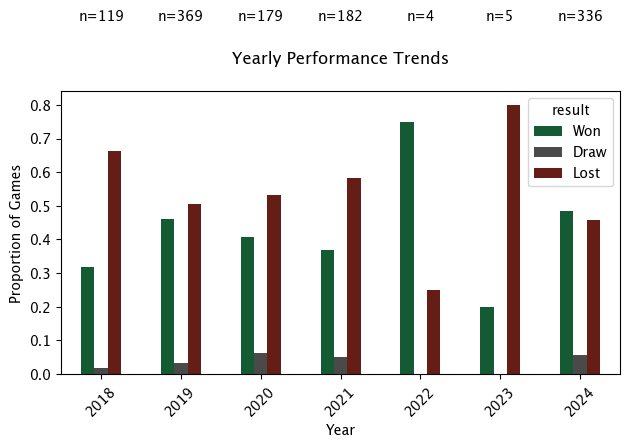

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Load the JSON data
with open("lichess_games.json", 'r') as file:
    games = json.load(file)

# Process data
data_list = []
for game in games:
    if game.get('speed') == 'blitz':
        timestamp = pd.to_datetime(game['createdAt'], unit='ms')
        white_player = game['players']['white']
        black_player = game['players']['black']
        
        am_i_white = white_player.get('user', {}).get('name', '').lower() == "tazedurum07"
        
        if game.get('status') in ['draw', 'stalemate'] or game.get('winner') is None:
            result = 'Draw'
        else:
            winner = game.get('winner', '')
            result = 'Won' if (am_i_white and winner == 'white') or (not am_i_white and winner == 'black') else 'Lost'
            
        data_list.append({
            'date': timestamp,
            'result': result,
            'year': timestamp.year
        })

df = pd.DataFrame(data_list)

# Define colors
COLORS = {
    'Won': '#145A32',    # Green
    'Draw': '#4a4a4a',   # Gray
    'Lost': '#641E16'    # Red
}

# Create figure
plt.figure(figsize=(12, 6))

# Performance trends over years
yearly_performance = df.groupby('year')['result'].value_counts(normalize=True).unstack()
yearly_performance[['Won', 'Draw', 'Lost']].plot(kind='bar',
                                                color=[COLORS['Won'], COLORS['Draw'], COLORS['Lost']])
plt.title('Yearly Performance Trends', pad=20)
plt.xlabel('Year')
plt.ylabel('Proportion of Games')
plt.xticks(rotation=45)

# Add game counts
game_counts = df.groupby('year').size()
for i, count in enumerate(game_counts):
    plt.text(i, 1.05, f'n={count}', ha='center')

plt.tight_layout()
plt.show()

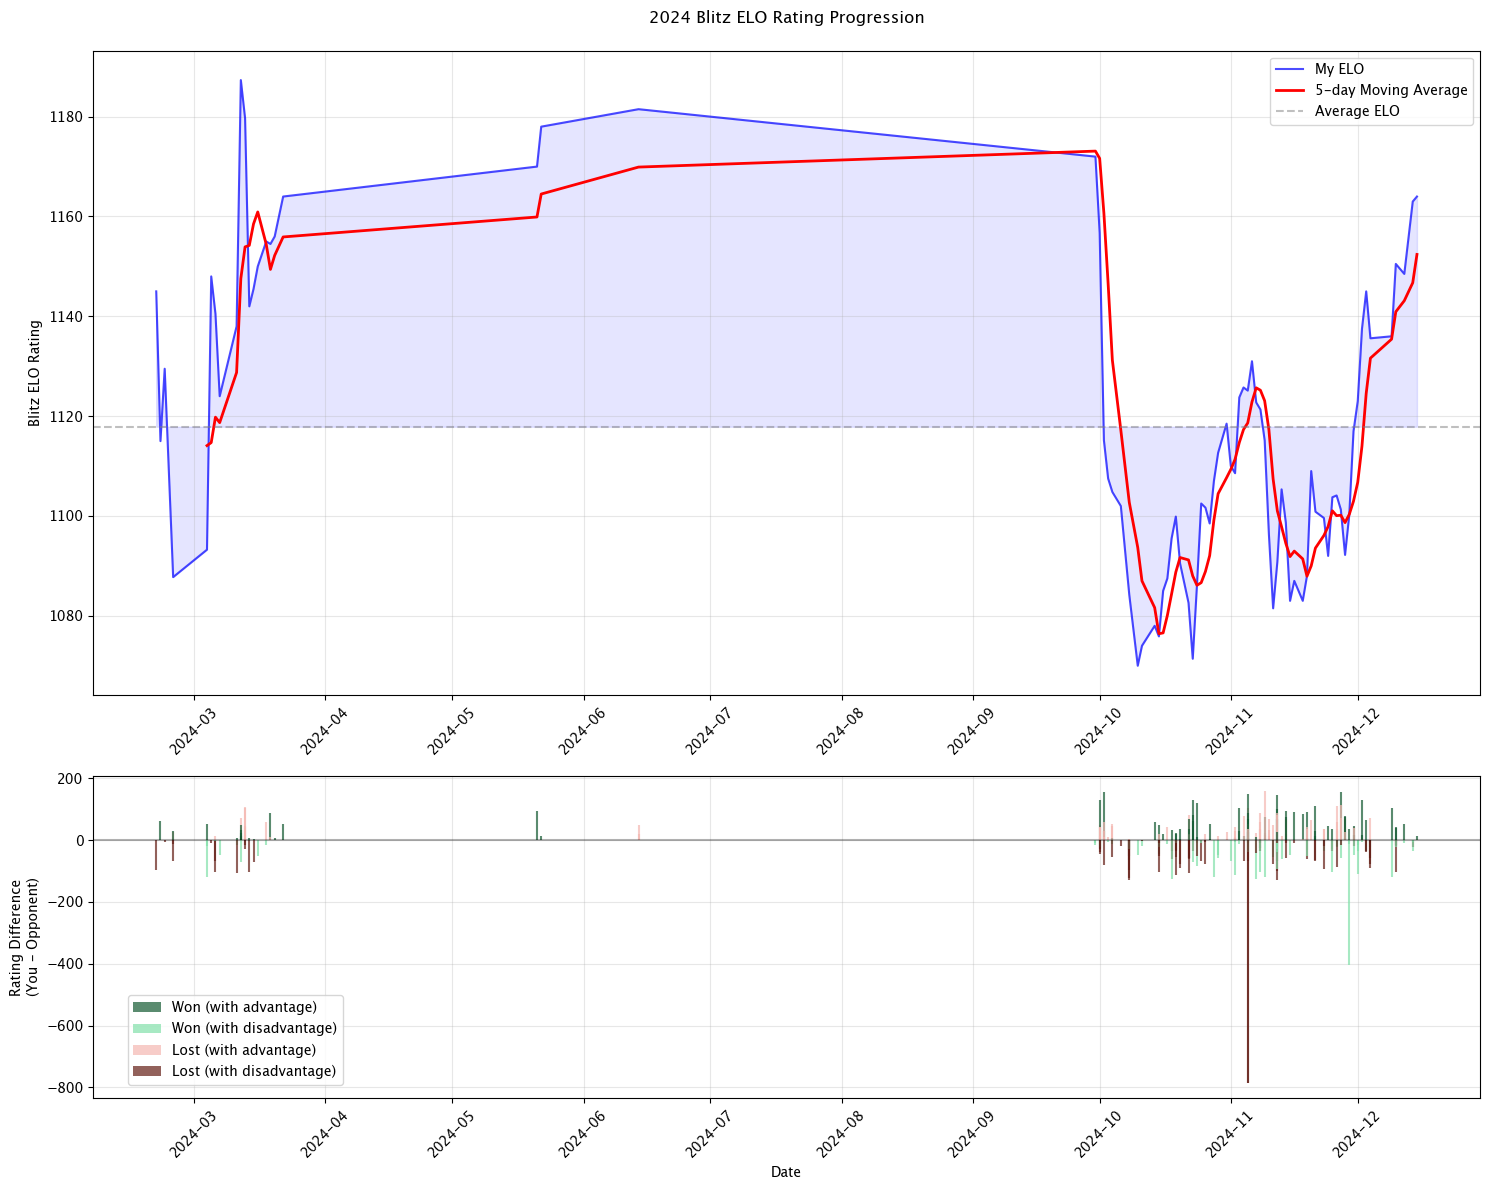


2024 Blitz Game Statistics:
Total games analyzed: 336
Overall win rate: 48.2%

Performance Breakdown:
Won with advantage: 84 (25.0%)
Won with disadvantage: 78 (23.2%)
Lost with advantage: 89 (26.5%)
Lost with disadvantage: 84 (25.0%)

Rating Statistics:
Starting ELO: 1164.0
Current ELO: 1145.0
Peak ELO: 1215.0
Lowest ELO: 1062.0
Average ELO: 1114.0
Rating change: -19.0

Performance by Rating Difference:
Win rate when rated lower: 48.1% (78/162)
Win rate when rated higher: 48.6% (84/173)


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from matplotlib.dates import YearLocator, MonthLocator
from datetime import datetime
import matplotlib.patches as mpatches

# Load the JSON data
with open("lichess_games.json", 'r') as file:
    games = json.load(file)

# Process data - only 2024 blitz games
data_list = []
for game in games:
    timestamp = pd.to_datetime(game['createdAt'], unit='ms')
    
    # Check if it's a 2024 blitz game
    if game.get('speed') == 'blitz' and timestamp.year == 2024:
        white_player = game['players']['white']
        black_player = game['players']['black']
        
        am_i_white = white_player.get('user', {}).get('name', '').lower() == "tazedurum07"
        winner = game.get('winner', 'draw')
        i_won = (am_i_white and winner == 'white') or (not am_i_white and winner == 'black')
        
        if am_i_white:
            my_elo = white_player.get('rating', None)
            opponent_elo = black_player.get('rating', None)
        else:
            my_elo = black_player.get('rating', None)
            opponent_elo = white_player.get('rating', None)
        
        data_list.append({
            'date': timestamp.date(),
            'My ELO': my_elo,
            'Opponent ELO': opponent_elo,
            'Won': i_won
        })

if not data_list:
    print("No blitz games found in 2024.")
    exit()

df = pd.DataFrame(data_list)
df['Rating_Diff'] = df['My ELO'] - df['Opponent ELO']
daily_df = df.groupby('date').agg({
    'My ELO': 'mean',
    'Opponent ELO': 'mean',
    'Rating_Diff': 'mean'
}).reset_index()
daily_df = daily_df.sort_values('date')

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])

# Main ELO progression plot (top)
ax1.plot(daily_df['date'], daily_df['My ELO'], 
         label='My ELO', color='blue', alpha=0.7)
ax1.fill_between(daily_df['date'], daily_df['My ELO'], 
                 daily_df['My ELO'].mean(), alpha=0.1, color='blue')

window = 5  # Smaller window for 2024 only
my_elo_ma = daily_df['My ELO'].rolling(window=window).mean()
ax1.plot(daily_df['date'], my_elo_ma, 
         'r-', label=f'{window}-day Moving Average', linewidth=2)
ax1.axhline(y=daily_df['My ELO'].mean(), color='gray', 
            linestyle='--', alpha=0.5, label='Average ELO')

ax1.set_title('2024 Blitz ELO Rating Progression', pad=20)
ax1.set_ylabel('Blitz ELO Rating')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Define colors - new scheme with swapped lost colors
colors = {
    'won_advantage': '#145A32',     # Darker green (won with advantage)
    'won_disadvantage': '#82E0AA',  # Lighter green (won with disadvantage)
    'lost_advantage': '#F5B7B1',    # Light red (lost with advantage)
    'lost_disadvantage': '#641E16'  # Dark red (lost with disadvantage)
}

# Bottom plot with four scenarios
for idx, row in df.iterrows():
    date = row['date']
    rating_diff = row['Rating_Diff']
    won = row['Won']
    
    if won:  # Won games - green shades
        if rating_diff >= 0:
            color = colors['won_advantage']
        else:
            color = colors['won_disadvantage']
    else:  # Lost games - red shades
        if rating_diff >= 0:
            color = colors['lost_advantage']
        else:
            color = colors['lost_disadvantage']
    
    ax2.vlines(date, 0, rating_diff, colors=color, alpha=0.7)

# Create custom legend patches
legend_elements = [
    mpatches.Patch(facecolor=colors['won_advantage'], label='Won (with advantage)', alpha=0.7),
    mpatches.Patch(facecolor=colors['won_disadvantage'], label='Won (with disadvantage)', alpha=0.7),
    mpatches.Patch(facecolor=colors['lost_advantage'], label='Lost (with advantage)', alpha=0.7),
    mpatches.Patch(facecolor=colors['lost_disadvantage'], label='Lost (with disadvantage)', alpha=0.7)
]

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.set_xlabel('Date')
ax2.set_ylabel('Rating Difference\n(You - Opponent)')
ax2.grid(True, alpha=0.3)
ax2.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.02, 0.02))

# Improve x-axis formatting
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(MonthLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print statistics
won_advantage = len(df[(df['Rating_Diff'] >= 0) & (df['Won'])])
lost_advantage = len(df[(df['Rating_Diff'] >= 0) & (~df['Won'])])
won_disadvantage = len(df[(df['Rating_Diff'] < 0) & (df['Won'])])
lost_disadvantage = len(df[(df['Rating_Diff'] < 0) & (~df['Won'])])
total_games = len(df)

# Calculate percentages
total_wins = won_advantage + won_disadvantage
total_losses = lost_advantage + lost_disadvantage
win_rate = (total_wins / total_games) * 100

print("\n2024 Blitz Game Statistics:")
print(f"Total games analyzed: {total_games}")
print(f"Overall win rate: {win_rate:.1f}%")

print("\nPerformance Breakdown:")
print(f"Won with advantage: {won_advantage} ({won_advantage/total_games*100:.1f}%)")
print(f"Won with disadvantage: {won_disadvantage} ({won_disadvantage/total_games*100:.1f}%)")
print(f"Lost with advantage: {lost_advantage} ({lost_advantage/total_games*100:.1f}%)")
print(f"Lost with disadvantage: {lost_disadvantage} ({lost_disadvantage/total_games*100:.1f}%)")

print("\nRating Statistics:")
print(f"Starting ELO: {df['My ELO'].iloc[0]:.1f}")
print(f"Current ELO: {df['My ELO'].iloc[-1]:.1f}")
print(f"Peak ELO: {df['My ELO'].max():.1f}")
print(f"Lowest ELO: {df['My ELO'].min():.1f}")
print(f"Average ELO: {df['My ELO'].mean():.1f}")
print(f"Rating change: {df['My ELO'].iloc[-1] - df['My ELO'].iloc[0]:.1f}")

# Calculate performance in rated-up and rated-down games
rated_up_wins = len(df[(df['Rating_Diff'] < 0) & (df['Won'])])
rated_up_total = len(df[df['Rating_Diff'] < 0])
rated_down_wins = len(df[(df['Rating_Diff'] >= 0) & (df['Won'])])
rated_down_total = len(df[df['Rating_Diff'] >= 0])

print("\nPerformance by Rating Difference:")
if rated_up_total > 0:
    print(f"Win rate when rated lower: {rated_up_wins/rated_up_total*100:.1f}% ({rated_up_wins}/{rated_up_total})")
if rated_down_total > 0:
    print(f"Win rate when rated higher: {rated_down_wins/rated_down_total*100:.1f}% ({rated_down_wins}/{rated_down_total})")

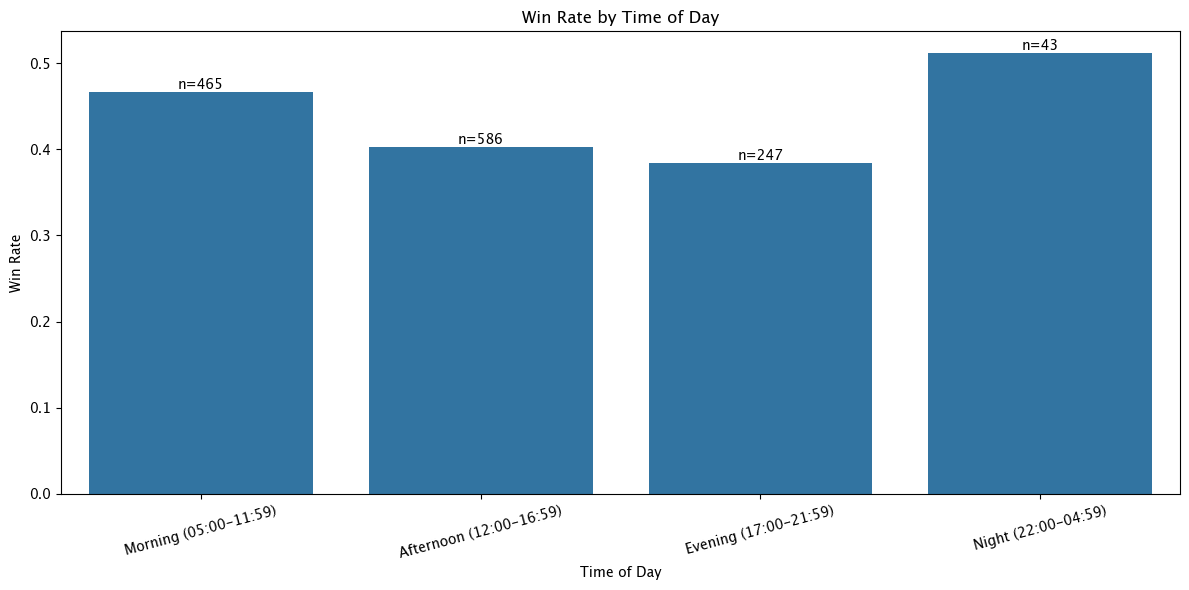

Time of Day Statistics:

Morning (05:00-11:59):
Games played: 465
Win rate: 46.7%

Afternoon (12:00-16:59):
Games played: 586
Win rate: 40.3%

Evening (17:00-21:59):
Games played: 247
Win rate: 38.5%

Night (22:00-04:59):
Games played: 43
Win rate: 51.2%


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

# Load the JSON data
with open("lichess_games.json", 'r') as file:
    games = json.load(file)

# Process data
data_list = []
time_intervals = {
    'Morning': '(05:00-11:59)',
    'Afternoon': '(12:00-16:59)',
    'Evening': '(17:00-21:59)',
    'Night': '(22:00-04:59)'
}

for game in games:
    timestamp = pd.to_datetime(game['createdAt'], unit='ms')
    
    white_player = game['players']['white']
    black_player = game['players']['black']
    
    am_i_white = white_player.get('user', {}).get('name', '').lower() == "tazedurum07"
    winner = game.get('winner', 'draw')
    i_won = (am_i_white and winner == 'white') or (not am_i_white and winner == 'black')
    
    # Categorize time of day
    hour = timestamp.hour
    if 5 <= hour < 12:
        time_of_day = 'Morning'
    elif 12 <= hour < 17:
        time_of_day = 'Afternoon'
    elif 17 <= hour < 22:
        time_of_day = 'Evening'
    else:
        time_of_day = 'Night'
    
    data_list.append({
        'time_of_day': time_of_day,
        'Won': i_won
    })

df = pd.DataFrame(data_list)

# Create time of day performance statistics
time_performance = df.groupby('time_of_day')['Won'].agg(['count', 'mean']).reset_index()

# Create ordered list of time periods with intervals
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
time_labels = [f"{t} {time_intervals[t]}" for t in time_order]

# Create figure
plt.figure(figsize=(12, 6))

# Create bar plot with specified order
sns.barplot(data=time_performance, x='time_of_day', y='mean', 
            order=time_order)

plt.title('Win Rate by Time of Day')
plt.ylabel('Win Rate')
plt.xlabel('Time of Day')

# Add game count annotations
for i, time in enumerate(time_order):
    count = time_performance[time_performance['time_of_day'] == time]['count'].iloc[0]
    mean = time_performance[time_performance['time_of_day'] == time]['mean'].iloc[0]
    plt.text(i, mean, f'n={int(count)}', ha='center', va='bottom')

# Update x-axis labels with intervals
plt.xticks(range(len(time_order)), time_labels, rotation=15)

plt.tight_layout()
plt.show()

# Print statistics
print("Time of Day Statistics:")
for time in time_order:
    period_games = df[df['time_of_day'] == time]
    games_count = len(period_games)
    win_rate = period_games['Won'].mean() * 100
    
    print(f"\n{time} {time_intervals[time]}:")
    print(f"Games played: {games_count}")
    print(f"Win rate: {win_rate:.1f}%")

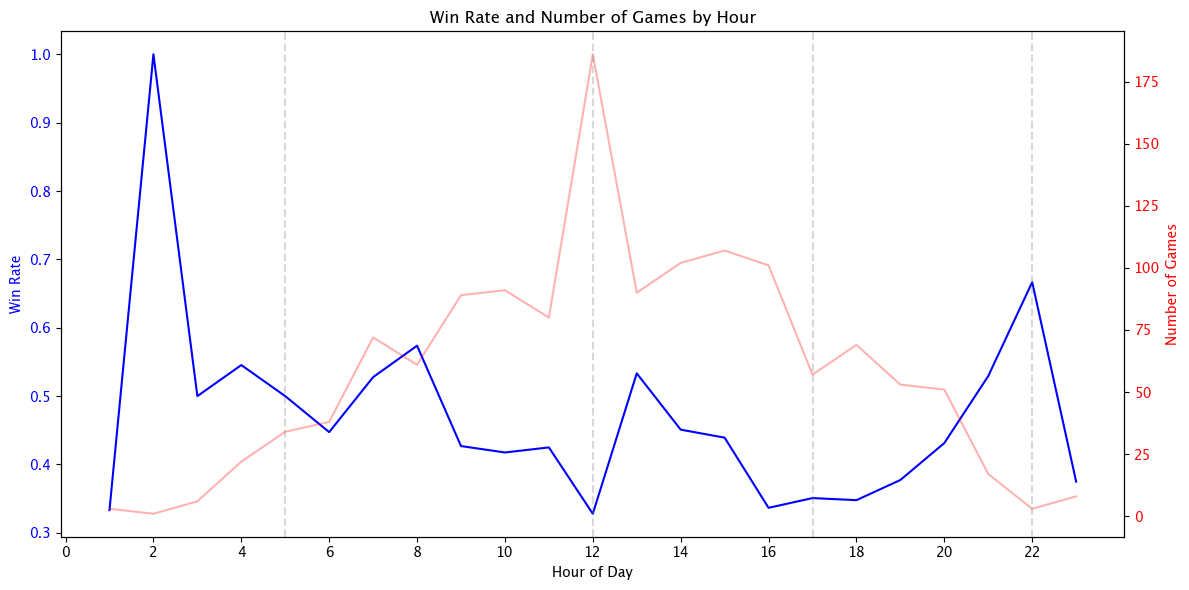


Hourly Statistics:

Best Hours to Play:
02:00 - Win Rate: 100.0% (n=1)
22:00 - Win Rate: 66.7% (n=3)
08:00 - Win Rate: 57.4% (n=61)

Worst Hours to Play:
12:00 - Win Rate: 32.8% (n=186)
01:00 - Win Rate: 33.3% (n=3)
16:00 - Win Rate: 33.7% (n=101)


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

# Load the JSON data
with open("lichess_games.json", 'r') as file:
    games = json.load(file)

# Process data
data_list = []
for game in games:
    timestamp = pd.to_datetime(game['createdAt'], unit='ms')
    
    white_player = game['players']['white']
    black_player = game['players']['black']
    
    am_i_white = white_player.get('user', {}).get('name', '').lower() == "tazedurum07"
    winner = game.get('winner', 'draw')
    i_won = (am_i_white and winner == 'white') or (not am_i_white and winner == 'black')
    
    data_list.append({
        'hour': timestamp.hour,
        'Won': i_won
    })

df = pd.DataFrame(data_list)

# Calculate hourly statistics
hourly_stats = df.groupby('hour')['Won'].agg(['count', 'mean']).reset_index()

# Create figure
plt.figure(figsize=(12, 6))

# Create win rate line
ax1 = plt.gca()
line1 = sns.lineplot(data=hourly_stats, x='hour', y='mean', ax=ax1, color='blue')
ax1.set_title('Win Rate and Number of Games by Hour')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Win Rate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(0, 24, 2))

# Add game count line on secondary axis
ax2 = ax1.twinx()
line2 = sns.lineplot(data=hourly_stats, x='hour', y='count', ax=ax2, color='red', alpha=0.3)
ax2.set_ylabel('Number of Games', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add vertical lines for time period boundaries
period_boundaries = [5, 12, 17, 22]
period_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
for boundary in period_boundaries:
    plt.axvline(x=boundary, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nHourly Statistics:")
best_hours = hourly_stats.nlargest(3, 'mean')
worst_hours = hourly_stats.nsmallest(3, 'mean')

print("\nBest Hours to Play:")
for _, row in best_hours.iterrows():
    print(f"{int(row['hour']):02d}:00 - Win Rate: {row['mean']*100:.1f}% (n={int(row['count'])})")

print("\nWorst Hours to Play:")
for _, row in worst_hours.iterrows():
    print(f"{int(row['hour']):02d}:00 - Win Rate: {row['mean']*100:.1f}% (n={int(row['count'])})")

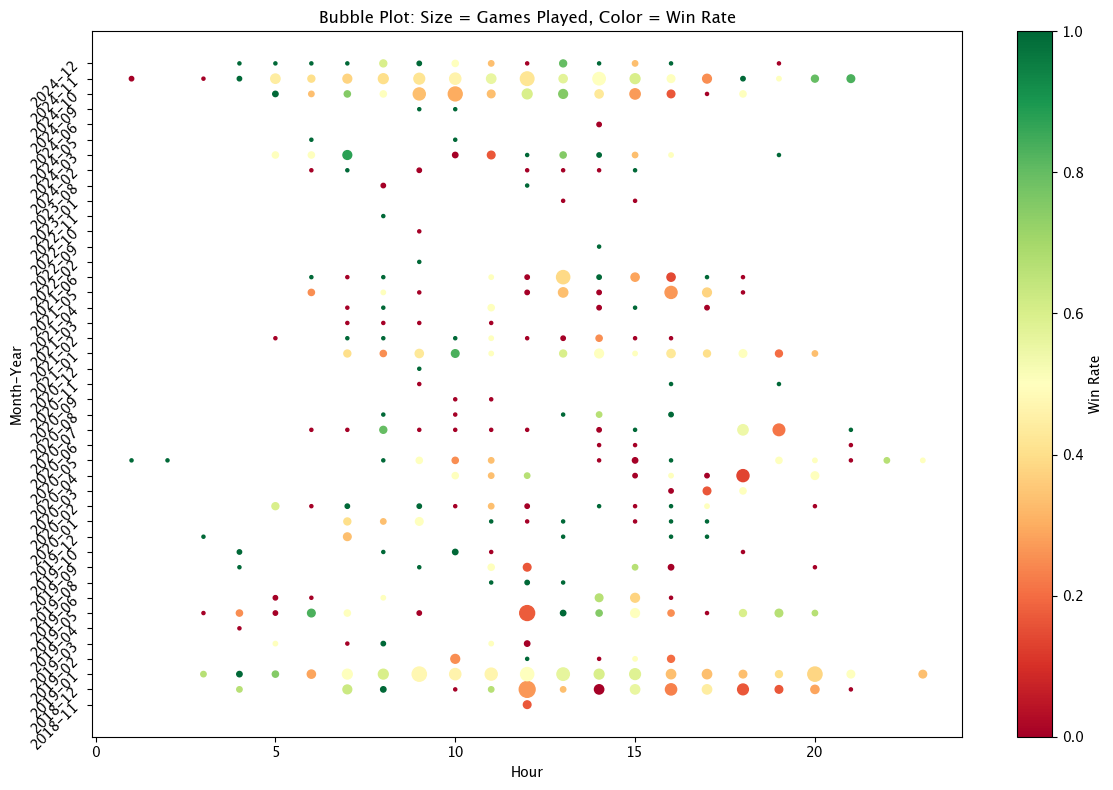

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from datetime import datetime

# Load the JSON data
with open("lichess_games.json", 'r') as file:
    games = json.load(file)

# Process data
data_list = []
for game in games:
    if game.get('speed') == 'blitz':
        timestamp = pd.to_datetime(game['createdAt'], unit='ms')
        
        white_player = game['players']['white']
        black_player = game['players']['black']
        
        am_i_white = white_player.get('user', {}).get('name', '').lower() == "tazedurum07"
        winner = game.get('winner', 'draw')
        i_won = (am_i_white and winner == 'white') or (not am_i_white and winner == 'black')
        
        data_list.append({
            'hour': timestamp.hour,
            'date': timestamp,
            'month_year': timestamp.strftime('%Y-%m'),
            'won': i_won
        })

df = pd.DataFrame(data_list)

# Create the pivot table
pivot_data = df.pivot_table(
    index='hour',
    columns='month_year',
    values='won',
    aggfunc='mean'
)

# Sort the pivot_data columns (month-year) chronologically
sorted_months = sorted(pivot_data.columns, key=lambda x: pd.to_datetime(x, format='%Y-%m'))

# Bubble plot
hours = []
months = []
win_rates = []
game_counts = []

for hour in pivot_data.index:
    for month in sorted_months:  
        # Check if the value is not NaN
        if not pd.isna(pivot_data.loc[hour, month]):
            hours.append(hour)
            months.append(sorted_months.index(month))  # Convert month to its index in the sorted list
            win_rates.append(pivot_data.loc[hour, month])
            game_counts.append(len(df[(df['hour'] == hour) & (df['month_year'] == month)]))

# Create the bubble plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(hours, months, c=win_rates, 
                       s=[count * 5 for count in game_counts], 
                       cmap='RdYlGn', vmin=0, vmax=1)

plt.title('Bubble Plot: Size = Games Played, Color = Win Rate')
plt.xlabel('Hour')
plt.ylabel('Month-Year')

# Ensure y-axis labels correspond to the sorted months
plt.yticks(ticks=range(len(sorted_months)), labels=sorted_months, rotation=45)
plt.colorbar(scatter, label='Win Rate')
plt.tight_layout()
plt.show()



Total games processed: 1191
Average Time Per Move for Wins: 9.99 seconds
Average Time Per Move for Losses: 7.28 seconds
Average Time Per Move for Draws: 4.29 seconds


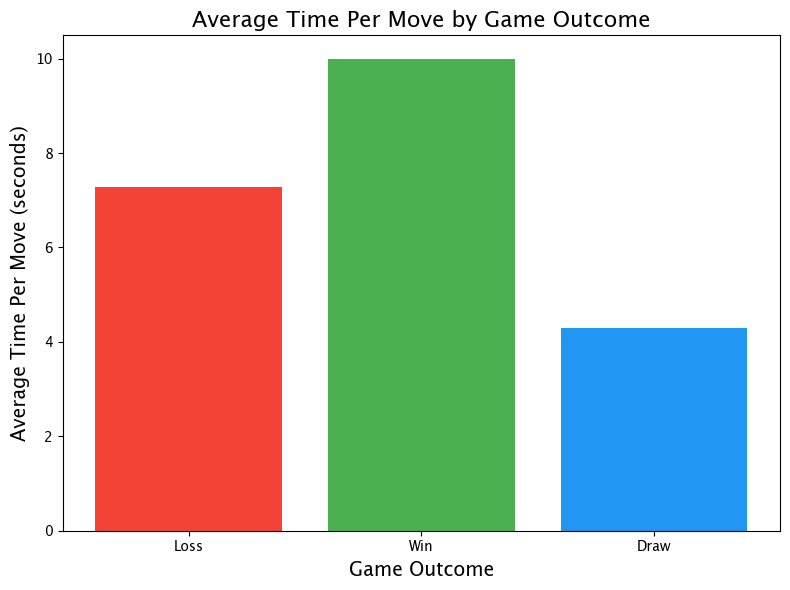

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Load the JSON data
with open("lichess_games.json", 'r') as file:
    games = json.load(file)

# Process data
data_list = []
for game in games:
    if game.get('speed') == 'blitz' and game.get('clock') and game.get('moves'):  # Ensure valid data
        white_player = game['players']['white']
        black_player = game['players']['black']
        
        am_i_white = white_player.get('user', {}).get('name', '').lower() == "tazedurum07"
        winner = game.get('winner', 'draw')
        i_won = (am_i_white and winner == 'white') or (not am_i_white and winner == 'black')
        i_drew = winner == 'draw'
        
        total_time = game['clock']['totalTime'] 
        moves = len(game['moves'].split()) if game.get('moves') else 0
        
        if moves > 0:  # Avoid division by zero
            avg_time_per_move = total_time / moves
            data_list.append({
                'moves': moves,
                'total_time': total_time,
                'avg_time_per_move': avg_time_per_move,
                'won': i_won,
                'draw': i_drew  # Track draws separately
            })

print(f"Total games processed: {len(data_list)}")

if not data_list:
    print("No games found matching the criteria!")
    exit()

df = pd.DataFrame(data_list)

# Calculate average time per move grouped by game outcome
win_avg_time = df[df['won'] == True]['avg_time_per_move'].mean()
loss_avg_time = df[df['won'] == False]['avg_time_per_move'].mean()
draw_avg_time = df[df['draw'] == True]['avg_time_per_move'].mean() if True in df['draw'].unique() else None

# Display results
print(f"Average Time Per Move for Wins: {win_avg_time:.2f} seconds")
print(f"Average Time Per Move for Losses: {loss_avg_time:.2f} seconds")
if draw_avg_time is not None:
    print(f"Average Time Per Move for Draws: {draw_avg_time:.2f} seconds")

# Visualization: Bar Chart for Wins, Losses, and Draws
outcomes = ['Loss', 'Win'] + (['Draw'] if draw_avg_time is not None else [])
avg_times = [loss_avg_time, win_avg_time] + ([draw_avg_time] if draw_avg_time is not None else [])

plt.figure(figsize=(8, 6))
plt.bar(outcomes, avg_times, color=['#F44336', '#4CAF50', '#2196F3'][:len(avg_times)])  # Red, green, blue
plt.title('Average Time Per Move by Game Outcome', fontsize=16)
plt.xlabel('Game Outcome', fontsize=14)
plt.ylabel('Average Time Per Move (seconds)', fontsize=14)
plt.tight_layout()
plt.show()


Total games processed: 1191
Lecture-Time Games: 201 games, Win Rate: 44.28%
Other-Time Games: 990 games, Win Rate: 42.83%


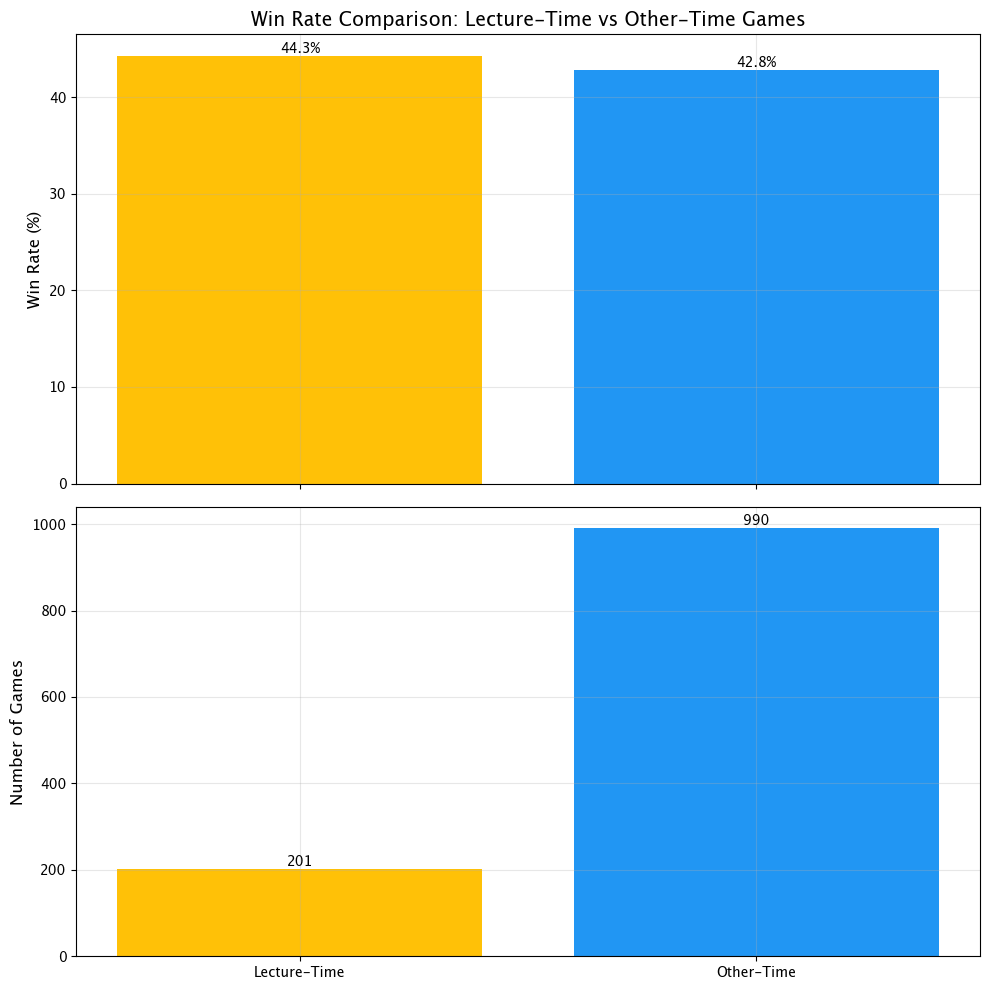


Detailed Statistics:

Lecture-Time Games:
Total games: 201
Wins: 89 (44.3%)
Losses: 112 (55.7%)
Average game length: 60.5 moves

Other-Time Games:
Total games: 990
Wins: 424 (42.8%)
Losses: 566 (57.2%)
Average game length: 60.5 moves


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

# Lecture schedules for multiple periods
lecture_schedules = [
    {
        "start_date": datetime(2018, 11, 27),
        "end_date": datetime(2020, 3, 15),
        "schedule": {
            "Monday": [(8.20, 9.40), (9.55, 11.15), (11.25, 12.05), (12.50, 13.30), (13.40, 15.00)],
            "Tuesday": [(8.20, 9.40), (9.55, 11.15), (11.25, 12.05), (12.50, 13.30), (13.40, 15.00)],
            "Wednesday": [(8.20, 9.40), (9.55, 11.15), (11.25, 12.05), (12.50, 13.30), (13.40, 15.00)],
            "Thursday": [(8.20, 9.40), (9.55, 11.15), (11.25, 12.05), (12.50, 13.30), (13.40, 15.00)],
            "Friday": [(8.20, 9.40), (9.55, 11.15), (11.25, 12.05), (12.50, 13.30), (13.40, 15.00)],
        },
    },
    {
        "start_date": datetime(2021, 9, 6),
        "end_date": datetime(2022, 6, 17),
        "schedule": {
            "Monday": [(8.10, 8.50), (9.00, 9.40), (9.50, 10.30), (10.40, 11.20), (11.50, 12.30), (13.10, 13.50),
                       (14.00, 14.40), (14.50, 15.30)],
            "Tuesday": [(8.10, 8.50), (9.00, 9.40), (9.50, 10.30), (10.40, 11.20), (11.50, 12.30), (13.10, 13.50),
                        (14.00, 14.40), (14.50, 15.30)],
            "Wednesday": [(8.10, 8.50), (9.00, 9.40), (9.50, 10.30), (10.40, 11.20), (11.50, 12.30), (13.10, 13.50),
                          (14.00, 14.40), (14.50, 15.30)],
            "Thursday": [(8.10, 8.50), (9.00, 9.40), (9.50, 10.30), (10.40, 11.20), (11.50, 12.30), (13.10, 13.50),
                         (14.00, 14.40), (14.50, 15.30)],
            "Friday": [(8.10, 8.50), (9.00, 9.40), (9.50, 10.30), (10.40, 11.20), (11.50, 12.30), (13.10, 13.50),
                       (14.00, 14.40), (14.50, 15.30)],
        },
    },
    {
        "start_date": datetime(2022, 10, 3),
        "end_date": datetime(2023, 1, 18),
        "schedule": {
            "Monday": [(9.00, 9.50), (10.00, 10.50), (11.00, 11.50), (12.00, 12.50)],
            "Tuesday": [(9.00, 9.50), (10.00, 10.50), (11.00, 11.50), (12.00, 12.50)],
            "Wednesday": [(9.00, 9.50), (10.00, 10.50), (11.00, 11.50), (12.00, 12.50)],
            "Thursday": [(9.00, 9.50), (10.00, 10.50), (11.00, 11.50), (12.00, 12.50)],
            "Friday": [(9.00, 9.50), (10.00, 10.50), (11.00, 11.50), (12.00, 12.50)],
        },
    },
    {
        "start_date": datetime(2023, 2, 27),
        "end_date": datetime(2023, 5, 31),
        "schedule": {
            "Monday": [(14.40, 15.30), (15.40, 16.30), (16.40, 17.30)],
            "Tuesday": [(09.40, 10.30), (10.40, 11.30), (14.40, 15.30), (15.40, 16.30), (16.40, 17.30), (17.40, 18.30)],
            "Wednesday": [(10.40, 11.30), (11.40, 12.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30)],
            "Thursday": [(10.40, 11.30), (11.40, 12.30), (14.40, 15.30), (15.40, 16.30)],
            "Friday": [(08.40, 09.30), (09.40, 10.30), (10.40, 11.30), (11.40, 12.30), (13.40, 14.30), (14.40, 15.30)],
        },
    },
    {
        "start_date": datetime(2023, 10, 2),
        "end_date": datetime(2023, 10, 9),
        "schedule": {
            "Monday": [(09.40, 10.30), (10.40, 11.30), (11.40, 12.30), (14.40, 15.30), (15.40, 16.30)],
            "Tuesday": [(09.40, 10.30), (10.40, 11.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30), (15.40, 16.30)],
            "Wednesday": [(08.40, 09.30), (09.40, 10.30), (14.40, 15.30), (15.40, 16.30)],
            "Thursday": [(11.40, 12.30)],
            "Friday": [(08.40, 09.30), (09.40, 10.30), (12.40, 13.30), (13.40, 14.30)],
        },
    },
    {
        "start_date": datetime(2023, 10, 10),
        "end_date": datetime(2024, 1, 5),
        "schedule": {
            "Monday": [(09.40, 10.30), (10.40, 11.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30), (15.40, 16.30), (16.40, 17.30)],
            "Tuesday": [(14.40, 15.30), (15.40, 16.30), (16.40, 17.30), (17.40, 18.30)],
            "Wednesday": [(08.40, 09.30), (09.40, 10.30), (14.40, 15.30), (15.40, 16.30)],
            "Thursday": [(11.40, 12.30)],
            "Friday": [(09.40, 10.30), (10.40, 11.30), (11.40, 12.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30), (15.40, 16.30)],
        },
    },
    {
        "start_date": datetime(2024, 2, 15),
        "end_date": datetime(2024, 2, 21),
        "schedule": {
            "Monday": [(09.40, 10.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30), (15.40, 16.30), (16.40, 17.30)],
            "Tuesday": [(08.40, 09.30), (11.40, 12.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30), (16.40, 17.30)],
            "Wednesday": [(08.40, 09.30), (12.40, 13.30), (14.40, 15.30), (15.40, 16.30)],
            "Thursday": [(08.40, 09.30), (09.40, 10.30), (10.40, 11.30), (11.40, 12.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30), (15.40, 16.30), (16.40, 17.30)],
            "Friday": [(08.40, 09.30), (09.40, 10.30), (10.40, 11.30), (14.40, 15.30), (15.40, 16.30), (16.40, 17.30)],
        },
    },
    {
        "start_date": datetime(2024, 2, 22),
        "end_date": datetime(2024, 5, 29),
        "schedule": {
            "Monday": [(09.40, 10.30), (10.40, 11.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30), (15.40, 16.30), (16.40, 17.30)],
            "Tuesday": [(08.40, 09.30), (11.40, 12.30), (12.40, 13.30), (13.40, 14.30), (16.40, 17.30)],
            "Wednesday": [(08.40, 09.30), (10.40, 11.30), (13.40, 14.30), (14.40, 15.30), (15.40, 16.30),(16.40, 17.30)],
            "Thursday": [(08.40, 09.30), (09.40, 10.30), (10.40, 11.30), (11.40, 12.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30), (15.40, 16.30), (16.40, 17.30)],
            "Friday": [(08.40, 09.30), (09.40, 10.30), (10.40, 11.30), (11.40, 12.30), (15.40, 16.30), (16.40, 17.30)],
        },
    },
    {
        "start_date": datetime(2024, 9, 23),
        "end_date": datetime(2024, 10, 3),
        "schedule": {
            "Monday": [(09.40, 10.30), (10.40, 11.30), (11.40, 12.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30), (15.40, 16.30)],
            "Tuesday": [(09.40, 10.30), (10.40, 11.30), (12.40, 13.30), (13.40, 14.30), (15.40, 16.30), (16.40, 17.30), (17.40, 18.30), (18.40, 19.30)],
            "Wednesday": [(08.40, 09.30), (09.40, 10.30), (11.40, 12.30), (12.40, 13.30), (14.40, 15.30)],
            "Thursday": [(10.40, 11.30), (11.40, 12.30)],
            "Friday": [(08.40, 09.30), (15.40, 16.30)],
        },
    },
    {
        "start_date": datetime(2024, 10, 4),
        "end_date": datetime(2024, 12, 31),
        "schedule": {
            "Monday": [(09.40, 10.30), (10.40, 11.30), (11.40, 12.30), (12.40, 13.30), (13.40, 14.30), (14.40, 15.30), (15.40, 16.30)],
            "Tuesday": [(09.40, 10.30), (10.40, 11.30), (12.40, 13.30), (13.40, 14.30), (15.40, 16.30), (17.40, 18.30), (18.40, 19.30)],
            "Wednesday": [(08.40, 09.30), (09.40, 10.30), (11.40, 12.30), (12.40, 13.30), (14.40, 15.30)],
            "Friday": [(08.40, 09.30), (12.40, 13.30), (13.40, 14.30), (15.40, 16.30)],
        },
    },
]

# Standard holidays (recurring every year)
standard_holidays = [(1, 1), (4, 23), (5, 1), (5, 19), (10, 29)]

# Specific holiday periods
holiday_periods = [
    (datetime(2019, 4, 1), datetime(2019, 4, 1)),
    (datetime(2019, 1, 19), datetime(2019, 2, 3)),
    (datetime(2019, 4, 6), datetime(2019, 4, 14)),
    (datetime(2019, 6, 3), datetime(2019, 6, 6)),
    (datetime(2019, 6, 15), datetime(2019, 9, 8)),
    (datetime(2019, 11, 16), datetime(2019, 11, 24)),
    (datetime(2020, 1, 18), datetime(2020, 2, 2)),
    (datetime(2021, 11, 13), datetime(2019, 11, 21)),
    (datetime(2022, 1, 22), datetime(2022, 2, 6)),
    (datetime(2022, 4, 9), datetime(2022, 4, 17)),
    (datetime(2022, 5, 1), datetime(2022, 5, 4)),
    (datetime(2022, 10, 28), datetime(2022, 10, 28)),
    (datetime(2023, 4, 20), datetime(2023, 4, 23)),
    (datetime(2024, 4, 8), datetime(2024, 4, 12)),
]

# Helper function to check if a date is a holiday
def is_holiday(date):
    # Convert input to date if it's datetime
    if isinstance(date, datetime):
        date = date.date()
    
    # Check standard holidays
    if (date.month, date.day) in standard_holidays:
        return True
        
    # Check holiday periods
    for period_start, period_end in holiday_periods:
        # Convert period dates to date objects
        start_date = period_start.date()
        end_date = period_end.date()
        if start_date <= date <= end_date:
            return True
    return False

# Function to check if a game is during lecture time
def is_lecture_time(timestamp, schedule):
    if is_holiday(timestamp.date()):
        return False  # Exclude holidays
    day_of_week = timestamp.strftime("%A")
    hour_decimal = timestamp.hour + timestamp.minute / 60.0  # Convert hour:minute to decimal
    for start, end in schedule.get(day_of_week, []):
        if start <= hour_decimal <= end:
            return True
    return False

# Load the JSON data
with open("lichess_games.json", 'r') as file:
    games = json.load(file)

# Process data
data_list = []
for game in games:
    if game.get('speed') == 'blitz' and game.get('clock') and game.get('moves'):  # Ensure valid data
        white_player = game['players']['white']
        black_player = game['players']['black']
        
        am_i_white = white_player.get('user', {}).get('name', '').lower() == "tazedurum07"
        winner = game.get('winner', 'draw')
        i_won = (am_i_white and winner == 'white') or (not am_i_white and winner == 'black')
        
        total_time = game['clock']['totalTime']  
        moves = len(game['moves'].split()) if game.get('moves') else 0
        
        # Extract game timestamp
        timestamp = datetime.fromtimestamp(game['createdAt'] / 1000)  # Convert ms to seconds
        
        # Determine lecture schedule
        schedule = None
        for period in lecture_schedules:
            if period["start_date"] <= timestamp <= period["end_date"]:
                schedule = period["schedule"]
                break
        
        if not schedule:  # No lecture schedule for this date
            lecture_time = False
        else:
            lecture_time = is_lecture_time(timestamp, schedule)
        
        if moves > 0:  # Avoid division by zero
            avg_time_per_move = total_time / moves
            data_list.append({
                'moves': moves,
                'total_time': total_time,
                'avg_time_per_move': avg_time_per_move,
                'won': i_won,
                'is_lecture_time': lecture_time,
                'timestamp': timestamp
            })

print(f"Total games processed: {len(data_list)}")

df = pd.DataFrame(data_list)

# Separate games into Lecture-Time and Other-Time games
lecture_games = df[df['is_lecture_time'] == True]
other_games = df[df['is_lecture_time'] == False]

# Calculate win rates for both groups
lecture_win_rate = lecture_games['won'].mean() * 100
other_win_rate = other_games['won'].mean() * 100

# Display results
print(f"Lecture-Time Games: {len(lecture_games)} games, Win Rate: {lecture_win_rate:.2f}%")
print(f"Other-Time Games: {len(other_games)} games, Win Rate: {other_win_rate:.2f}%")

# Visualization: Win Rate and Game Count Comparison
categories = ['Lecture-Time', 'Other-Time']
win_rates = [lecture_win_rate, other_win_rate]
game_counts = [len(lecture_games), len(other_games)]

# Create figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), height_ratios=[1, 1], sharex=True)

# Win Rate plot
bars1 = ax1.bar(categories, win_rates, color=['#FFC107', '#2196F3'])
ax1.set_title('Win Rate Comparison: Lecture-Time vs Other-Time Games', fontsize=14)
ax1.set_ylabel('Win Rate (%)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')

# Game Count plot
bars2 = ax2.bar(categories, game_counts, color=['#FFC107', '#2196F3'])
ax2.set_ylabel('Number of Games', fontsize=12)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Statistics:")
print("\nLecture-Time Games:")
print(f"Total games: {len(lecture_games)}")
print(f"Wins: {sum(lecture_games['won'])} ({lecture_win_rate:.1f}%)")
print(f"Losses: {len(lecture_games) - sum(lecture_games['won'])} ({100-lecture_win_rate:.1f}%)")
print(f"Average game length: {lecture_games['moves'].mean():.1f} moves")

print("\nOther-Time Games:")
print(f"Total games: {len(other_games)}")
print(f"Wins: {sum(other_games['won'])} ({other_win_rate:.1f}%)")
print(f"Losses: {len(other_games) - sum(other_games['won'])} ({100-other_win_rate:.1f}%)")
print(f"Average game length: {other_games['moves'].mean():.1f} moves")


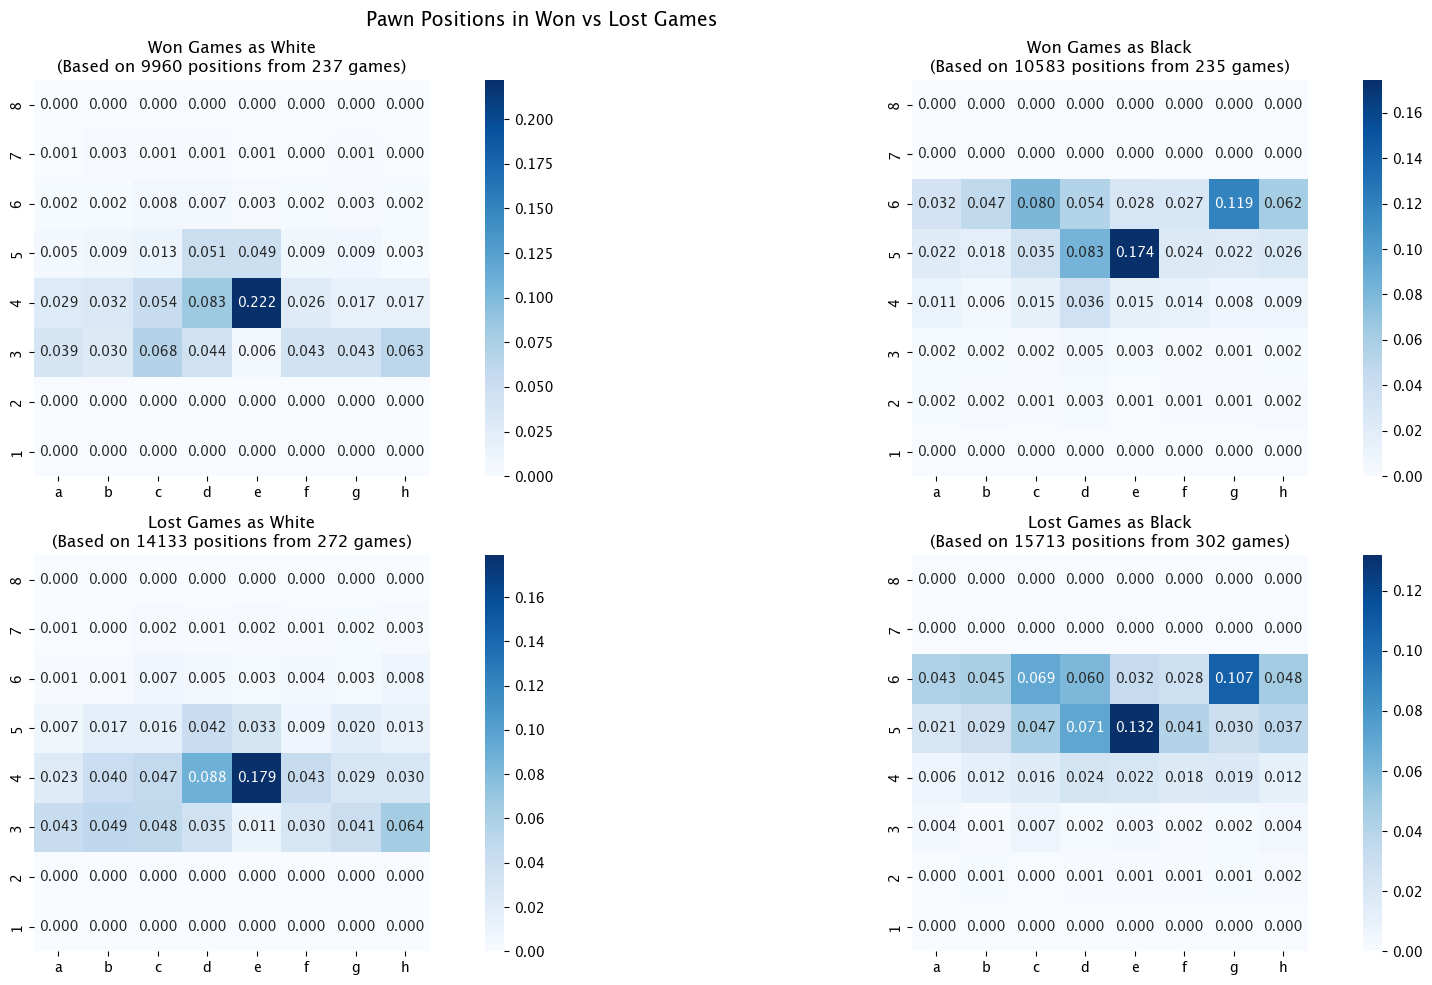


Analysis Summary:

Won Games:
As White: 237 games, 9960 positions analyzed
As Black: 235 games, 10583 positions analyzed

Lost Games:
As White: 272 games, 14133 positions analyzed
As Black: 302 games, 15713 positions analyzed


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from chess import Board
import chess

PIECE_TYPE = 'p'

def initialize_board():
    return np.zeros((8, 8))

def square_to_indices(square):
    col = ord(square[0]) - ord('a')
    row = 8 - int(square[1])
    return row, col

def get_starting_position(piece_type, is_white):
    # Dictionary of starting squares for each piece type
    starting_positions = {
        'p': ['a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2'] if is_white else 
             ['a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7'],
        'r': ['a1', 'h1'] if is_white else ['a8', 'h8'],
        'n': ['b1', 'g1'] if is_white else ['b8', 'g8'],
        'b': ['c1', 'f1'] if is_white else ['c8', 'f8'],
        'q': ['d1'] if is_white else ['d8'],
        'k': ['e1'] if is_white else ['e8']
    }
    return starting_positions.get(piece_type.lower(), [])

def update_heatmap(board, heatmap, total_positions, is_player_white, piece_type):
    piece_count = 0
    temp_heatmap = np.zeros((8, 8))
    starting_squares = get_starting_position(piece_type, is_player_white)
    
    for square in board.piece_map():
        piece = board.piece_at(square)
        if piece.color == chess.WHITE and is_player_white or \
           piece.color == chess.BLACK and not is_player_white:
            if str(piece).lower() == piece_type.lower():
                square_str = chess.square_name(square)
                # Skip if piece is in starting position
                if square_str in starting_squares:
                    continue
                row, col = square_to_indices(square_str)
                temp_heatmap[row, col] += 1
                piece_count += 1
    
    if piece_count > 0:
        heatmap += temp_heatmap
        total_positions += 1
    
    return heatmap, total_positions

def normalize_heatmap(heatmap):
    total_pawns = np.sum(heatmap)
    return heatmap / total_pawns if total_pawns > 0 else heatmap

# Set fixed username
player_username = "tazedurum07"

# Initialize heatmaps for won and lost games
won_white_heatmap = initialize_board()
won_black_heatmap = initialize_board()
lost_white_heatmap = initialize_board()
lost_black_heatmap = initialize_board()

# Initialize counters
won_white_positions = won_black_positions = 0
lost_white_positions = lost_black_positions = 0
won_white_games = won_black_games = 0
lost_white_games = lost_black_games = 0

# Load and process games
with open("lichess_games.json", "r", encoding="utf-8") as file:
    games = json.load(file)
    
for game in games:
    player_is_white = game['players']['white'].get('user', {}).get('name', None) == player_username.lower()

    # Determine if player won based on status and winner
    status = game['status']
    if status == 'mate' or status == 'resign' or status == 'timeout':
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
    elif status == 'draw' or status == 'stalemate':
        # Skip drawn games or handle them separately
        continue
    else:
        # Handle other statuses or skip them
        continue
       
    # Select appropriate heatmap and counter based on color and outcome
    if player_won:
        if player_is_white:
            current_heatmap = won_white_heatmap
            won_white_games += 1
            current_positions = won_white_positions
        else:
            current_heatmap = won_black_heatmap
            won_black_games += 1
            current_positions = won_black_positions
    else:
        if player_is_white:
            current_heatmap = lost_white_heatmap
            lost_white_games += 1
            current_positions = lost_white_positions
        else:
            current_heatmap = lost_black_heatmap
            lost_black_games += 1
            current_positions = lost_black_positions
    
    board = Board()
    moves = game["moves"].split()
    
    for move in moves:
        try:
            board.push_san(move)
            # Then in your main processing loop, update the update_heatmap calls:
            if player_won:
                if player_is_white:
                    won_white_heatmap, won_white_positions = update_heatmap(
                        board, won_white_heatmap, won_white_positions, True, PIECE_TYPE)
                else:
                    won_black_heatmap, won_black_positions = update_heatmap(
                        board, won_black_heatmap, won_black_positions, False, PIECE_TYPE)
            else:
                if player_is_white:
                    lost_white_heatmap, lost_white_positions = update_heatmap(
                        board, lost_white_heatmap, lost_white_positions, True, PIECE_TYPE)
                else:
                    lost_black_heatmap, lost_black_positions = update_heatmap(
                        board, lost_black_heatmap, lost_black_positions, False, PIECE_TYPE)           
        except ValueError:
            continue

piece_names = {'p': 'Pawn', 'r': 'Rook', 'n': 'Knight', 'b': 'Bishop', 'q': 'Queen', 'k': 'King'}


# Create figure with subplots for won and lost games
plt.figure(figsize=(20, 10))
plt.suptitle(f"{piece_names[PIECE_TYPE]} Positions in Won vs Lost Games", fontsize=14)

# Plot Won Games
plt.subplot(2, 2, 1)
if won_white_positions > 0:
    heatmap_normalized = normalize_heatmap(won_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as White\n(Based on {won_white_positions} positions from {won_white_games} games)")

plt.subplot(2, 2, 2)
if won_black_positions > 0:
    heatmap_normalized = normalize_heatmap(won_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as Black\n(Based on {won_black_positions} positions from {won_black_games} games)")

# Plot Lost Games
plt.subplot(2, 2, 3)
if lost_white_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as White\n(Based on {lost_white_positions} positions from {lost_white_games} games)")

plt.subplot(2, 2, 4)
if lost_black_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as Black\n(Based on {lost_black_positions} positions from {lost_black_games} games)")

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nAnalysis Summary:")
print(f"\nWon Games:")
print(f"As White: {won_white_games} games, {won_white_positions} positions analyzed")
print(f"As Black: {won_black_games} games, {won_black_positions} positions analyzed")
print(f"\nLost Games:")
print(f"As White: {lost_white_games} games, {lost_white_positions} positions analyzed")
print(f"As Black: {lost_black_games} games, {lost_black_positions} positions analyzed")

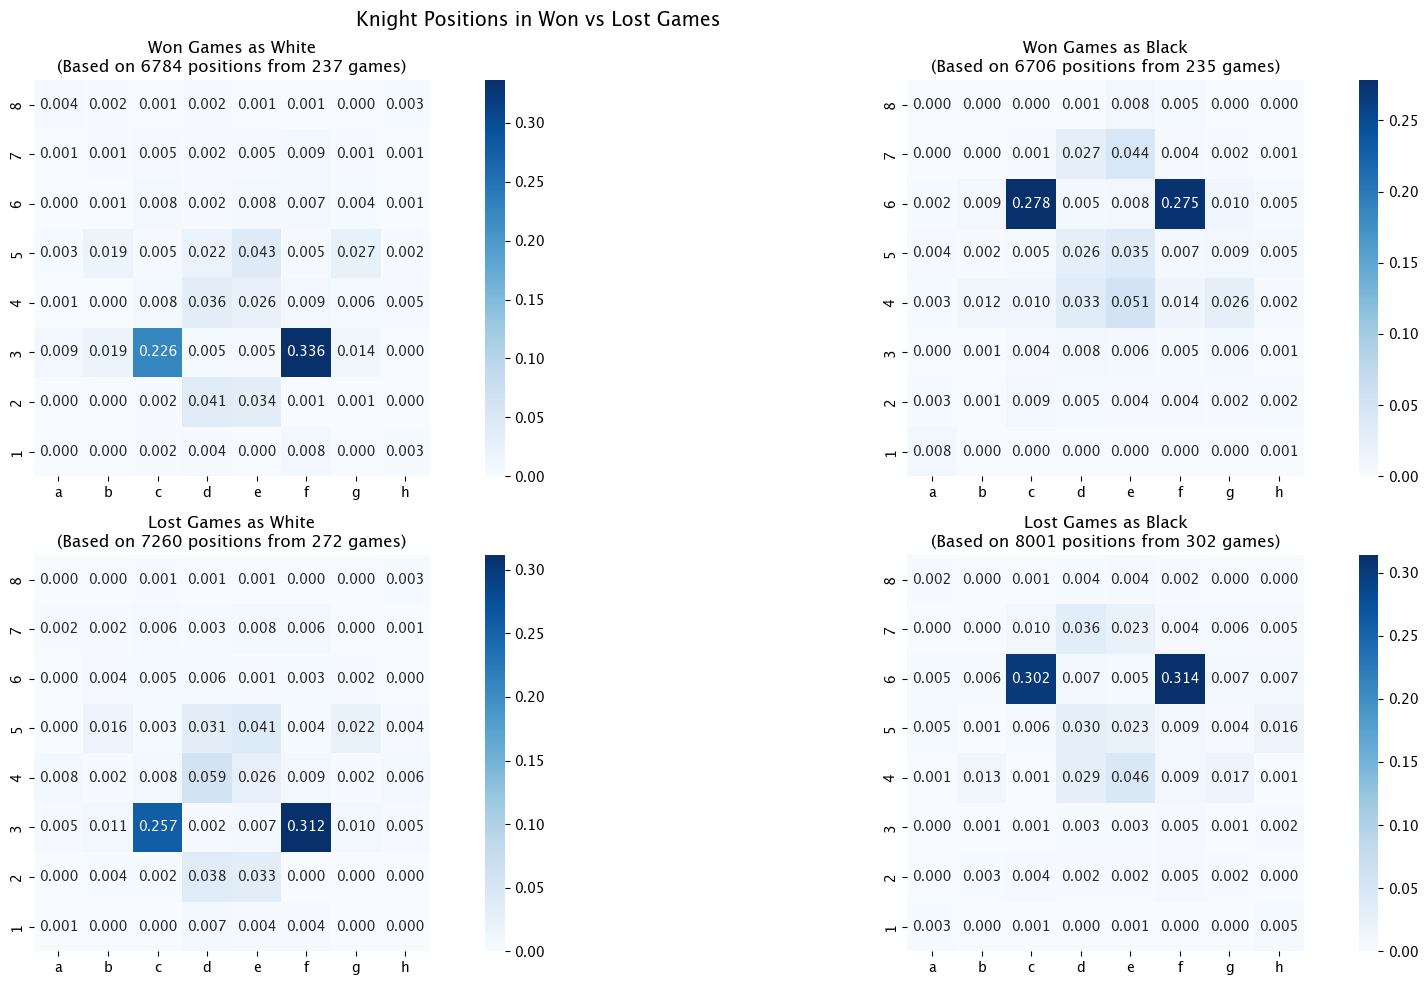


Analysis Summary:

Won Games:
As White: 237 games, 6784 positions analyzed
As Black: 235 games, 6706 positions analyzed

Lost Games:
As White: 272 games, 7260 positions analyzed
As Black: 302 games, 8001 positions analyzed


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from chess import Board
import chess

PIECE_TYPE = 'n'

def initialize_board():
    return np.zeros((8, 8))

def square_to_indices(square):
    col = ord(square[0]) - ord('a')
    row = 8 - int(square[1])
    return row, col

def get_starting_position(piece_type, is_white):
    # Dictionary of starting squares for each piece type
    starting_positions = {
        'p': ['a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2'] if is_white else 
             ['a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7'],
        'r': ['a1', 'h1'] if is_white else ['a8', 'h8'],
        'n': ['b1', 'g1'] if is_white else ['b8', 'g8'],
        'b': ['c1', 'f1'] if is_white else ['c8', 'f8'],
        'q': ['d1'] if is_white else ['d8'],
        'k': ['e1'] if is_white else ['e8']
    }
    return starting_positions.get(piece_type.lower(), [])

def update_heatmap(board, heatmap, total_positions, is_player_white, piece_type):
    piece_count = 0
    temp_heatmap = np.zeros((8, 8))
    starting_squares = get_starting_position(piece_type, is_player_white)
    
    for square in board.piece_map():
        piece = board.piece_at(square)
        if piece.color == chess.WHITE and is_player_white or \
           piece.color == chess.BLACK and not is_player_white:
            if str(piece).lower() == piece_type.lower():
                square_str = chess.square_name(square)
                # Skip if piece is in starting position
                if square_str in starting_squares:
                    continue
                row, col = square_to_indices(square_str)
                temp_heatmap[row, col] += 1
                piece_count += 1
    
    if piece_count > 0:
        heatmap += temp_heatmap
        total_positions += 1
    
    return heatmap, total_positions

def normalize_heatmap(heatmap):
    total_pawns = np.sum(heatmap)
    return heatmap / total_pawns if total_pawns > 0 else heatmap

# Set fixed username
player_username = "tazedurum07"

# Initialize heatmaps for won and lost games
won_white_heatmap = initialize_board()
won_black_heatmap = initialize_board()
lost_white_heatmap = initialize_board()
lost_black_heatmap = initialize_board()

# Initialize counters
won_white_positions = won_black_positions = 0
lost_white_positions = lost_black_positions = 0
won_white_games = won_black_games = 0
lost_white_games = lost_black_games = 0

# Load and process games
with open("lichess_games.json", "r", encoding="utf-8") as file:
    games = json.load(file)

for game in games:
    player_is_white = game['players']['white'].get('user', {}).get('name', None) == player_username.lower()

    # Determine if player won based on status and winner
    status = game['status']
    if status == 'mate' or status == 'resign' or status == 'timeout':
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
    elif status == 'draw' or status == 'stalemate':
        # Skip drawn games or handle them separately
        continue
    else:
        # Handle other statuses or skip them
        continue
       
    # Select appropriate heatmap and counter based on color and outcome
    if player_won:
        if player_is_white:
            current_heatmap = won_white_heatmap
            won_white_games += 1
            current_positions = won_white_positions
        else:
            current_heatmap = won_black_heatmap
            won_black_games += 1
            current_positions = won_black_positions
    else:
        if player_is_white:
            current_heatmap = lost_white_heatmap
            lost_white_games += 1
            current_positions = lost_white_positions
        else:
            current_heatmap = lost_black_heatmap
            lost_black_games += 1
            current_positions = lost_black_positions
    
    board = Board()
    moves = game["moves"].split()
    
    for move in moves:
        try:
            board.push_san(move)
            # Then in your main processing loop, update the update_heatmap calls:
            if player_won:
                if player_is_white:
                    won_white_heatmap, won_white_positions = update_heatmap(
                        board, won_white_heatmap, won_white_positions, True, PIECE_TYPE)
                else:
                    won_black_heatmap, won_black_positions = update_heatmap(
                        board, won_black_heatmap, won_black_positions, False, PIECE_TYPE)
            else:
                if player_is_white:
                    lost_white_heatmap, lost_white_positions = update_heatmap(
                        board, lost_white_heatmap, lost_white_positions, True, PIECE_TYPE)
                else:
                    lost_black_heatmap, lost_black_positions = update_heatmap(
                        board, lost_black_heatmap, lost_black_positions, False, PIECE_TYPE)           
        except ValueError:
            continue

piece_names = {'p': 'Pawn', 'r': 'Rook', 'n': 'Knight', 'b': 'Bishop', 'q': 'Queen', 'k': 'King'}


# Create figure with subplots for won and lost games
plt.figure(figsize=(20, 10))
plt.suptitle(f"{piece_names[PIECE_TYPE]} Positions in Won vs Lost Games", fontsize=14)

# Plot Won Games
plt.subplot(2, 2, 1)
if won_white_positions > 0:
    heatmap_normalized = normalize_heatmap(won_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as White\n(Based on {won_white_positions} positions from {won_white_games} games)")

plt.subplot(2, 2, 2)
if won_black_positions > 0:
    heatmap_normalized = normalize_heatmap(won_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as Black\n(Based on {won_black_positions} positions from {won_black_games} games)")

# Plot Lost Games
plt.subplot(2, 2, 3)
if lost_white_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as White\n(Based on {lost_white_positions} positions from {lost_white_games} games)")

plt.subplot(2, 2, 4)
if lost_black_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as Black\n(Based on {lost_black_positions} positions from {lost_black_games} games)")

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nAnalysis Summary:")
print(f"\nWon Games:")
print(f"As White: {won_white_games} games, {won_white_positions} positions analyzed")
print(f"As Black: {won_black_games} games, {won_black_positions} positions analyzed")
print(f"\nLost Games:")
print(f"As White: {lost_white_games} games, {lost_white_positions} positions analyzed")
print(f"As Black: {lost_black_games} games, {lost_black_positions} positions analyzed")

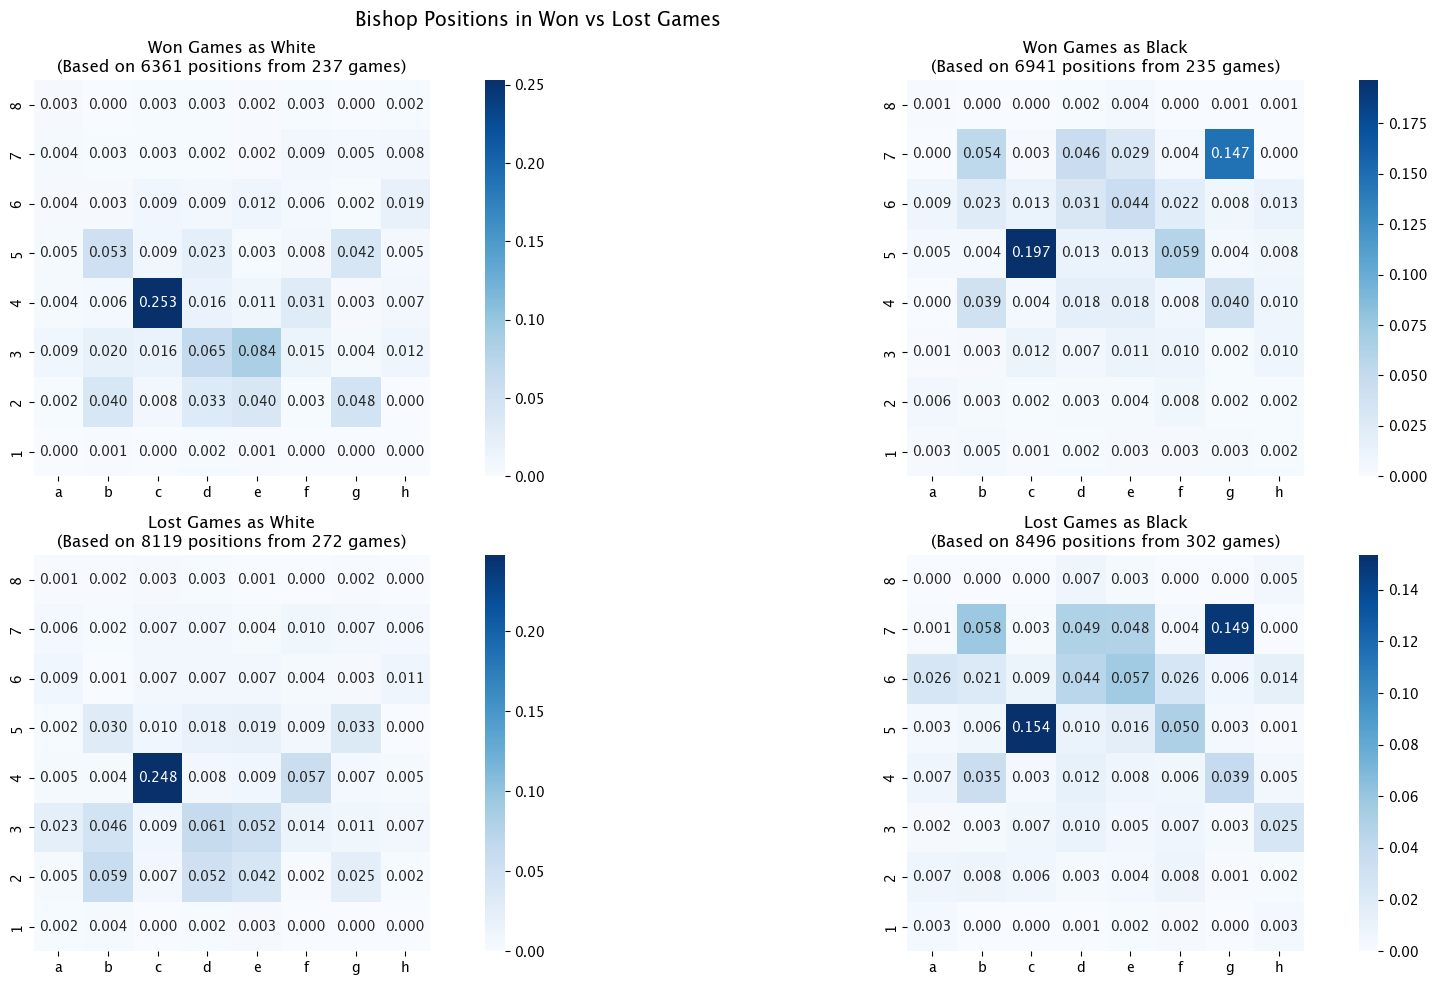


Analysis Summary:

Won Games:
As White: 237 games, 6361 positions analyzed
As Black: 235 games, 6941 positions analyzed

Lost Games:
As White: 272 games, 8119 positions analyzed
As Black: 302 games, 8496 positions analyzed


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from chess import Board
import chess

PIECE_TYPE = 'b'

def initialize_board():
    return np.zeros((8, 8))

def square_to_indices(square):
    col = ord(square[0]) - ord('a')
    row = 8 - int(square[1])
    return row, col

def get_starting_position(piece_type, is_white):
    # Dictionary of starting squares for each piece type
    starting_positions = {
        'p': ['a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2'] if is_white else 
             ['a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7'],
        'r': ['a1', 'h1'] if is_white else ['a8', 'h8'],
        'n': ['b1', 'g1'] if is_white else ['b8', 'g8'],
        'b': ['c1', 'f1'] if is_white else ['c8', 'f8'],
        'q': ['d1'] if is_white else ['d8'],
        'k': ['e1'] if is_white else ['e8']
    }
    return starting_positions.get(piece_type.lower(), [])

def update_heatmap(board, heatmap, total_positions, is_player_white, piece_type):
    piece_count = 0
    temp_heatmap = np.zeros((8, 8))
    starting_squares = get_starting_position(piece_type, is_player_white)
    
    for square in board.piece_map():
        piece = board.piece_at(square)
        if piece.color == chess.WHITE and is_player_white or \
           piece.color == chess.BLACK and not is_player_white:
            if str(piece).lower() == piece_type.lower():
                square_str = chess.square_name(square)
                # Skip if piece is in starting position
                if square_str in starting_squares:
                    continue
                row, col = square_to_indices(square_str)
                temp_heatmap[row, col] += 1
                piece_count += 1
    
    if piece_count > 0:
        heatmap += temp_heatmap
        total_positions += 1
    
    return heatmap, total_positions

def normalize_heatmap(heatmap):
    total_pawns = np.sum(heatmap)
    return heatmap / total_pawns if total_pawns > 0 else heatmap

#Set fixed username
player_username = "tazedurum07"

#Initialize heatmaps for won and lost games
won_white_heatmap = initialize_board()
won_black_heatmap = initialize_board()
lost_white_heatmap = initialize_board()
lost_black_heatmap = initialize_board()

#Initialize counters
won_white_positions = won_black_positions = 0
lost_white_positions = lost_black_positions = 0
won_white_games = won_black_games = 0
lost_white_games = lost_black_games = 0

#Load and process games
with open("lichess_games.json", "r", encoding="utf-8") as file:
    games = json.load(file)

for game in games:
    player_is_white = game['players']['white'].get('user', {}).get('name', None) == player_username.lower()

    #Determine if player won based on status and winner
    status = game['status']
    if status == 'mate' or status == 'resign' or status == 'timeout':
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
    elif status == 'draw' or status == 'stalemate':
        #Skip drawn games or handle them separately
        continue
    else:
        #Handle other statuses or skip them
        continue
       
    #Select appropriate heatmap and counter based on color and outcome
    if player_won:
        if player_is_white:
            current_heatmap = won_white_heatmap
            won_white_games += 1
            current_positions = won_white_positions
        else:
            current_heatmap = won_black_heatmap
            won_black_games += 1
            current_positions = won_black_positions
    else:
        if player_is_white:
            current_heatmap = lost_white_heatmap
            lost_white_games += 1
            current_positions = lost_white_positions
        else:
            current_heatmap = lost_black_heatmap
            lost_black_games += 1
            current_positions = lost_black_positions
    
    board = Board()
    moves = game["moves"].split()
    
    for move in moves:
        try:
            board.push_san(move)
            #Then in your main processing loop, update the update_heatmap calls:
            if player_won:
                if player_is_white:
                    won_white_heatmap, won_white_positions = update_heatmap(
                        board, won_white_heatmap, won_white_positions, True, PIECE_TYPE)
                else:
                    won_black_heatmap, won_black_positions = update_heatmap(
                        board, won_black_heatmap, won_black_positions, False, PIECE_TYPE)
            else:
                if player_is_white:
                    lost_white_heatmap, lost_white_positions = update_heatmap(
                        board, lost_white_heatmap, lost_white_positions, True, PIECE_TYPE)
                else:
                    lost_black_heatmap, lost_black_positions = update_heatmap(
                        board, lost_black_heatmap, lost_black_positions, False, PIECE_TYPE)           
        except ValueError:
            continue

piece_names = {'p': 'Pawn', 'r': 'Rook', 'n': 'Knight', 'b': 'Bishop', 'q': 'Queen', 'k': 'King'}


#Create figure with subplots for won and lost games
plt.figure(figsize=(20, 10))
plt.suptitle(f"{piece_names[PIECE_TYPE]} Positions in Won vs Lost Games", fontsize=14)

#Plot Won Games
plt.subplot(2, 2, 1)
if won_white_positions > 0:
    heatmap_normalized = normalize_heatmap(won_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as White\n(Based on {won_white_positions} positions from {won_white_games} games)")

plt.subplot(2, 2, 2)
if won_black_positions > 0:
    heatmap_normalized = normalize_heatmap(won_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as Black\n(Based on {won_black_positions} positions from {won_black_games} games)")

#Plot Lost Games
plt.subplot(2, 2, 3)
if lost_white_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as White\n(Based on {lost_white_positions} positions from {lost_white_games} games)")

plt.subplot(2, 2, 4)
if lost_black_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as Black\n(Based on {lost_black_positions} positions from {lost_black_games} games)")

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nAnalysis Summary:")
print(f"\nWon Games:")
print(f"As White: {won_white_games} games, {won_white_positions} positions analyzed")
print(f"As Black: {won_black_games} games, {won_black_positions} positions analyzed")
print(f"\nLost Games:")
print(f"As White: {lost_white_games} games, {lost_white_positions} positions analyzed")
print(f"As Black: {lost_black_games} games, {lost_black_positions} positions analyzed")


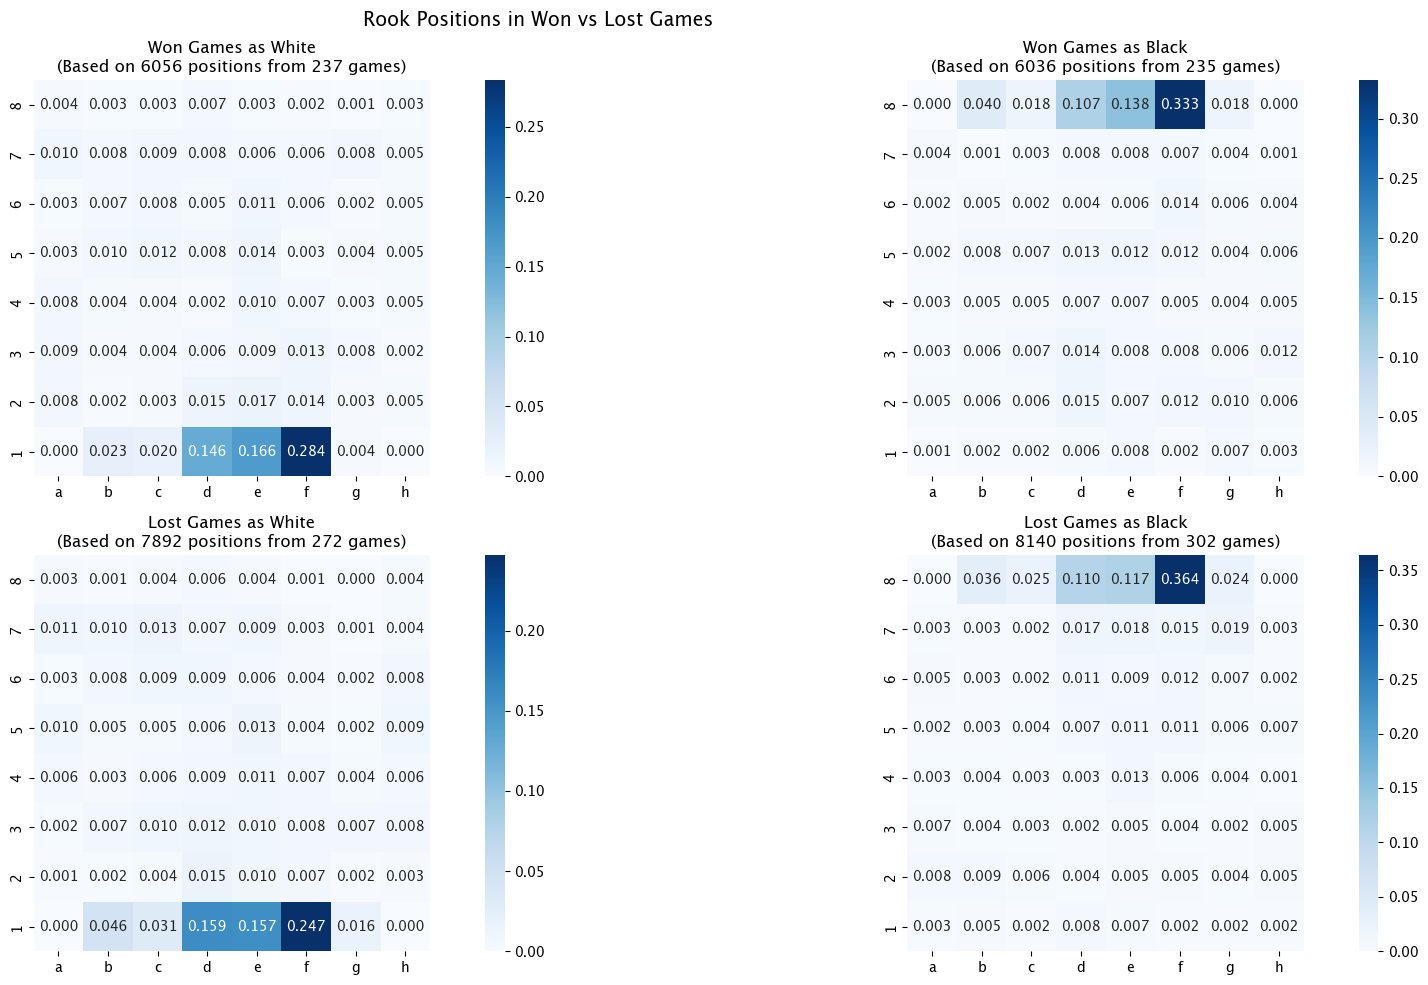


Analysis Summary:

Won Games:
As White: 237 games, 6056 positions analyzed
As Black: 235 games, 6036 positions analyzed

Lost Games:
As White: 272 games, 7892 positions analyzed
As Black: 302 games, 8140 positions analyzed


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from chess import Board
import chess

PIECE_TYPE = 'r'

def initialize_board():
    return np.zeros((8, 8))

def square_to_indices(square):
    col = ord(square[0]) - ord('a')
    row = 8 - int(square[1])
    return row, col

def get_starting_position(piece_type, is_white):
    # Dictionary of starting squares for each piece type
    starting_positions = {
        'p': ['a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2'] if is_white else 
             ['a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7'],
        'r': ['a1', 'h1'] if is_white else ['a8', 'h8'],
        'n': ['b1', 'g1'] if is_white else ['b8', 'g8'],
        'b': ['c1', 'f1'] if is_white else ['c8', 'f8'],
        'q': ['d1'] if is_white else ['d8'],
        'k': ['e1'] if is_white else ['e8']
    }
    return starting_positions.get(piece_type.lower(), [])

def update_heatmap(board, heatmap, total_positions, is_player_white, piece_type):
    piece_count = 0
    temp_heatmap = np.zeros((8, 8))
    starting_squares = get_starting_position(piece_type, is_player_white)
    
    for square in board.piece_map():
        piece = board.piece_at(square)
        if piece.color == chess.WHITE and is_player_white or \
           piece.color == chess.BLACK and not is_player_white:
            if str(piece).lower() == piece_type.lower():
                square_str = chess.square_name(square)
                # Skip if piece is in starting position
                if square_str in starting_squares:
                    continue
                row, col = square_to_indices(square_str)
                temp_heatmap[row, col] += 1
                piece_count += 1
    
    if piece_count > 0:
        heatmap += temp_heatmap
        total_positions += 1
    
    return heatmap, total_positions

def normalize_heatmap(heatmap):
    total_pawns = np.sum(heatmap)
    return heatmap / total_pawns if total_pawns > 0 else heatmap

# Set fixed username
player_username = "tazedurum07"

# Initialize heatmaps for won and lost games
won_white_heatmap = initialize_board()
won_black_heatmap = initialize_board()
lost_white_heatmap = initialize_board()
lost_black_heatmap = initialize_board()

# Initialize counters
won_white_positions = won_black_positions = 0
lost_white_positions = lost_black_positions = 0
won_white_games = won_black_games = 0
lost_white_games = lost_black_games = 0

# Load and process games
with open("lichess_games.json", "r", encoding="utf-8") as file:
    games = json.load(file)

for game in games:
    player_is_white = game['players']['white'].get('user', {}).get('name', None) == player_username.lower()

    # Determine if player won based on status and winner
    status = game['status']
    if status == 'mate' or status == 'resign' or status == 'timeout':
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
    elif status == 'draw' or status == 'stalemate':
        # Skip drawn games or handle them separately
        continue
    else:
        # Handle other statuses or skip them
        continue
       
    # Select appropriate heatmap and counter based on color and outcome
    if player_won:
        if player_is_white:
            current_heatmap = won_white_heatmap
            won_white_games += 1
            current_positions = won_white_positions
        else:
            current_heatmap = won_black_heatmap
            won_black_games += 1
            current_positions = won_black_positions
    else:
        if player_is_white:
            current_heatmap = lost_white_heatmap
            lost_white_games += 1
            current_positions = lost_white_positions
        else:
            current_heatmap = lost_black_heatmap
            lost_black_games += 1
            current_positions = lost_black_positions
    
    board = Board()
    moves = game["moves"].split()
    
    for move in moves:
        try:
            board.push_san(move)
            # Then in your main processing loop, update the update_heatmap calls:
            if player_won:
                if player_is_white:
                    won_white_heatmap, won_white_positions = update_heatmap(
                        board, won_white_heatmap, won_white_positions, True, PIECE_TYPE)
                else:
                    won_black_heatmap, won_black_positions = update_heatmap(
                        board, won_black_heatmap, won_black_positions, False, PIECE_TYPE)
            else:
                if player_is_white:
                    lost_white_heatmap, lost_white_positions = update_heatmap(
                        board, lost_white_heatmap, lost_white_positions, True, PIECE_TYPE)
                else:
                    lost_black_heatmap, lost_black_positions = update_heatmap(
                        board, lost_black_heatmap, lost_black_positions, False, PIECE_TYPE)           
        except ValueError:
            continue

piece_names = {'p': 'Pawn', 'r': 'Rook', 'n': 'Knight', 'b': 'Bishop', 'q': 'Queen', 'k': 'King'}


# Create figure with subplots for won and lost games
plt.figure(figsize=(20, 10))
plt.suptitle(f"{piece_names[PIECE_TYPE]} Positions in Won vs Lost Games", fontsize=14)

# Plot Won Games
plt.subplot(2, 2, 1)
if won_white_positions > 0:
    heatmap_normalized = normalize_heatmap(won_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as White\n(Based on {won_white_positions} positions from {won_white_games} games)")

plt.subplot(2, 2, 2)
if won_black_positions > 0:
    heatmap_normalized = normalize_heatmap(won_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as Black\n(Based on {won_black_positions} positions from {won_black_games} games)")

# Plot Lost Games
plt.subplot(2, 2, 3)
if lost_white_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as White\n(Based on {lost_white_positions} positions from {lost_white_games} games)")

plt.subplot(2, 2, 4)
if lost_black_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as Black\n(Based on {lost_black_positions} positions from {lost_black_games} games)")

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nAnalysis Summary:")
print(f"\nWon Games:")
print(f"As White: {won_white_games} games, {won_white_positions} positions analyzed")
print(f"As Black: {won_black_games} games, {won_black_positions} positions analyzed")
print(f"\nLost Games:")
print(f"As White: {lost_white_games} games, {lost_white_positions} positions analyzed")
print(f"As Black: {lost_black_games} games, {lost_black_positions} positions analyzed")

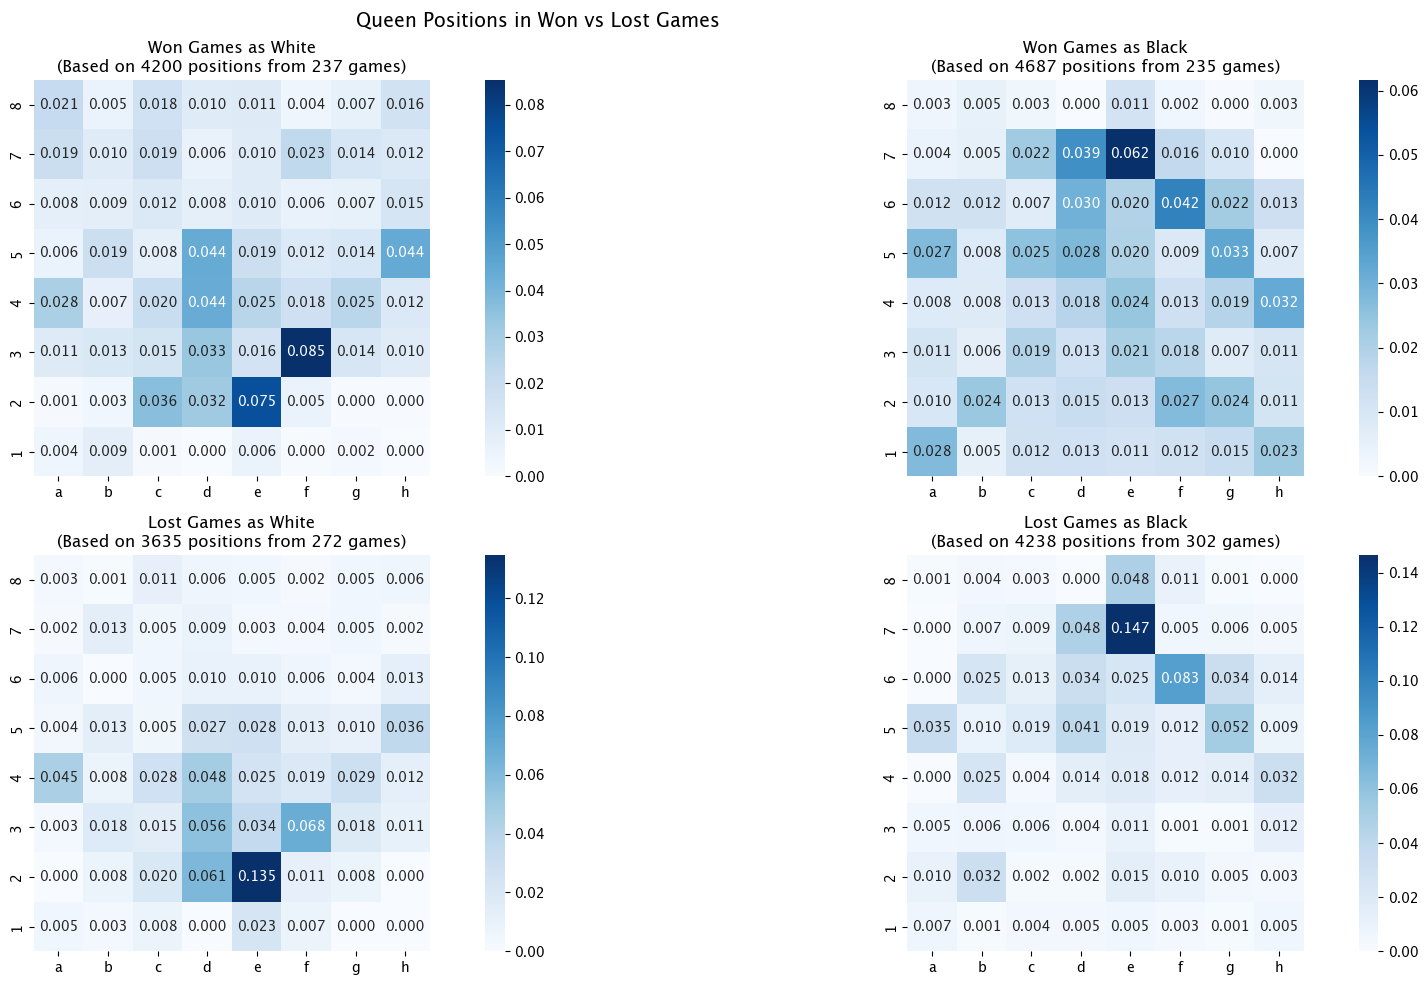


Analysis Summary:

Won Games:
As White: 237 games, 4200 positions analyzed
As Black: 235 games, 4687 positions analyzed

Lost Games:
As White: 272 games, 3635 positions analyzed
As Black: 302 games, 4238 positions analyzed


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from chess import Board
import chess

PIECE_TYPE = 'q'

def initialize_board():
    return np.zeros((8, 8))

def square_to_indices(square):
    col = ord(square[0]) - ord('a')
    row = 8 - int(square[1])
    return row, col

def get_starting_position(piece_type, is_white):
    #Dictionary of starting squares for each piece type
    starting_positions = {
        'p': ['a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2'] if is_white else 
             ['a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7'],
        'r': ['a1', 'h1'] if is_white else ['a8', 'h8'],
        'n': ['b1', 'g1'] if is_white else ['b8', 'g8'],
        'b': ['c1', 'f1'] if is_white else ['c8', 'f8'],
        'q': ['d1'] if is_white else ['d8'],
        'k': ['e1'] if is_white else ['e8']
    }
    return starting_positions.get(piece_type.lower(), [])

def update_heatmap(board, heatmap, total_positions, is_player_white, piece_type):
    piece_count = 0
    temp_heatmap = np.zeros((8, 8))
    starting_squares = get_starting_position(piece_type, is_player_white)
    
    for square in board.piece_map():
        piece = board.piece_at(square)
        if piece.color == chess.WHITE and is_player_white or \
           piece.color == chess.BLACK and not is_player_white:
            if str(piece).lower() == piece_type.lower():
                square_str = chess.square_name(square)
                #Skip if piece is in starting position
                if square_str in starting_squares:
                    continue
                row, col = square_to_indices(square_str)
                temp_heatmap[row, col] += 1
                piece_count += 1
    
    if piece_count > 0:
        heatmap += temp_heatmap
        total_positions += 1
    
    return heatmap, total_positions

def normalize_heatmap(heatmap):
    total_pawns = np.sum(heatmap)
    return heatmap / total_pawns if total_pawns > 0 else heatmap

#Set fixed username
player_username = "tazedurum07"

#Initialize heatmaps for won and lost games
won_white_heatmap = initialize_board()
won_black_heatmap = initialize_board()
lost_white_heatmap = initialize_board()
lost_black_heatmap = initialize_board()

#Initialize counters
won_white_positions = won_black_positions = 0
lost_white_positions = lost_black_positions = 0
won_white_games = won_black_games = 0
lost_white_games = lost_black_games = 0

#Load and process games
with open("lichess_games.json", "r", encoding="utf-8") as file:
    games = json.load(file)

for game in games:
    player_is_white = game['players']['white'].get('user', {}).get('name', None) == player_username.lower()

    #Determine if player won based on status and winner
    status = game['status']
    if status == 'mate' or status == 'resign' or status == 'timeout':
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
    elif status == 'draw' or status == 'stalemate':
        #Skip drawn games or handle them separately
        continue
    else:
        #Handle other statuses or skip them
        continue
       
    #Select appropriate heatmap and counter based on color and outcome
    if player_won:
        if player_is_white:
            current_heatmap = won_white_heatmap
            won_white_games += 1
            current_positions = won_white_positions
        else:
            current_heatmap = won_black_heatmap
            won_black_games += 1
            current_positions = won_black_positions
    else:
        if player_is_white:
            current_heatmap = lost_white_heatmap
            lost_white_games += 1
            current_positions = lost_white_positions
        else:
            current_heatmap = lost_black_heatmap
            lost_black_games += 1
            current_positions = lost_black_positions
    
    board = Board()
    moves = game["moves"].split()
    
    for move in moves:
        try:
            board.push_san(move)
            #Then in your main processing loop, update the update_heatmap calls:
            if player_won:
                if player_is_white:
                    won_white_heatmap, won_white_positions = update_heatmap(
                        board, won_white_heatmap, won_white_positions, True, PIECE_TYPE)
                else:
                    won_black_heatmap, won_black_positions = update_heatmap(
                        board, won_black_heatmap, won_black_positions, False, PIECE_TYPE)
            else:
                if player_is_white:
                    lost_white_heatmap, lost_white_positions = update_heatmap(
                        board, lost_white_heatmap, lost_white_positions, True, PIECE_TYPE)
                else:
                    lost_black_heatmap, lost_black_positions = update_heatmap(
                        board, lost_black_heatmap, lost_black_positions, False, PIECE_TYPE)           
        except ValueError:
            continue

piece_names = {'p': 'Pawn', 'r': 'Rook', 'n': 'Knight', 'b': 'Bishop', 'q': 'Queen', 'k': 'King'}


#Create figure with subplots for won and lost games
plt.figure(figsize=(20, 10))
plt.suptitle(f"{piece_names[PIECE_TYPE]} Positions in Won vs Lost Games", fontsize=14)

#Plot Won Games
plt.subplot(2, 2, 1)
if won_white_positions > 0:
    heatmap_normalized = normalize_heatmap(won_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as White\n(Based on {won_white_positions} positions from {won_white_games} games)")

plt.subplot(2, 2, 2)
if won_black_positions > 0:
    heatmap_normalized = normalize_heatmap(won_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as Black\n(Based on {won_black_positions} positions from {won_black_games} games)")

#Plot Lost Games
plt.subplot(2, 2, 3)
if lost_white_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as White\n(Based on {lost_white_positions} positions from {lost_white_games} games)")

plt.subplot(2, 2, 4)
if lost_black_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as Black\n(Based on {lost_black_positions} positions from {lost_black_games} games)")

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nAnalysis Summary:")
print(f"\nWon Games:")
print(f"As White: {won_white_games} games, {won_white_positions} positions analyzed")
print(f"As Black: {won_black_games} games, {won_black_positions} positions analyzed")
print(f"\nLost Games:")
print(f"As White: {lost_white_games} games, {lost_white_positions} positions analyzed")
print(f"As Black: {lost_black_games} games, {lost_black_positions} positions analyzed")

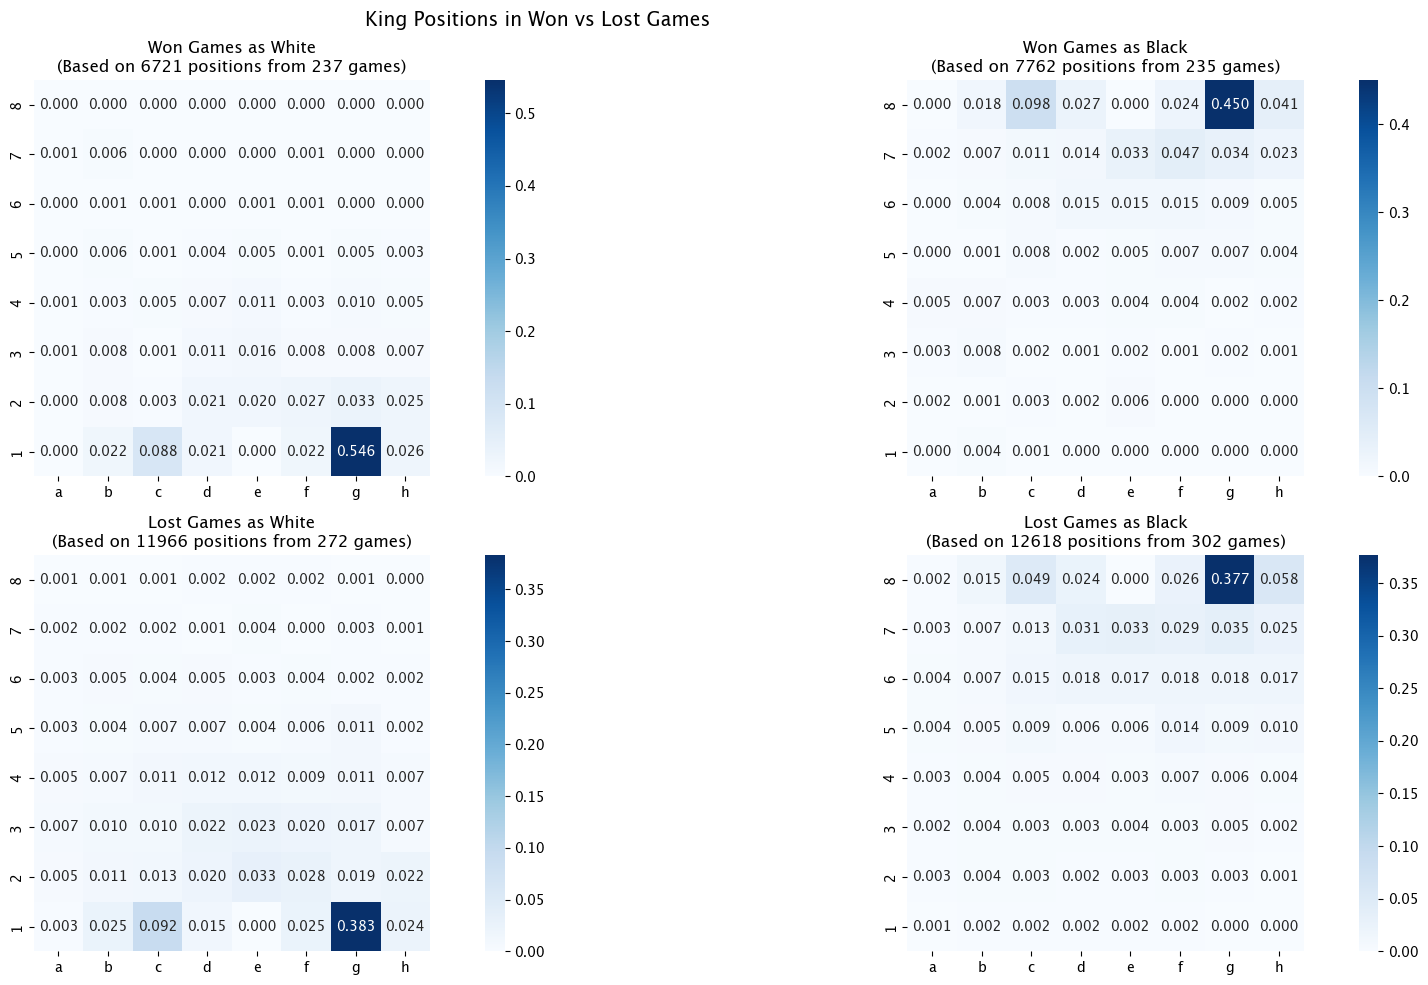


Analysis Summary:

Won Games:
As White: 237 games, 6721 positions analyzed
As Black: 235 games, 7762 positions analyzed

Lost Games:
As White: 272 games, 11966 positions analyzed
As Black: 302 games, 12618 positions analyzed


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from chess import Board
import chess

PIECE_TYPE = 'k'

def initialize_board():
    return np.zeros((8, 8))

def square_to_indices(square):
    col = ord(square[0]) - ord('a')
    row = 8 - int(square[1])
    return row, col

def get_starting_position(piece_type, is_white):
    #Dictionary of starting squares for each piece type
    starting_positions = {
        'p': ['a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2'] if is_white else 
             ['a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7'],
        'r': ['a1', 'h1'] if is_white else ['a8', 'h8'],
        'n': ['b1', 'g1'] if is_white else ['b8', 'g8'],
        'b': ['c1', 'f1'] if is_white else ['c8', 'f8'],
        'q': ['d1'] if is_white else ['d8'],
        'k': ['e1'] if is_white else ['e8']
    }
    return starting_positions.get(piece_type.lower(), [])

def update_heatmap(board, heatmap, total_positions, is_player_white, piece_type):
    piece_count = 0
    temp_heatmap = np.zeros((8, 8))
    starting_squares = get_starting_position(piece_type, is_player_white)
    
    for square in board.piece_map():
        piece = board.piece_at(square)
        if piece.color == chess.WHITE and is_player_white or \
           piece.color == chess.BLACK and not is_player_white:
            if str(piece).lower() == piece_type.lower():
                square_str = chess.square_name(square)
                #Skip if piece is in starting position
                if square_str in starting_squares:
                    continue
                row, col = square_to_indices(square_str)
                temp_heatmap[row, col] += 1
                piece_count += 1
    
    if piece_count > 0:
        heatmap += temp_heatmap
        total_positions += 1
    
    return heatmap, total_positions

def normalize_heatmap(heatmap):
    total_pawns = np.sum(heatmap)
    return heatmap / total_pawns if total_pawns > 0 else heatmap

#Set fixed username
player_username = "tazedurum07"

#Initialize heatmaps for won and lost games
won_white_heatmap = initialize_board()
won_black_heatmap = initialize_board()
lost_white_heatmap = initialize_board()
lost_black_heatmap = initialize_board()

#Initialize counters
won_white_positions = won_black_positions = 0
lost_white_positions = lost_black_positions = 0
won_white_games = won_black_games = 0
lost_white_games = lost_black_games = 0

#Load and process games
with open("lichess_games.json", "r", encoding="utf-8") as file:
    games = json.load(file)

for game in games:
    player_is_white = game['players']['white'].get('user', {}).get('name', None) == player_username.lower()

    #Determine if player won based on status and winner
    status = game['status']
    if status == 'mate' or status == 'resign' or status == 'timeout':
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
    elif status == 'draw' or status == 'stalemate':
        #Skip drawn games or handle them separately
        continue
    else:
        #Handle other statuses or skip them
        continue
       
    #Select appropriate heatmap and counter based on color and outcome
    if player_won:
        if player_is_white:
            current_heatmap = won_white_heatmap
            won_white_games += 1
            current_positions = won_white_positions
        else:
            current_heatmap = won_black_heatmap
            won_black_games += 1
            current_positions = won_black_positions
    else:
        if player_is_white:
            current_heatmap = lost_white_heatmap
            lost_white_games += 1
            current_positions = lost_white_positions
        else:
            current_heatmap = lost_black_heatmap
            lost_black_games += 1
            current_positions = lost_black_positions
    
    board = Board()
    moves = game["moves"].split()
    
    for move in moves:
        try:
            board.push_san(move)
            #Then in your main processing loop, update the update_heatmap calls:
            if player_won:
                if player_is_white:
                    won_white_heatmap, won_white_positions = update_heatmap(
                        board, won_white_heatmap, won_white_positions, True, PIECE_TYPE)
                else:
                    won_black_heatmap, won_black_positions = update_heatmap(
                        board, won_black_heatmap, won_black_positions, False, PIECE_TYPE)
            else:
                if player_is_white:
                    lost_white_heatmap, lost_white_positions = update_heatmap(
                        board, lost_white_heatmap, lost_white_positions, True, PIECE_TYPE)
                else:
                    lost_black_heatmap, lost_black_positions = update_heatmap(
                        board, lost_black_heatmap, lost_black_positions, False, PIECE_TYPE)           
        except ValueError:
            continue

piece_names = {'p': 'Pawn', 'r': 'Rook', 'n': 'Knight', 'b': 'Bishop', 'q': 'Queen', 'k': 'King'}


#Create figure with subplots for won and lost games
plt.figure(figsize=(20, 10))
plt.suptitle(f"{piece_names[PIECE_TYPE]} Positions in Won vs Lost Games", fontsize=14)

#Plot Won Games
plt.subplot(2, 2, 1)
if won_white_positions > 0:
    heatmap_normalized = normalize_heatmap(won_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as White\n(Based on {won_white_positions} positions from {won_white_games} games)")

plt.subplot(2, 2, 2)
if won_black_positions > 0:
    heatmap_normalized = normalize_heatmap(won_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Won Games as Black\n(Based on {won_black_positions} positions from {won_black_games} games)")

#Plot Lost Games
plt.subplot(2, 2, 3)
if lost_white_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_white_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as White\n(Based on {lost_white_positions} positions from {lost_white_games} games)")

plt.subplot(2, 2, 4)
if lost_black_positions > 0:
    heatmap_normalized = normalize_heatmap(lost_black_heatmap)
    sns.heatmap(heatmap_normalized, annot=True, fmt='.3f', cmap="Blues",
                square=True, cbar=True,
                xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
                yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.title(f"Lost Games as Black\n(Based on {lost_black_positions} positions from {lost_black_games} games)")

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nAnalysis Summary:")
print(f"\nWon Games:")
print(f"As White: {won_white_games} games, {won_white_positions} positions analyzed")
print(f"As Black: {won_black_games} games, {won_black_positions} positions analyzed")
print(f"\nLost Games:")
print(f"As White: {lost_white_games} games, {lost_white_positions} positions analyzed")
print(f"As Black: {lost_black_games} games, {lost_black_positions} positions analyzed")

/var/folders/g_/qxd37kgj1cb_c9yxwb54sjhw0000gn/T/ipykernel_96671/806224970.py:246: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45)


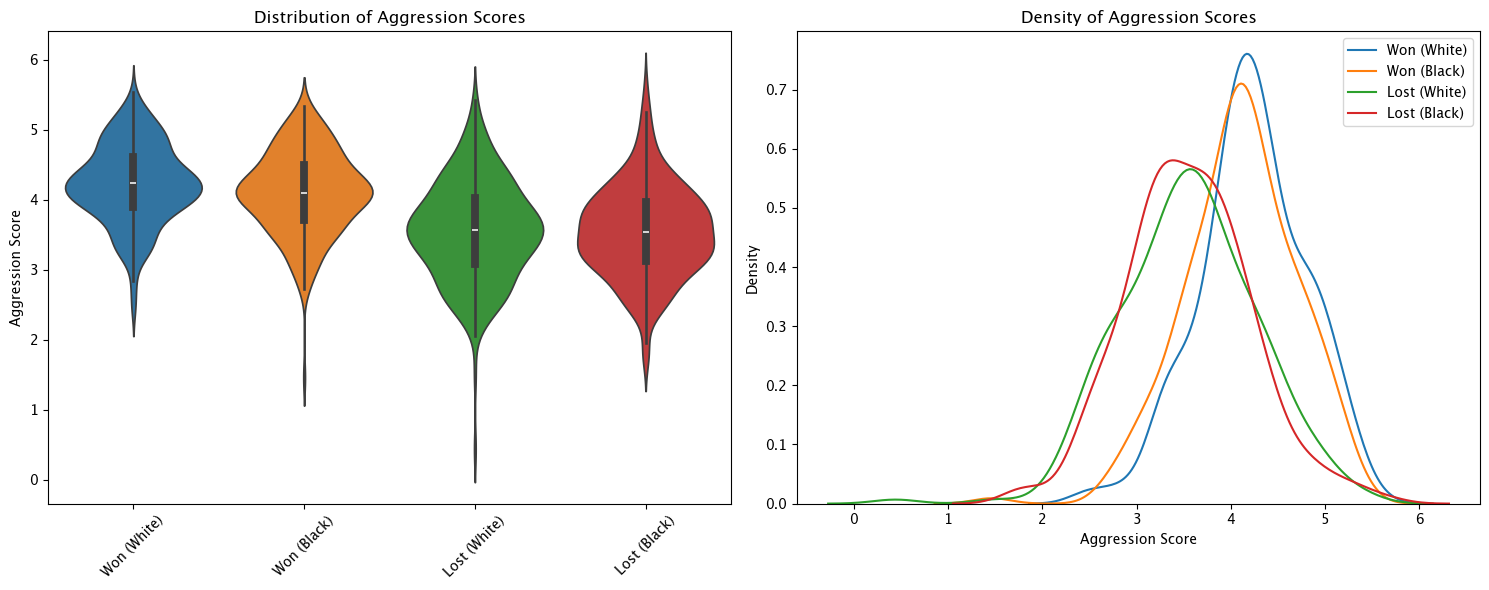


White Won:
Games: 213
Mean aggression: 4.23
Std deviation: 0.56

White Lost:
Games: 246
Mean aggression: 3.56
Std deviation: 0.71

Black Won:
Games: 218
Mean aggression: 4.10
Std deviation: 0.59

Black Lost:
Games: 272
Mean aggression: 3.55
Std deviation: 0.66


In [56]:
import chess
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def calculate_center_control(board, square, is_white):
    center_squares = {chess.E4, chess.E5, chess.D4, chess.D5}
    control_score = 0
    if square in center_squares:
        control_score += 1.0
    elif chess.square_distance(square, chess.E4) <= 2:
        control_score += 0.5
    return control_score

def evaluate_pawn_structure(board, move_obj, is_white):
    pawn_score = 0
    to_square = move_obj.to_square
    piece = board.piece_at(to_square)
    
    if piece and piece.piece_type == chess.PAWN:
        # Passed pawns
        rank = chess.square_rank(to_square)
        if is_white and rank >= 4:
            pawn_score += (rank - 3) * 0.5
        elif not is_white and rank <= 3:
            pawn_score += (4 - rank) * 0.5
            
        # Pawn chains
        for offset in [-1, 1]:
            support_square = to_square + (8 if is_white else -8) + offset
            if 0 <= support_square < 64 and board.piece_at(support_square):
                if board.piece_at(support_square).piece_type == chess.PAWN:
                    pawn_score += 0.3
                    
    return pawn_score

def calculate_piece_coordination(board, move_obj, is_white):
    coord_score = 0
    to_square = move_obj.to_square
    
    # Check supporting pieces
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == is_white:
            if board.is_attacked_by(is_white, to_square):
                coord_score += 0.2
                
    # Battery formations
    piece = board.piece_at(to_square)
    if piece:
        piece_type = piece.piece_type
        for direction in [(1,0), (-1,0), (0,1), (0,-1), (1,1), (1,-1), (-1,1), (-1,-1)]:
            coord_score += check_battery(board, to_square, direction, is_white) * 0.3
                
    return coord_score

def check_battery(board, square, direction, is_white):
    dx, dy = direction
    x, y = chess.square_file(square), chess.square_rank(square)
    coord_score = 0
    
    while True:
        x, y = x + dx, y + dy
        if not (0 <= x <= 7 and 0 <= y <= 7):
            break
            
        new_square = chess.square(x, y)
        piece = board.piece_at(new_square)
        if piece:
            if piece.color == is_white and piece.piece_type in [chess.QUEEN, chess.ROOK, chess.BISHOP]:
                coord_score += 1
            break
            
    return coord_score

def evaluate_sacrifice(board, move_obj, is_white):
    sacrifice_score = 0
    to_square = move_obj.to_square
    piece = board.piece_at(to_square)
    
    if board.is_capture(move_obj):
        captured_piece = board.piece_at(move_obj.to_square)
        attacking_piece = board.piece_at(move_obj.from_square)
        
        if captured_piece and attacking_piece:
            piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
                          chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0}
            material_diff = piece_values[captured_piece.piece_type] - piece_values[attacking_piece.piece_type]
            
            if material_diff < 0:
                # Sacrifice detected
                sacrifice_score -= material_diff  # Convert negative diff to positive score
                
                # Bonus for sacrifices near enemy king
                enemy_king_square = board.king(not is_white)
                if enemy_king_square:
                    distance_to_king = chess.square_distance(to_square, enemy_king_square)
                    sacrifice_score *= (1 + (8 - distance_to_king) * 0.2)
                    
    return sacrifice_score

def calculate_development_score(board, move_obj, move_number, is_white):
    development_score = 0
    
    # Early game development
    if move_number < 10:
        piece = board.piece_at(move_obj.from_square)
        if piece and piece.piece_type in [chess.KNIGHT, chess.BISHOP]:
            development_score += 0.5
            
        # Castling
        if board.is_castling(move_obj):
            development_score += 1.5
            
    return development_score

def calculate_aggression_score(board, move, move_number, is_white):
    try:
        move_obj = board.parse_san(move)
        aggression_score = 0
        
        # Original metrics
        from_square = move_obj.from_square
        to_square = move_obj.to_square
        
        # Piece advancement
        from_rank = chess.square_rank(from_square)
        to_rank = chess.square_rank(to_square)
        advancement = (to_rank - from_rank) if is_white else (from_rank - to_rank)
        aggression_score += max(0, advancement * 0.5)
        
        # Make move to analyze resulting position
        board.push(move_obj)
        
        # Center control
        center_score = calculate_center_control(board, to_square, is_white)
        aggression_score += center_score
        
        # Pawn structure
        pawn_score = evaluate_pawn_structure(board, move_obj, is_white)
        aggression_score += pawn_score
        
        # Piece coordination
        coordination_score = calculate_piece_coordination(board, move_obj, is_white)
        aggression_score += coordination_score
        
        # Sacrifices
        sacrifice_score = evaluate_sacrifice(board, move_obj, is_white)
        aggression_score += sacrifice_score
        
        # Development
        development_score = calculate_development_score(board, move_obj, move_number, is_white)
        aggression_score += development_score
        
        # Check score
        if board.is_check():
            aggression_score += 2
        
        # King proximity
        enemy_king_square = board.king(not is_white)
        if enemy_king_square:
            distance = chess.square_distance(to_square, enemy_king_square)
            aggression_score += max(0, (8 - distance) * 0.2)
            
        board.pop()
        return aggression_score
        
    except (ValueError, AttributeError):
        return 0

def analyze_game_aggression(moves, is_white):
    board = chess.Board()
    total_aggression = 0
    move_count = 0
    
    for move_number, move in enumerate(moves, 1):
        if (move_number % 2 == 1) == is_white:
            aggression_score = calculate_aggression_score(board, move, move_number, is_white)
            total_aggression += aggression_score
            move_count += 1
            
        try:
            board.push_san(move)
        except ValueError:
            continue
            
    return total_aggression / max(move_count, 1)

# Initialize data storage
aggression_data = {
    'white_won': [],
    'white_lost': [],
    'black_won': [],
    'black_lost': []
}

def analyze_games(filename, player_username):
    with open(filename, "r") as file:
        games = json.load(file)
        
    for game in games:
        if game.get('speed') != 'blitz':
            continue
            
        player_is_white = game['players']['white'].get('user', {}).get('name', '').lower() == player_username.lower()
        
        # Determine game outcome
        if game.get('status') not in ['mate', 'resign', 'timeout']:
            continue
            
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
                    
        # Calculate aggression
        moves = game['moves'].split()
        aggression = analyze_game_aggression(moves, player_is_white)
        
        # Store results
        if player_is_white:
            if player_won:
                aggression_data['white_won'].append(aggression)
            else:
                aggression_data['white_lost'].append(aggression)
        else:
            if player_won:
                aggression_data['black_won'].append(aggression)
            else:
                aggression_data['black_lost'].append(aggression)

def plot_aggression_analysis():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Prepare data for plotting
    data = [
        aggression_data['white_won'],
        aggression_data['black_won'],
        aggression_data['white_lost'],
        aggression_data['black_lost']
    ]
    labels = ['Won (White)', 'Won (Black)', 'Lost (White)', 'Lost (Black)']
    
    # Violin plot
    sns.violinplot(data=data, ax=ax1)
    ax1.set_xticklabels(labels, rotation=45)
    ax1.set_title('Distribution of Aggression Scores')
    ax1.set_ylabel('Aggression Score')
    
    # Density plot
    for d, label in zip(data, labels):
        sns.kdeplot(data=d, label=label, ax=ax2)
    ax2.set_title('Density of Aggression Scores')
    ax2.set_xlabel('Aggression Score')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    for category in ['white_won', 'white_lost', 'black_won', 'black_lost']:
        scores = aggression_data[category]
        if scores:
            print(f"\n{category.replace('_', ' ').title()}:")
            print(f"Games: {len(scores)}")
            print(f"Mean aggression: {np.mean(scores):.2f}")
            print(f"Std deviation: {np.std(scores):.2f}")

# Run analysis
player_username = "tazedurum07"
analyze_games("lichess_games.json", player_username)
plot_aggression_analysis()

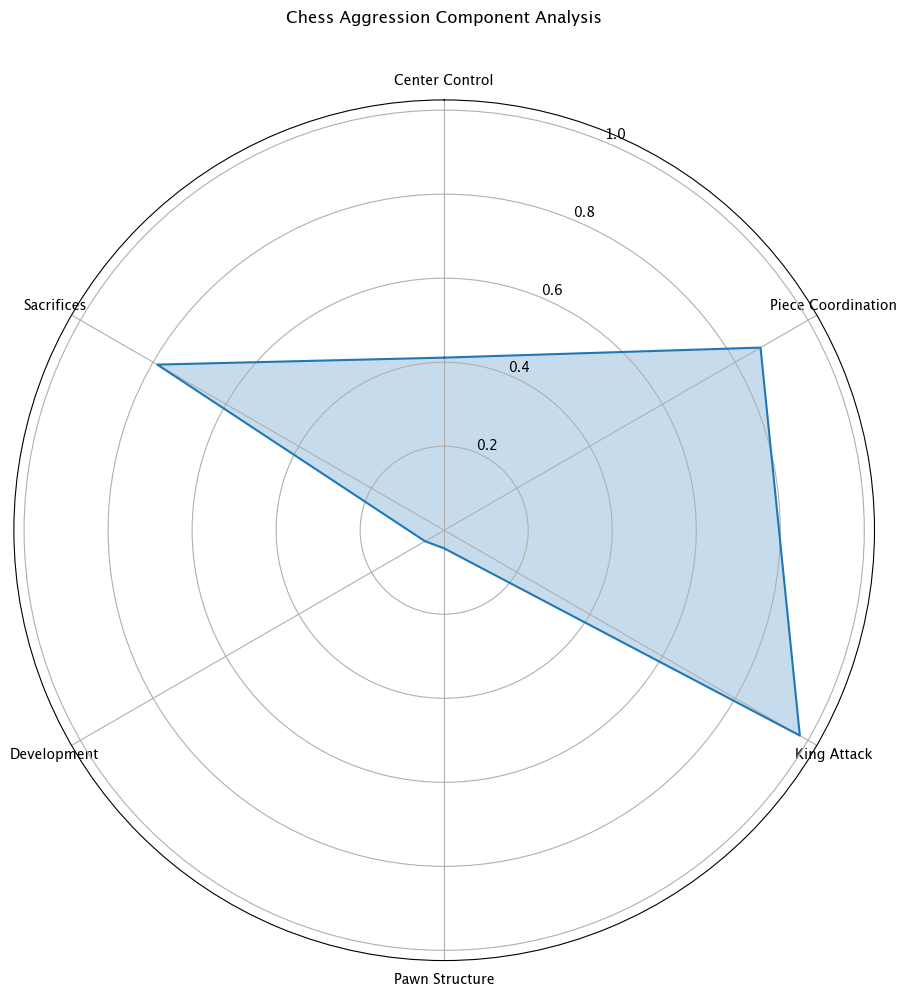

In [57]:
import chess
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

def calculate_center_control(board, square, is_white):
    center_squares = {chess.E4, chess.E5, chess.D4, chess.D5}
    control_score = 0
    if square in center_squares:
        control_score += 1.0
    elif chess.square_distance(square, chess.E4) <= 2:
        control_score += 0.5
    return control_score

def evaluate_pawn_structure(board, move_obj, is_white):
    pawn_score = 0
    to_square = move_obj.to_square
    piece = board.piece_at(to_square)
    
    if piece and piece.piece_type == chess.PAWN:
        # Passed pawns
        rank = chess.square_rank(to_square)
        if is_white and rank >= 4:
            pawn_score += (rank - 3) * 0.5
        elif not is_white and rank <= 3:
            pawn_score += (4 - rank) * 0.5
            
        # Pawn chains
        for offset in [-1, 1]:
            support_square = to_square + (8 if is_white else -8) + offset
            if 0 <= support_square < 64 and board.piece_at(support_square):
                if board.piece_at(support_square).piece_type == chess.PAWN:
                    pawn_score += 0.3
                    
    return pawn_score

def calculate_piece_coordination(board, move_obj, is_white):
    coord_score = 0
    to_square = move_obj.to_square
    
    # Check supporting pieces
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == is_white:
            if board.is_attacked_by(is_white, to_square):
                coord_score += 0.2
                
    # Battery formations
    piece = board.piece_at(to_square)
    if piece:
        piece_type = piece.piece_type
        for direction in [(1,0), (-1,0), (0,1), (0,-1), (1,1), (1,-1), (-1,1), (-1,-1)]:
            coord_score += check_battery(board, to_square, direction, is_white) * 0.3
                
    return coord_score

def check_battery(board, square, direction, is_white):
    dx, dy = direction
    x, y = chess.square_file(square), chess.square_rank(square)
    coord_score = 0
    
    while True:
        x, y = x + dx, y + dy
        if not (0 <= x <= 7 and 0 <= y <= 7):
            break
            
        new_square = chess.square(x, y)
        piece = board.piece_at(new_square)
        if piece:
            if piece.color == is_white and piece.piece_type in [chess.QUEEN, chess.ROOK, chess.BISHOP]:
                coord_score += 1
            break
            
    return coord_score

def evaluate_sacrifice(board, move_obj, is_white):
    sacrifice_score = 0
    to_square = move_obj.to_square
    piece = board.piece_at(to_square)
    
    if board.is_capture(move_obj):
        captured_piece = board.piece_at(move_obj.to_square)
        attacking_piece = board.piece_at(move_obj.from_square)
        
        if captured_piece and attacking_piece:
            piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
                          chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0}
            material_diff = piece_values[captured_piece.piece_type] - piece_values[attacking_piece.piece_type]
            
            if material_diff < 0:
                # Sacrifice detected
                sacrifice_score -= material_diff  # Convert negative diff to positive score
                
                # Bonus for sacrifices near enemy king
                enemy_king_square = board.king(not is_white)
                if enemy_king_square:
                    distance_to_king = chess.square_distance(to_square, enemy_king_square)
                    sacrifice_score *= (1 + (8 - distance_to_king) * 0.2)
                    
    return sacrifice_score

def calculate_development_score(board, move_obj, move_number, is_white):
    development_score = 0
    
    # Early game development
    if move_number < 10:
        piece = board.piece_at(move_obj.from_square)
        if piece and piece.piece_type in [chess.KNIGHT, chess.BISHOP]:
            development_score += 0.5
            
        # Castling
        if board.is_castling(move_obj):
            development_score += 1.5
            
    return development_score

def calculate_aggression_score(board, move, move_number, is_white):
    try:
        move_obj = board.parse_san(move)
        aggression_score = 0
        
        # Original metrics
        from_square = move_obj.from_square
        to_square = move_obj.to_square
        
        # Piece advancement
        from_rank = chess.square_rank(from_square)
        to_rank = chess.square_rank(to_square)
        advancement = (to_rank - from_rank) if is_white else (from_rank - to_rank)
        aggression_score += max(0, advancement * 0.5)
        
        # Make move to analyze resulting position
        board.push(move_obj)
        
        # Center control
        center_score = calculate_center_control(board, to_square, is_white)
        aggression_score += center_score
        
        # Pawn structure
        pawn_score = evaluate_pawn_structure(board, move_obj, is_white)
        aggression_score += pawn_score
        
        # Piece coordination
        coordination_score = calculate_piece_coordination(board, move_obj, is_white)
        aggression_score += coordination_score
        
        # Sacrifices
        sacrifice_score = evaluate_sacrifice(board, move_obj, is_white)
        aggression_score += sacrifice_score
        
        # Development
        development_score = calculate_development_score(board, move_obj, move_number, is_white)
        aggression_score += development_score
        
        # Check score
        if board.is_check():
            aggression_score += 2
        
        # King proximity
        enemy_king_square = board.king(not is_white)
        if enemy_king_square:
            distance = chess.square_distance(to_square, enemy_king_square)
            aggression_score += max(0, (8 - distance) * 0.2)
            
        board.pop()
        return aggression_score
        
    except (ValueError, AttributeError):
        return 0

def analyze_game_aggression(moves, is_white):
    board = chess.Board()
    total_aggression = 0
    move_count = 0
    
    for move_number, move in enumerate(moves, 1):
        if (move_number % 2 == 1) == is_white:
            aggression_score = calculate_aggression_score(board, move, move_number, is_white)
            total_aggression += aggression_score
            move_count += 1
            
        try:
            board.push_san(move)
        except ValueError:
            continue
            
    return total_aggression / max(move_count, 1)

aggression_data = {
    'white_won': [],
    'white_lost': [],
    'black_won': [],
    'black_lost': []
}

def analyze_games(filename, player_username):
    with open(filename, "r") as file:
        games = json.load(file)
        
    for game in games:
        if game.get('speed') != 'blitz':
            continue
            
        player_is_white = game['players']['white'].get('user', {}).get('name', '').lower() == player_username.lower()
        
        # Determine game outcome
        if game.get('status') not in ['mate', 'resign', 'timeout']:
            continue
            
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
                    
        # Calculate aggression
        moves = game['moves'].split()
        aggression = analyze_game_aggression(moves, player_is_white)
        
        # Store results
        if player_is_white:
            if player_won:
                aggression_data['white_won'].append(aggression)
            else:
                aggression_data['white_lost'].append(aggression)
        else:
            if player_won:
                aggression_data['black_won'].append(aggression)
            else:
                aggression_data['black_lost'].append(aggression)


def calculate_component_scores(games, player_username):
    components = {
        'Center Control': [],
        'Piece Coordination': [],
        'King Attack': [],
        'Pawn Structure': [],
        'Development': [],
        'Sacrifices': []
    }
    
    for game in games:
        if game.get('speed') != 'blitz':
            continue
            
        board = chess.Board()
        player_is_white = game['players']['white'].get('user', {}).get('name', '').lower() == player_username.lower()
        moves = game['moves'].split()
        
        game_components = defaultdict(float)
        move_count = 0
        
        for move_number, move in enumerate(moves):
            if (move_number % 2 == 1) == player_is_white:
                try:
                    move_obj = board.parse_san(move)
                    
                    # Calculate individual components
                    game_components['Center Control'] += calculate_center_control(board, move_obj.to_square, player_is_white)
                    game_components['Piece Coordination'] += calculate_piece_coordination(board, move_obj, player_is_white)
                    game_components['King Attack'] += max(0, (8 - chess.square_distance(move_obj.to_square, 
                                                    board.king(not player_is_white))) * 0.2) if board.king(not player_is_white) else 0
                    game_components['Pawn Structure'] += evaluate_pawn_structure(board, move_obj, player_is_white)
                    game_components['Development'] += calculate_development_score(board, move_obj, move_number, player_is_white)
                    game_components['Sacrifices'] += evaluate_sacrifice(board, move_obj, player_is_white)
                    
                    move_count += 1
                    
                except ValueError:
                    continue
                    
            try:
                board.push_san(move)
            except ValueError:
                continue
        
        if move_count > 0:
            for component in components:
                components[component].append(game_components[component] / move_count)
    
    return {k: np.mean(v) if v else 0 for k, v in components.items()}

# Load the games JSON file
with open("lichess_games.json", "r") as file:
    games = json.load(file)

# Calculate average component scores
player_username = "tazedurum07"  # Replace with your username if needed
component_scores = calculate_component_scores(games, player_username)

# Prepare the radar chart
categories = list(component_scores.keys())
values = [component_scores[cat] for cat in categories]

# Close the plot by repeating the first value
values += values[:1]
angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
angles += angles[:1]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot data
ax.plot(angles, values)
ax.fill(angles, values, alpha=0.25)

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Add title
plt.title("Chess Aggression Component Analysis", y=1.08)

plt.tight_layout()
plt.show()

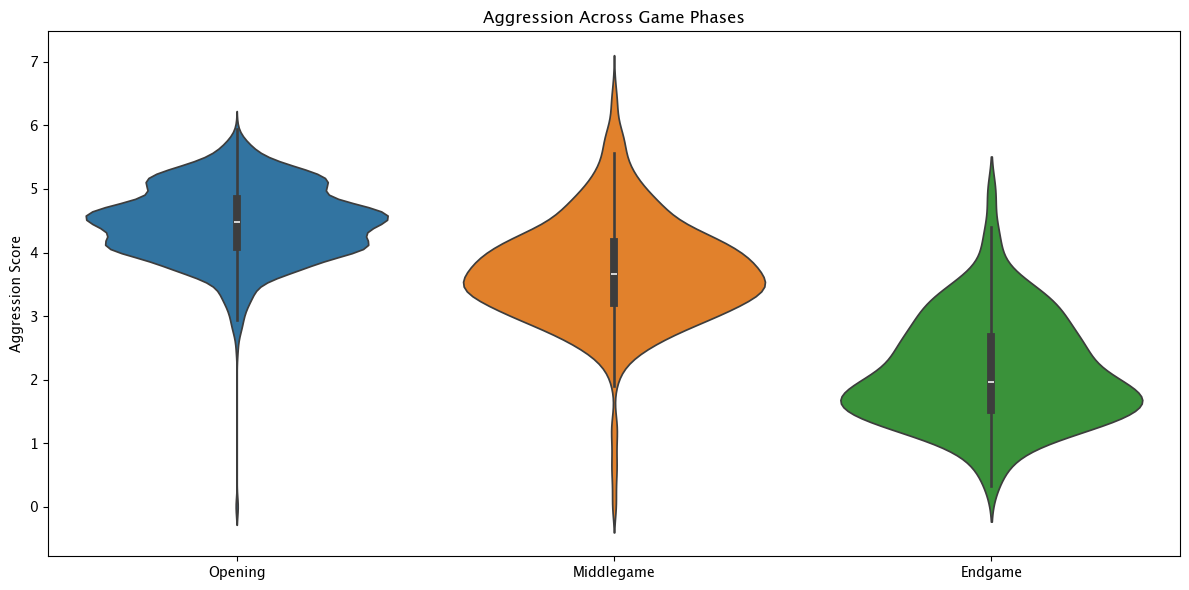

Opening: Mean Aggression = 4.46, Sample Size = 1191
Middlegame: Mean Aggression = 3.70, Sample Size = 1158
Endgame: Mean Aggression = 2.14, Sample Size = 225


In [58]:
import chess
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def calculate_center_control(board, square, is_white):
    center_squares = {chess.E4, chess.E5, chess.D4, chess.D5}
    control_score = 0
    if square in center_squares:
        control_score += 1.0
    elif chess.square_distance(square, chess.E4) <= 2:
        control_score += 0.5
    return control_score

def evaluate_pawn_structure(board, move_obj, is_white):
    pawn_score = 0
    to_square = move_obj.to_square
    piece = board.piece_at(to_square)
    
    if piece and piece.piece_type == chess.PAWN:
        # Passed pawns
        rank = chess.square_rank(to_square)
        if is_white and rank >= 4:
            pawn_score += (rank - 3) * 0.5
        elif not is_white and rank <= 3:
            pawn_score += (4 - rank) * 0.5
            
        # Pawn chains
        for offset in [-1, 1]:
            support_square = to_square + (8 if is_white else -8) + offset
            if 0 <= support_square < 64 and board.piece_at(support_square):
                if board.piece_at(support_square).piece_type == chess.PAWN:
                    pawn_score += 0.3
                    
    return pawn_score

def calculate_piece_coordination(board, move_obj, is_white):
    coord_score = 0
    to_square = move_obj.to_square
    
    # Check supporting pieces
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == is_white:
            if board.is_attacked_by(is_white, to_square):
                coord_score += 0.2
                
    # Battery formations
    piece = board.piece_at(to_square)
    if piece:
        piece_type = piece.piece_type
        for direction in [(1,0), (-1,0), (0,1), (0,-1), (1,1), (1,-1), (-1,1), (-1,-1)]:
            coord_score += check_battery(board, to_square, direction, is_white) * 0.3
                
    return coord_score

def check_battery(board, square, direction, is_white):
    dx, dy = direction
    x, y = chess.square_file(square), chess.square_rank(square)
    coord_score = 0
    
    while True:
        x, y = x + dx, y + dy
        if not (0 <= x <= 7 and 0 <= y <= 7):
            break
            
        new_square = chess.square(x, y)
        piece = board.piece_at(new_square)
        if piece:
            if piece.color == is_white and piece.piece_type in [chess.QUEEN, chess.ROOK, chess.BISHOP]:
                coord_score += 1
            break
            
    return coord_score

def evaluate_sacrifice(board, move_obj, is_white):
    sacrifice_score = 0
    to_square = move_obj.to_square
    piece = board.piece_at(to_square)
    
    if board.is_capture(move_obj):
        captured_piece = board.piece_at(move_obj.to_square)
        attacking_piece = board.piece_at(move_obj.from_square)
        
        if captured_piece and attacking_piece:
            piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
                          chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0}
            material_diff = piece_values[captured_piece.piece_type] - piece_values[attacking_piece.piece_type]
            
            if material_diff < 0:
                # Sacrifice detected
                sacrifice_score -= material_diff  # Convert negative diff to positive score
                
                # Bonus for sacrifices near enemy king
                enemy_king_square = board.king(not is_white)
                if enemy_king_square:
                    distance_to_king = chess.square_distance(to_square, enemy_king_square)
                    sacrifice_score *= (1 + (8 - distance_to_king) * 0.2)
                    
    return sacrifice_score

def calculate_development_score(board, move_obj, move_number, is_white):
    development_score = 0
    
    # Early game development
    if move_number < 10:
        piece = board.piece_at(move_obj.from_square)
        if piece and piece.piece_type in [chess.KNIGHT, chess.BISHOP]:
            development_score += 0.5
            
        # Castling
        if board.is_castling(move_obj):
            development_score += 1.5
            
    return development_score

def calculate_aggression_score(board, move, move_number, is_white):
    try:
        move_obj = board.parse_san(move)
        aggression_score = 0
        
        # Original metrics
        from_square = move_obj.from_square
        to_square = move_obj.to_square
        
        # Piece advancement
        from_rank = chess.square_rank(from_square)
        to_rank = chess.square_rank(to_square)
        advancement = (to_rank - from_rank) if is_white else (from_rank - to_rank)
        aggression_score += max(0, advancement * 0.5)
        
        # Make move to analyze resulting position
        board.push(move_obj)
        
        # Center control
        center_score = calculate_center_control(board, to_square, is_white)
        aggression_score += center_score
        
        # Pawn structure
        pawn_score = evaluate_pawn_structure(board, move_obj, is_white)
        aggression_score += pawn_score
        
        # Piece coordination
        coordination_score = calculate_piece_coordination(board, move_obj, is_white)
        aggression_score += coordination_score
        
        # Sacrifices
        sacrifice_score = evaluate_sacrifice(board, move_obj, is_white)
        aggression_score += sacrifice_score
        
        # Development
        development_score = calculate_development_score(board, move_obj, move_number, is_white)
        aggression_score += development_score
        
        # Check score
        if board.is_check():
            aggression_score += 2
        
        # King proximity
        enemy_king_square = board.king(not is_white)
        if enemy_king_square:
            distance = chess.square_distance(to_square, enemy_king_square)
            aggression_score += max(0, (8 - distance) * 0.2)
            
        board.pop()
        return aggression_score
        
    except (ValueError, AttributeError):
        return 0

def analyze_game_aggression(moves, is_white):
    board = chess.Board()
    total_aggression = 0
    move_count = 0
    
    for move_number, move in enumerate(moves, 1):
        if (move_number % 2 == 1) == is_white:
            aggression_score = calculate_aggression_score(board, move, move_number, is_white)
            total_aggression += aggression_score
            move_count += 1
            
        try:
            board.push_san(move)
        except ValueError:
            continue
            
    return total_aggression / max(move_count, 1)

aggression_data = {
    'white_won': [],
    'white_lost': [],
    'black_won': [],
    'black_lost': []
}

def analyze_games(filename, player_username):
    with open(filename, "r") as file:
        games = json.load(file)
        
    for game in games:
        if game.get('speed') != 'blitz':
            continue
            
        player_is_white = game['players']['white'].get('user', {}).get('name', '').lower() == player_username.lower()
        
        # Determine game outcome
        if game.get('status') not in ['mate', 'resign', 'timeout']:
            continue
            
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
                    
        # Calculate aggression
        moves = game['moves'].split()
        aggression = analyze_game_aggression(moves, player_is_white)
        
        # Store results
        if player_is_white:
            if player_won:
                aggression_data['white_won'].append(aggression)
            else:
                aggression_data['white_lost'].append(aggression)
        else:
            if player_won:
                aggression_data['black_won'].append(aggression)
            else:
                aggression_data['black_lost'].append(aggression)

with open("lichess_games.json", "r") as file:
    games = json.load(file)

player_username = "tazedurum07"  


def analyze_phase_aggression(games, player_username):
    phase_scores = {
        'Opening': [],
        'Middlegame': [],
        'Endgame': []
    }
    
    for game in games:
        if game.get('speed') != 'blitz':
            continue
            
        board = chess.Board()
        player_is_white = game['players']['white'].get('user', {}).get('name', '').lower() == player_username.lower()
        moves = game['moves'].split()
        
        phase_aggression = defaultdict(list)
        
        for move_number, move in enumerate(moves, 1):
            if (move_number % 2 == 1) == player_is_white:
                # Determine game phase
                if move_number <= 10:
                    phase = 'Opening'
                elif len(board.piece_map()) >= 10:
                    phase = 'Middlegame'
                else:
                    phase = 'Endgame'
                    
                aggression = calculate_aggression_score(board, move, move_number, player_is_white)
                phase_aggression[phase].append(aggression)
                
            try:
                board.push_san(move)
            except ValueError:
                continue
                
        # Calculate average aggression for each phase
        for phase in phase_aggression:
            if phase_aggression[phase]:
                phase_scores[phase].append(np.mean(phase_aggression[phase]))

    return phase_scores

# Calculate phase-wise aggression
phase_scores = analyze_phase_aggression(games, "tazedurum07")

# Create violin plots for each phase
plt.figure(figsize=(12, 6))
data = [phase_scores['Opening'], phase_scores['Middlegame'], phase_scores['Endgame']]
labels = ['Opening', 'Middlegame', 'Endgame']

sns.violinplot(data=data)
plt.xticks(range(len(labels)), labels)
plt.title("Aggression Across Game Phases")
plt.ylabel("Aggression Score")
plt.tight_layout()
plt.show()

for category, scores in phase_scores.items():
    mean = np.mean(scores)
    count = len(scores)
    print(f"{category}: Mean Aggression = {mean:.2f}, Sample Size = {count}")

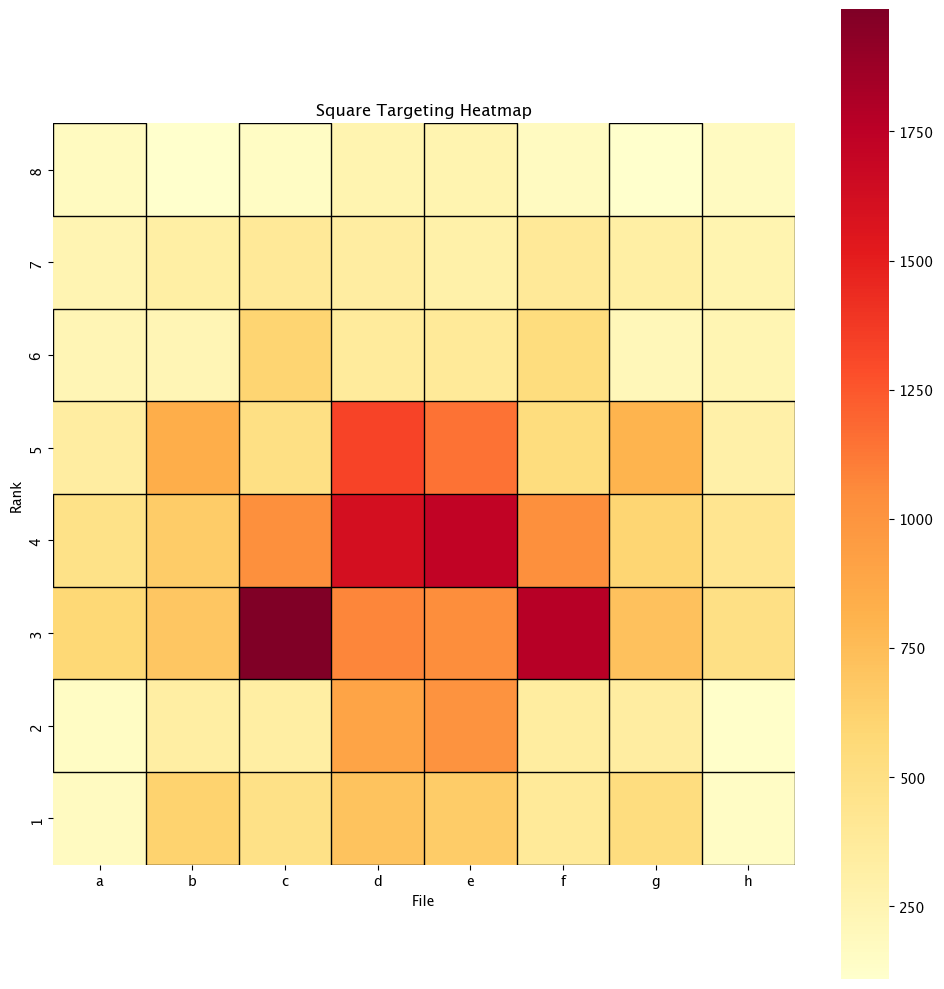

In [59]:
import chess
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def calculate_center_control(board, square, is_white):
    center_squares = {chess.E4, chess.E5, chess.D4, chess.D5}
    control_score = 0
    if square in center_squares:
        control_score += 1.0
    elif chess.square_distance(square, chess.E4) <= 2:
        control_score += 0.5
    return control_score

def evaluate_pawn_structure(board, move_obj, is_white):
    pawn_score = 0
    to_square = move_obj.to_square
    piece = board.piece_at(to_square)
    
    if piece and piece.piece_type == chess.PAWN:
        # Passed pawns
        rank = chess.square_rank(to_square)
        if is_white and rank >= 4:
            pawn_score += (rank - 3) * 0.5
        elif not is_white and rank <= 3:
            pawn_score += (4 - rank) * 0.5
            
        # Pawn chains
        for offset in [-1, 1]:
            support_square = to_square + (8 if is_white else -8) + offset
            if 0 <= support_square < 64 and board.piece_at(support_square):
                if board.piece_at(support_square).piece_type == chess.PAWN:
                    pawn_score += 0.3
                    
    return pawn_score

def calculate_piece_coordination(board, move_obj, is_white):
    coord_score = 0
    to_square = move_obj.to_square
    
    # Check supporting pieces
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == is_white:
            if board.is_attacked_by(is_white, to_square):
                coord_score += 0.2
                
    # Battery formations
    piece = board.piece_at(to_square)
    if piece:
        piece_type = piece.piece_type
        for direction in [(1,0), (-1,0), (0,1), (0,-1), (1,1), (1,-1), (-1,1), (-1,-1)]:
            coord_score += check_battery(board, to_square, direction, is_white) * 0.3
                
    return coord_score

def check_battery(board, square, direction, is_white):
    dx, dy = direction
    x, y = chess.square_file(square), chess.square_rank(square)
    coord_score = 0
    
    while True:
        x, y = x + dx, y + dy
        if not (0 <= x <= 7 and 0 <= y <= 7):
            break
            
        new_square = chess.square(x, y)
        piece = board.piece_at(new_square)
        if piece:
            if piece.color == is_white and piece.piece_type in [chess.QUEEN, chess.ROOK, chess.BISHOP]:
                coord_score += 1
            break
            
    return coord_score

def evaluate_sacrifice(board, move_obj, is_white):
    sacrifice_score = 0
    to_square = move_obj.to_square
    piece = board.piece_at(to_square)
    
    if board.is_capture(move_obj):
        captured_piece = board.piece_at(move_obj.to_square)
        attacking_piece = board.piece_at(move_obj.from_square)
        
        if captured_piece and attacking_piece:
            piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
                          chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0}
            material_diff = piece_values[captured_piece.piece_type] - piece_values[attacking_piece.piece_type]
            
            if material_diff < 0:
                # Sacrifice detected
                sacrifice_score -= material_diff  # Convert negative diff to positive score
                
                # Bonus for sacrifices near enemy king
                enemy_king_square = board.king(not is_white)
                if enemy_king_square:
                    distance_to_king = chess.square_distance(to_square, enemy_king_square)
                    sacrifice_score *= (1 + (8 - distance_to_king) * 0.2)
                    
    return sacrifice_score

def calculate_development_score(board, move_obj, move_number, is_white):
    development_score = 0
    
    # Early game development
    if move_number < 10:
        piece = board.piece_at(move_obj.from_square)
        if piece and piece.piece_type in [chess.KNIGHT, chess.BISHOP]:
            development_score += 0.5
            
        # Castling
        if board.is_castling(move_obj):
            development_score += 1.5
            
    return development_score

def calculate_aggression_score(board, move, move_number, is_white):
    try:
        move_obj = board.parse_san(move)
        aggression_score = 0
        
        # Original metrics
        from_square = move_obj.from_square
        to_square = move_obj.to_square
        
        # Piece advancement
        from_rank = chess.square_rank(from_square)
        to_rank = chess.square_rank(to_square)
        advancement = (to_rank - from_rank) if is_white else (from_rank - to_rank)
        aggression_score += max(0, advancement * 0.5)
        
        # Make move to analyze resulting position
        board.push(move_obj)
        
        # Center control
        center_score = calculate_center_control(board, to_square, is_white)
        aggression_score += center_score
        
        # Pawn structure
        pawn_score = evaluate_pawn_structure(board, move_obj, is_white)
        aggression_score += pawn_score
        
        # Piece coordination
        coordination_score = calculate_piece_coordination(board, move_obj, is_white)
        aggression_score += coordination_score
        
        # Sacrifices
        sacrifice_score = evaluate_sacrifice(board, move_obj, is_white)
        aggression_score += sacrifice_score
        
        # Development
        development_score = calculate_development_score(board, move_obj, move_number, is_white)
        aggression_score += development_score
        
        # Check score
        if board.is_check():
            aggression_score += 2
        
        # King proximity
        enemy_king_square = board.king(not is_white)
        if enemy_king_square:
            distance = chess.square_distance(to_square, enemy_king_square)
            aggression_score += max(0, (8 - distance) * 0.2)
            
        board.pop()
        return aggression_score
        
    except (ValueError, AttributeError):
        return 0

def analyze_game_aggression(moves, is_white):
    board = chess.Board()
    total_aggression = 0
    move_count = 0
    
    for move_number, move in enumerate(moves, 1):
        if (move_number % 2 == 1) == is_white:
            aggression_score = calculate_aggression_score(board, move, move_number, is_white)
            total_aggression += aggression_score
            move_count += 1
            
        try:
            board.push_san(move)
        except ValueError:
            continue
            
    return total_aggression / max(move_count, 1)

aggression_data = {
    'white_won': [],
    'white_lost': [],
    'black_won': [],
    'black_lost': []
}

def analyze_games(filename, player_username):
    with open(filename, "r") as file:
        games = json.load(file)
        
    for game in games:
        if game.get('speed') != 'blitz':
            continue
            
        player_is_white = game['players']['white'].get('user', {}).get('name', '').lower() == player_username.lower()
        
        # Determine game outcome
        if game.get('status') not in ['mate', 'resign', 'timeout']:
            continue
            
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
                    
        # Calculate aggression
        moves = game['moves'].split()
        aggression = analyze_game_aggression(moves, player_is_white)
        
        # Store results
        if player_is_white:
            if player_won:
                aggression_data['white_won'].append(aggression)
            else:
                aggression_data['white_lost'].append(aggression)
        else:
            if player_won:
                aggression_data['black_won'].append(aggression)
            else:
                aggression_data['black_lost'].append(aggression)

with open("lichess_games.json", "r") as file:
    games = json.load(file)

player_username = "tazedurum07"  

def create_square_frequency_map(games, player_username):
    square_frequencies = np.zeros((8, 8))
    
    for game in games:
        if game.get('speed') != 'blitz':
            continue
            
        board = chess.Board()
        player_is_white = game['players']['white'].get('user', {}).get('name', '').lower() == player_username.lower()
        moves = game['moves'].split()
        
        for move_number, move in enumerate(moves):
            if (move_number % 2 == 1) == player_is_white:
                try:
                    move_obj = board.parse_san(move)
                    to_square = move_obj.to_square
                    file = chess.square_file(to_square)
                    rank = chess.square_rank(to_square)
                    
                    # Normalize for black's perspective
                    if not player_is_white:
                        rank = 7 - rank
                        file = 7 - file
                        
                    square_frequencies[rank][file] += 1
                    
                except ValueError:
                    continue
                    
            try:
                board.push_san(move)
            except ValueError:
                continue
                
    return square_frequencies

# Create heatmap
square_frequencies = create_square_frequency_map(games, player_username)

# Create chessboard appearance
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(square_frequencies, cmap='YlOrRd', square=True, 
            xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
            yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])

# Add checkerboard pattern
for i in range(8):
    for j in range(8):
        if (i + j) % 2 == 0:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, 
                        edgecolor='black', linewidth=1))

plt.title("Square Targeting Heatmap")
plt.xlabel("File")
plt.ylabel("Rank")

plt.tight_layout()
plt.show()

/var/folders/g_/qxd37kgj1cb_c9yxwb54sjhw0000gn/T/ipykernel_96671/3099277876.py:291: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Loss', 'Draw', 'Win'])


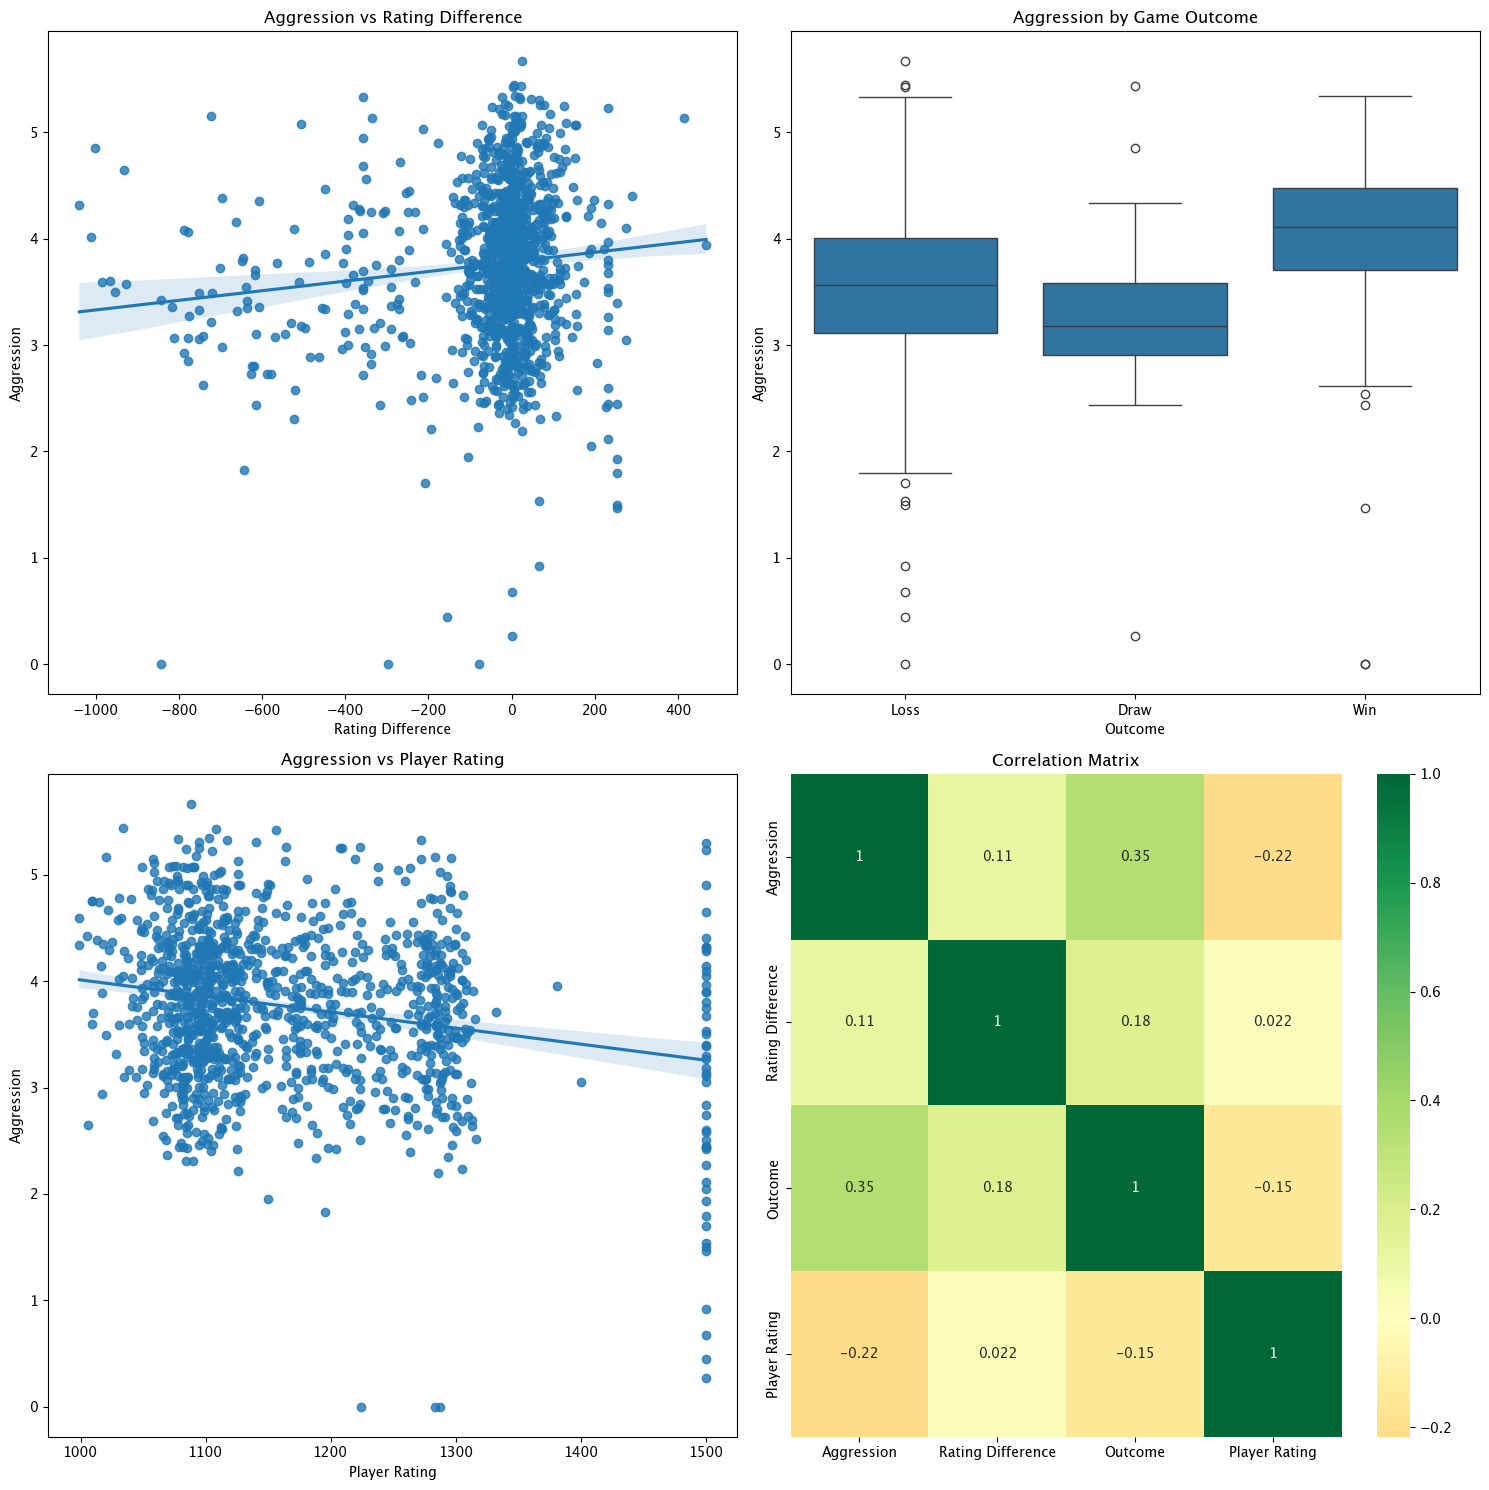


Correlation Statistics:
Aggression vs Rating Difference: 0.114
Aggression vs Outcome: 0.347
Aggression vs Player Rating: -0.218


In [60]:
import pandas as pd
import chess
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def calculate_center_control(board, square, is_white):
    center_squares = {chess.E4, chess.E5, chess.D4, chess.D5}
    control_score = 0
    if square in center_squares:
        control_score += 1.0
    elif chess.square_distance(square, chess.E4) <= 2:
        control_score += 0.5
    return control_score

def evaluate_pawn_structure(board, move_obj, is_white):
    pawn_score = 0
    to_square = move_obj.to_square
    piece = board.piece_at(to_square)
    
    if piece and piece.piece_type == chess.PAWN:
        # Passed pawns
        rank = chess.square_rank(to_square)
        if is_white and rank >= 4:
            pawn_score += (rank - 3) * 0.5
        elif not is_white and rank <= 3:
            pawn_score += (4 - rank) * 0.5
            
        # Pawn chains
        for offset in [-1, 1]:
            support_square = to_square + (8 if is_white else -8) + offset
            if 0 <= support_square < 64 and board.piece_at(support_square):
                if board.piece_at(support_square).piece_type == chess.PAWN:
                    pawn_score += 0.3
                    
    return pawn_score

def calculate_piece_coordination(board, move_obj, is_white):
    coord_score = 0
    to_square = move_obj.to_square
    
    # Check supporting pieces
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == is_white:
            if board.is_attacked_by(is_white, to_square):
                coord_score += 0.2
                
    # Battery formations
    piece = board.piece_at(to_square)
    if piece:
        piece_type = piece.piece_type
        for direction in [(1,0), (-1,0), (0,1), (0,-1), (1,1), (1,-1), (-1,1), (-1,-1)]:
            coord_score += check_battery(board, to_square, direction, is_white) * 0.3
                
    return coord_score

def check_battery(board, square, direction, is_white):
    dx, dy = direction
    x, y = chess.square_file(square), chess.square_rank(square)
    coord_score = 0
    
    while True:
        x, y = x + dx, y + dy
        if not (0 <= x <= 7 and 0 <= y <= 7):
            break
            
        new_square = chess.square(x, y)
        piece = board.piece_at(new_square)
        if piece:
            if piece.color == is_white and piece.piece_type in [chess.QUEEN, chess.ROOK, chess.BISHOP]:
                coord_score += 1
            break
            
    return coord_score

def evaluate_sacrifice(board, move_obj, is_white):
    sacrifice_score = 0
    to_square = move_obj.to_square
    piece = board.piece_at(to_square)
    
    if board.is_capture(move_obj):
        captured_piece = board.piece_at(move_obj.to_square)
        attacking_piece = board.piece_at(move_obj.from_square)
        
        if captured_piece and attacking_piece:
            piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
                          chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0}
            material_diff = piece_values[captured_piece.piece_type] - piece_values[attacking_piece.piece_type]
            
            if material_diff < 0:
                # Sacrifice detected
                sacrifice_score -= material_diff  # Convert negative diff to positive score
                
                # Bonus for sacrifices near enemy king
                enemy_king_square = board.king(not is_white)
                if enemy_king_square:
                    distance_to_king = chess.square_distance(to_square, enemy_king_square)
                    sacrifice_score *= (1 + (8 - distance_to_king) * 0.2)
                    
    return sacrifice_score

def calculate_development_score(board, move_obj, move_number, is_white):
    development_score = 0
    
    # Early game development
    if move_number < 10:
        piece = board.piece_at(move_obj.from_square)
        if piece and piece.piece_type in [chess.KNIGHT, chess.BISHOP]:
            development_score += 0.5
            
        # Castling
        if board.is_castling(move_obj):
            development_score += 1.5
            
    return development_score

def calculate_aggression_score(board, move, move_number, is_white):
    try:
        move_obj = board.parse_san(move)
        aggression_score = 0
        
        # Original metrics
        from_square = move_obj.from_square
        to_square = move_obj.to_square
        
        # Piece advancement
        from_rank = chess.square_rank(from_square)
        to_rank = chess.square_rank(to_square)
        advancement = (to_rank - from_rank) if is_white else (from_rank - to_rank)
        aggression_score += max(0, advancement * 0.5)
        
        # Make move to analyze resulting position
        board.push(move_obj)
        
        # Center control
        center_score = calculate_center_control(board, to_square, is_white)
        aggression_score += center_score
        
        # Pawn structure
        pawn_score = evaluate_pawn_structure(board, move_obj, is_white)
        aggression_score += pawn_score
        
        # Piece coordination
        coordination_score = calculate_piece_coordination(board, move_obj, is_white)
        aggression_score += coordination_score
        
        # Sacrifices
        sacrifice_score = evaluate_sacrifice(board, move_obj, is_white)
        aggression_score += sacrifice_score
        
        # Development
        development_score = calculate_development_score(board, move_obj, move_number, is_white)
        aggression_score += development_score
        
        # Check score
        if board.is_check():
            aggression_score += 2
        
        # King proximity
        enemy_king_square = board.king(not is_white)
        if enemy_king_square:
            distance = chess.square_distance(to_square, enemy_king_square)
            aggression_score += max(0, (8 - distance) * 0.2)
            
        board.pop()
        return aggression_score
        
    except (ValueError, AttributeError):
        return 0

def analyze_game_aggression(moves, is_white):
    board = chess.Board()
    total_aggression = 0
    move_count = 0
    
    for move_number, move in enumerate(moves, 1):
        if (move_number % 2 == 1) == is_white:
            aggression_score = calculate_aggression_score(board, move, move_number, is_white)
            total_aggression += aggression_score
            move_count += 1
            
        try:
            board.push_san(move)
        except ValueError:
            continue
            
    return total_aggression / max(move_count, 1)

aggression_data = {
    'white_won': [],
    'white_lost': [],
    'black_won': [],
    'black_lost': []
}

def analyze_games(filename, player_username):
    with open(filename, "r") as file:
        games = json.load(file)
        
    for game in games:
        if game.get('speed') != 'blitz':
            continue
            
        player_is_white = game['players']['white'].get('user', {}).get('name', '').lower() == player_username.lower()
        
        # Determine game outcome
        if game.get('status') not in ['mate', 'resign', 'timeout']:
            continue
            
        player_won = (player_is_white and game['winner'] == 'white') or \
                    (not player_is_white and game['winner'] == 'black')
                    
        # Calculate aggression
        moves = game['moves'].split()
        aggression = analyze_game_aggression(moves, player_is_white)
        
        # Store results
        if player_is_white:
            if player_won:
                aggression_data['white_won'].append(aggression)
            else:
                aggression_data['white_lost'].append(aggression)
        else:
            if player_won:
                aggression_data['black_won'].append(aggression)
            else:
                aggression_data['black_lost'].append(aggression)

with open("lichess_games.json", "r") as file:
    games = json.load(file)

player_username = "tazedurum07"  

def analyze_correlations(games, player_username):
    data = []
    
    for game in games:
        if game.get('speed') != 'blitz':
            continue
            
        player_is_white = game['players']['white'].get('user', {}).get('name', '').lower() == player_username.lower()
        
        # Get ratings
        if player_is_white:
            player_rating = game['players']['white'].get('rating', None)
            opponent_rating = game['players']['black'].get('rating', None)
        else:
            player_rating = game['players']['black'].get('rating', None)
            opponent_rating = game['players']['white'].get('rating', None)
            
        if not (player_rating and opponent_rating):
            continue
            
        # Calculate aggression
        moves = game['moves'].split()
        aggression = analyze_game_aggression(moves, player_is_white)
        
        # Determine outcome
        winner = game.get('winner', 'draw')
        if winner == 'draw':
            outcome = 0.5
        else:
            outcome = 1.0 if ((player_is_white and winner == 'white') or 
                            (not player_is_white and winner == 'black')) else 0.0
        
        data.append({
            'Aggression': aggression,
            'Rating Difference': player_rating - opponent_rating,
            'Outcome': outcome,
            'Player Rating': player_rating
        })
    
    return pd.DataFrame(data)

# Calculate correlations
df = analyze_correlations(games, "tazedurum07")

# Create scatter plots with regression lines
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Aggression vs Rating Difference
sns.regplot(data=df, x='Rating Difference', y='Aggression', ax=ax1)
ax1.set_title('Aggression vs Rating Difference')

# Aggression vs Outcome
sns.boxplot(data=df, x='Outcome', y='Aggression', ax=ax2)
ax2.set_title('Aggression by Game Outcome')
ax2.set_xticklabels(['Loss', 'Draw', 'Win'])

# Aggression vs Player Rating
sns.regplot(data=df, x='Player Rating', y='Aggression', ax=ax3)
ax3.set_title('Aggression vs Player Rating')

# Correlation matrix heatmap
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, ax=ax4)
ax4.set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Print correlation statistics
print("\nCorrelation Statistics:")
for col in df.columns:
    if col != 'Aggression':
        correlation = df['Aggression'].corr(df[col])
        print(f"Aggression vs {col}: {correlation:.3f}")

                timestamp  stress_level
0 2024-12-15 13:23:57.967           1.0
1 2024-12-14 22:32:04.609           1.0
2 2024-12-14 14:34:50.564           1.0
3 2024-12-14 08:41:57.528           1.0
4 2024-12-12 19:46:55.645           1.0


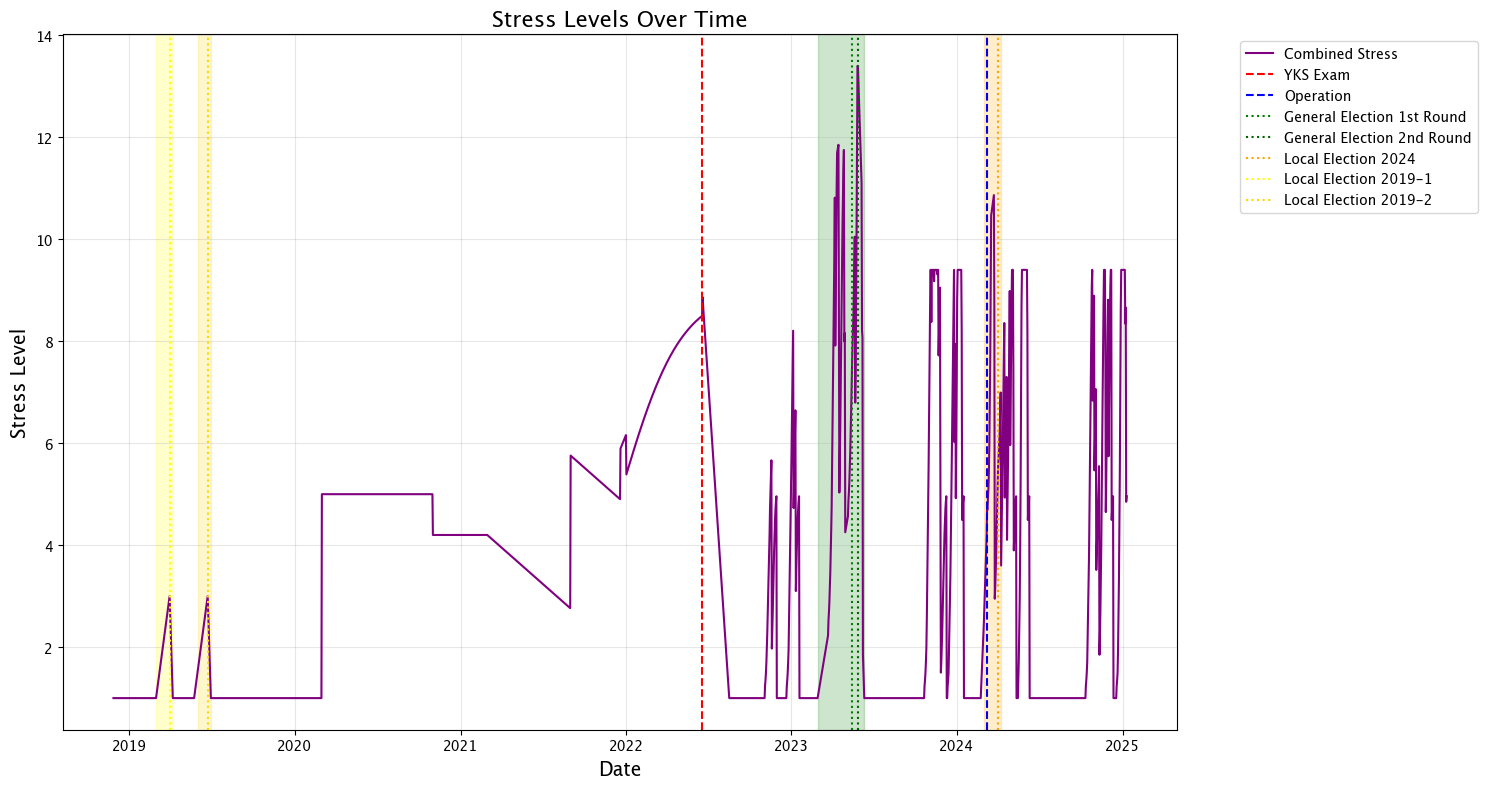

In [61]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define Stress Functions

def covid_stress(game_date):
    if datetime(2020, 3, 1) <= game_date <= datetime(2020, 10, 31):
        return 5  # High stress during peak
    elif datetime(2020, 11, 1) <= game_date <= datetime(2021, 2, 28):
        return 4  # Moderate stress
    elif datetime(2021, 3, 1) <= game_date <= datetime(2022, 1, 1):
        days_since_march_2021 = (game_date - datetime(2021, 3, 1)).days
        total_days = (datetime(2022, 1, 1) - datetime(2021, 3, 1)).days
        return max(1, 4 - (3 * (days_since_march_2021 / total_days)))  # Gradual decrease to baseline
    return 0

def yks_stress(game_date):
    yks_date = datetime(2022, 6, 18)
    
    # Before YKS
    if datetime(2021, 9, 1) <= game_date <= yks_date:
        days_to_yks = (yks_date - game_date).days
        if days_to_yks <= 180:  # Last 6 months intensifying
            return 8 / (1 + np.exp(-0.015 * (180 - days_to_yks)))  # Smoother logistic growth
        else:
            return 3  # Base YKS preparation stress
    
    # After YKS (2 months decay)
    elif yks_date < game_date <= yks_date + timedelta(days=60):
        days_after = (game_date - yks_date).days
        return max(0, 8 * (1 - days_after/60))  # Linear decrease
    
    return 0

def exam_stress(game_date, exam_dates, max_stress=6, alpha=0.4):
    total_stress = 0
    
    # Single exam dates
    for exam_date in exam_dates['single_exam_dates']:
        days_to_exam = (exam_date - game_date).days
        if 0 <= days_to_exam <= 14:  # 2 weeks before exam
            stress = max_stress / (1 + np.exp(-alpha * (7 - days_to_exam)))
            total_stress += stress
    
    # Double exam dates (1.5x stress)
    for exam_date in exam_dates['double_exam_dates']:
        days_to_exam = (exam_date - game_date).days
        if 0 <= days_to_exam <= 14:
            stress = (max_stress * 1.5) / (1 + np.exp(-alpha * (7 - days_to_exam)))
            total_stress += stress
    
    return min(total_stress, max_stress * 2)  # Cap maximum exam stress

def operation_stress(game_date):
    operation_date = datetime(2024, 3, 8)
    
    # 
    if operation_date - timedelta(days=14) <= game_date <= operation_date + timedelta(days=7):
        days_diff = abs((operation_date - game_date).days)
        if game_date <= operation_date:
            return min(3, 3 * (1 - days_diff/14))  # Build up
        else:
            return max(0, 3 * (1 - days_diff/7))   # Decay
    return 0

def election_stress(game_date):
    stress = 0
    
    # General Election 2023 (max stress = 4)
    general_election_date = datetime(2023, 5, 14)
    second_round_date = datetime(2023, 5, 28)
    
    if datetime(2023, 3, 1) <= game_date <= general_election_date:
        days_to_election = (general_election_date - game_date).days
        stress = max(stress, 4 * (1 - days_to_election/75))
    elif general_election_date < game_date <= second_round_date:
        stress = max(stress, 4)  # Peak stress between rounds
    elif second_round_date < game_date <= datetime(2023, 6, 11):
        days_after = (game_date - second_round_date).days
        stress = max(stress, 4 * (1 - days_after/14))
    
    # Local Elections (max stress = 2)
    local_dates = [
        datetime(2024, 3, 31),
        datetime(2019, 3, 31),
        datetime(2019, 6, 23)
    ]
    
    for election_date in local_dates:
        if election_date - timedelta(days=30) <= game_date <= election_date:
            days_to = (election_date - game_date).days
            local_stress = 2 * (1 - days_to/30)
            stress = max(stress, local_stress)
        elif election_date < game_date <= election_date + timedelta(days=7):
            days_after = (game_date - election_date).days
            local_stress = 2 * (1 - days_after/7)
            stress = max(stress, local_stress)
    
    return stress

def combined_stress(game_date, exam_dates, covid_weight=0.8, yks_weight=1.0, exam_weight=0.7):
    base_stress = 1  # Minimum stress level
    covid = covid_weight * covid_stress(game_date)
    yks = yks_weight * yks_stress(game_date)
    exams = exam_weight * exam_stress(game_date, exam_dates)
    operation = operation_stress(game_date)
    election = election_stress(game_date)
    
    total = base_stress + covid + yks + exams + operation + election
    return min(total, 25)  # Cap maximum total stress at 25

# Define Exam Dates
exam_dates = {
    "single_exam_dates": [
        datetime(2022, 11, 18), datetime(2022, 11, 29), datetime(2023, 1, 5), 
        datetime(2023, 1, 10), datetime(2023, 1, 18), datetime(2023, 4, 7),
        datetime(2023, 4, 16), datetime(2023, 4, 27), datetime(2023, 4, 29),
        datetime(2023, 5, 21), datetime(2023, 6, 2),  datetime(2023, 6, 3),
        datetime(2023, 6, 4), datetime(2023, 6, 5), datetime(2023, 11, 5),
        datetime(2023, 11, 10), datetime(2023, 11, 11), datetime(2023, 11, 18), 
        datetime(2023, 11, 21), datetime(2023, 11, 25), datetime(2023, 11, 26), 
        datetime(2023, 12, 9), datetime(2023, 12, 26), datetime(2023, 12, 29), 
        datetime(2024, 1, 6), datetime(2024, 1, 9), datetime(2024, 1, 11), 
        datetime(2024, 1, 12), datetime(2024, 1, 16), datetime(2024, 3, 22), 
        datetime(2024, 3, 23), datetime(2024, 4, 7), datetime(2024, 4, 15), 
        datetime(2024, 4, 20), datetime(2024, 4, 27), datetime(2024, 5, 4), 
        datetime(2024, 5, 5), datetime(2024, 5, 11), datetime(2024, 5, 31), 
        datetime(2024, 6, 1), datetime(2024, 6, 3), datetime(2024, 6, 4), 
        datetime(2024, 6, 5), datetime(2024, 6, 9), datetime(2024, 10, 26), 
        datetime(2024, 10, 30), datetime(2024, 11, 3), datetime(2024, 11, 10), 
        datetime(2024, 11, 23), datetime(2024, 11, 24), datetime(2024, 11, 30), 
        datetime(2024, 12, 11), datetime(2025, 1, 2), datetime(2025, 1, 5), 
        datetime(2025, 1, 8), datetime(2025, 1, 10)
    ],

    "double_exam_dates": [
        datetime(2023, 4, 15), datetime(2023, 6, 7), datetime(2023, 11, 18), 
        datetime(2024, 3, 24), datetime(2024, 5, 30), datetime(2024, 12, 7), 
        datetime(2025, 1, 6)
    ]
}

# Load Games from JSON
with open("lichess_games.json", "r") as file:
    games_data = json.load(file)

# Extract Game Timestamps
game_timestamps = [
    datetime.fromtimestamp(game["createdAt"] / 1000) for game in games_data if "createdAt" in game
]

# Create DataFrame
games = pd.DataFrame({"timestamp": game_timestamps})

# Assign Stress Levels
games["stress_level"] = games["timestamp"].apply(lambda x: combined_stress(x, exam_dates))

# Print Results
print(games.head())

# Create date range and calculate stress levels
date_range = pd.date_range(start="2018-11-27", end="2025-01-10", freq="D")
stress_levels = [combined_stress(date, exam_dates) for date in date_range]

# Plot Stress Levels
plt.figure(figsize=(15, 8))
plt.plot(date_range, stress_levels, label="Combined Stress", color="purple")

# Add vertical lines for key events
plt.axvline(datetime(2022, 6, 18), color="red", linestyle="--", label="YKS Exam")
plt.axvline(datetime(2024, 3, 8), color="blue", linestyle="--", label="Operation")

# Add election periods
election_dates = {
    "General Election 1st Round": datetime(2023, 5, 14),
    "General Election 2nd Round": datetime(2023, 5, 28),
    "Local Election 2024": datetime(2024, 3, 31),
    "Local Election 2019-1": datetime(2019, 3, 31),
    "Local Election 2019-2": datetime(2019, 6, 23)
}

colors = ['green', 'darkgreen', 'orange', 'yellow', 'gold']
for (name, date), color in zip(election_dates.items(), colors):
    plt.axvline(date, color=color, linestyle=':', label=name)

plt.title("Stress Levels Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Stress Level", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add shaded regions for election periods
plt.axvspan(datetime(2023, 3, 1), datetime(2023, 6, 11), 
            alpha=0.2, color='green', label='General Election Period')
plt.axvspan(datetime(2024, 3, 1), datetime(2024, 4, 7), 
            alpha=0.2, color='orange', label='Local Election 2024')
plt.axvspan(datetime(2019, 3, 1), datetime(2019, 4, 7), 
            alpha=0.2, color='yellow', label='Local Election 2019-1')
plt.axvspan(datetime(2019, 6, 1), datetime(2019, 6, 30), 
            alpha=0.2, color='gold', label='Local Election 2019-2')

plt.tight_layout()
plt.show()


/var/folders/g_/qxd37kgj1cb_c9yxwb54sjhw0000gn/T/ipykernel_96671/672383885.py:195: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_changes = df.groupby('stress_category')['rating_change'].mean().reset_index()
/var/folders/g_/qxd37kgj1cb_c9yxwb54sjhw0000gn/T/ipykernel_96671/672383885.py:201: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stress_win_rates = df.groupby('stress_category').apply(
/var/folders/g_/qxd37kgj1cb_c9yxwb54sjhw0000gn/T/ipykernel_96671/672383885.py:201: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of p

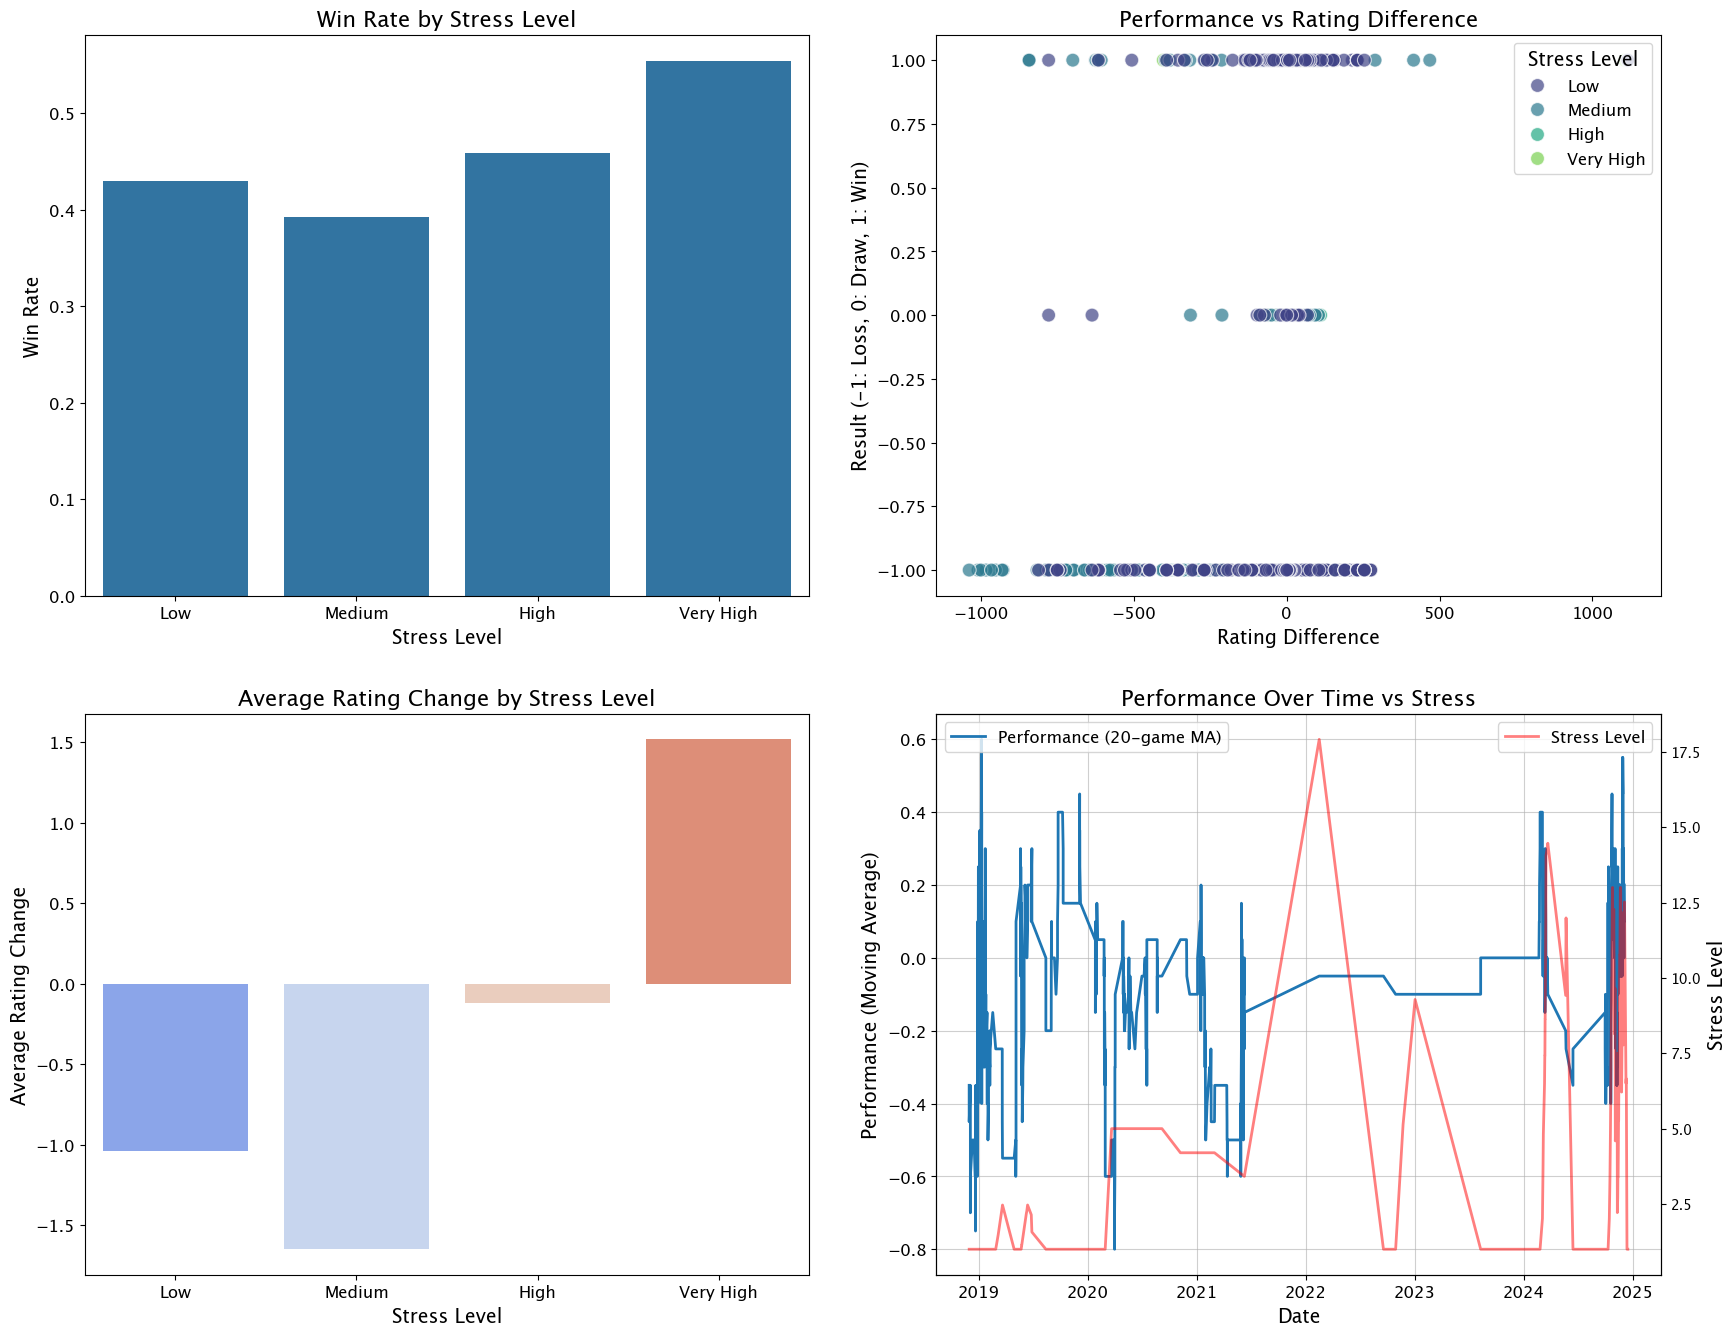


Performance Statistics by Stress Level:

Low Stress Level:
Total games: 615
Win rate: 42.9%
Draw rate: 3.7%
Loss rate: 53.3%
Average rating change: -1.0

High Stress Level:
Total games: 85
Win rate: 45.9%
Draw rate: 7.1%
Loss rate: 47.1%
Average rating change: -0.1

Very High Stress Level:
Total games: 112
Win rate: 55.4%
Draw rate: 4.5%
Loss rate: 40.2%
Average rating change: 1.5

Medium Stress Level:
Total games: 382
Win rate: 39.3%
Draw rate: 5.0%
Loss rate: 55.8%
Average rating change: -1.6

Correlation between stress and performance: 0.068


In [62]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

def covid_stress(game_date):
    if datetime(2020, 3, 1) <= game_date <= datetime(2020, 10, 31):
        return 5  # High stress during peak
    elif datetime(2020, 11, 1) <= game_date <= datetime(2021, 2, 28):
        return 4  # Moderate stress
    elif datetime(2021, 3, 1) <= game_date <= datetime(2022, 1, 1):
        days_since_march_2021 = (game_date - datetime(2021, 3, 1)).days
        total_days = (datetime(2022, 1, 1) - datetime(2021, 3, 1)).days
        return max(1, 4 - (3 * (days_since_march_2021 / total_days)))  # Gradual decrease to baseline
    return 0

def yks_stress(game_date):
    yks_date = datetime(2022, 6, 18)
    
    # Before YKS
    if datetime(2021, 9, 1) <= game_date <= yks_date:
        days_to_yks = (yks_date - game_date).days
        if days_to_yks <= 180:  # Last 6 months intensifying
            return 8 / (1 + np.exp(-0.015 * (180 - days_to_yks)))  # Smoother logistic growth
        else:
            return 3  # Base YKS preparation stress
    
    # After YKS (2 months decay)
    elif yks_date < game_date <= yks_date + timedelta(days=60):
        days_after = (game_date - yks_date).days
        return max(0, 8 * (1 - days_after/60))  # Linear decrease
    
    return 0

def exam_stress(game_date, exam_dates, max_stress=6, alpha=0.4):
    total_stress = 0
    
    # Single exam dates
    for exam_date in exam_dates['single_exam_dates']:
        days_to_exam = (exam_date - game_date).days
        if 0 <= days_to_exam <= 14:  # 2 weeks before exam
            stress = max_stress / (1 + np.exp(-alpha * (7 - days_to_exam)))
            total_stress += stress
    
    # Double exam dates (1.5x stress)
    for exam_date in exam_dates['double_exam_dates']:
        days_to_exam = (exam_date - game_date).days
        if 0 <= days_to_exam <= 14:
            stress = (max_stress * 1.5) / (1 + np.exp(-alpha * (7 - days_to_exam)))
            total_stress += stress
    
    return min(total_stress, max_stress * 2)  # Cap maximum exam stress

def operation_stress(game_date):
    operation_date = datetime(2024, 3, 8) # The date I took operation
    injury_date = datetime(2024, 3, 4)  # Date when my finger broke

    # Adjusted boundaries: stress starts building up from the injury date
    if injury_date <= game_date <= operation_date + timedelta(days=7):
        days_diff = abs((operation_date - game_date).days)
        if game_date <= operation_date:
            return min(3, 3 * (1 - days_diff / 4))  # Build up (4 days before)
        else:
            return max(0, 3 * (1 - days_diff / 7))   # Decay (7 days after)
    return 0


def election_stress(game_date):
    stress = 0
    
    # General Election 2023 (max stress = 4)
    general_election_date = datetime(2023, 5, 14)
    second_round_date = datetime(2023, 5, 28)
    
    if datetime(2023, 3, 1) <= game_date <= general_election_date:
        days_to_election = (general_election_date - game_date).days
        stress = max(stress, 4 * (1 - days_to_election/75))
    elif general_election_date < game_date <= second_round_date:
        stress = max(stress, 4)  # Peak stress between rounds
    elif second_round_date < game_date <= datetime(2023, 6, 11):
        days_after = (game_date - second_round_date).days
        stress = max(stress, 4 * (1 - days_after/14))
    
    # Local Elections (max stress = 2)
    local_dates = [
        datetime(2024, 3, 31),
        datetime(2019, 3, 31),
        datetime(2019, 6, 23)
    ]
    
    for election_date in local_dates:
        if election_date - timedelta(days=30) <= game_date <= election_date:
            days_to = (election_date - game_date).days
            local_stress = 2 * (1 - days_to/30)
            stress = max(stress, local_stress)
        elif election_date < game_date <= election_date + timedelta(days=7):
            days_after = (game_date - election_date).days
            local_stress = 2 * (1 - days_after/7)
            stress = max(stress, local_stress)
    
    return stress

def combined_stress(game_date, exam_dates, covid_weight=0.8, yks_weight=3.0, exam_weight=1.0):
    base_stress = 1  # Minimum stress level
    covid = covid_weight * covid_stress(game_date)
    yks = yks_weight * yks_stress(game_date)
    exams = exam_weight * exam_stress(game_date, exam_dates)
    operation = operation_stress(game_date)
    election = election_stress(game_date)
    
    total = base_stress + covid + yks + exams + operation + election
    return min(total, 25)  # Cap maximum total stress at 25

exam_dates = {
    "single_exam_dates": [
        datetime(2022, 11, 18), datetime(2022, 11, 29), datetime(2023, 1, 5), 
        datetime(2023, 1, 10), datetime(2023, 1, 18), datetime(2023, 4, 7),
        datetime(2023, 4, 16), datetime(2023, 4, 27), datetime(2023, 4, 29),
        datetime(2023, 5, 21), datetime(2023, 6, 2),  datetime(2023, 6, 3),
        datetime(2023, 6, 4), datetime(2023, 6, 5), datetime(2023, 11, 5),
        datetime(2023, 11, 10), datetime(2023, 11, 11), datetime(2023, 11, 18), 
        datetime(2023, 11, 21), datetime(2023, 11, 25), datetime(2023, 11, 26), 
        datetime(2023, 12, 9), datetime(2023, 12, 26), datetime(2023, 12, 29), 
        datetime(2024, 1, 6), datetime(2024, 1, 9), datetime(2024, 1, 11), 
        datetime(2024, 1, 12), datetime(2024, 1, 16), datetime(2024, 3, 22), 
        datetime(2024, 3, 23), datetime(2024, 4, 7), datetime(2024, 4, 15), 
        datetime(2024, 4, 20), datetime(2024, 4, 27), datetime(2024, 5, 4), 
        datetime(2024, 5, 5), datetime(2024, 5, 11), datetime(2024, 5, 31), 
        datetime(2024, 6, 1), datetime(2024, 6, 3), datetime(2024, 6, 4), 
        datetime(2024, 6, 5), datetime(2024, 6, 9), datetime(2024, 10, 26), 
        datetime(2024, 10, 30), datetime(2024, 11, 3), datetime(2024, 11, 10), 
        datetime(2024, 11, 23), datetime(2024, 11, 24), datetime(2024, 11, 30), 
        datetime(2024, 12, 11), datetime(2025, 1, 2), datetime(2025, 1, 5), 
        datetime(2025, 1, 8), datetime(2025, 1, 10)
    ],

    "double_exam_dates": [
        datetime(2023, 4, 15), datetime(2023, 6, 7), datetime(2023, 11, 18), 
        datetime(2024, 3, 24), datetime(2024, 5, 30), datetime(2024, 12, 7), 
        datetime(2025, 1, 6)
    ]
}

# Load games data
with open("lichess_games.json", 'r') as file:
    games = json.load(file)

# Process games data
game_data = []
for game in games:
    if game.get('speed') == 'blitz':  # Filter for blitz games
        timestamp = pd.to_datetime(game['createdAt'], unit='ms')
        white_player = game['players']['white']
        black_player = game['players']['black']
        
        # Determine if player was white and game outcome
        am_i_white = white_player.get('user', {}).get('name', '').lower() == "tazedurum07"
        winner = game.get('winner', 'draw')
        
        # Calculate result (-1 for loss, 0 for draw, 1 for win)
        if winner == 'draw':
            result = 0
        else:
            result = 1 if (am_i_white and winner == 'white') or (not am_i_white and winner == 'black') else -1
        
        # Calculate stress level for this date
        stress_level = combined_stress(timestamp, exam_dates)
        
        # Get ratings
        my_rating = white_player.get('rating', 0) if am_i_white else black_player.get('rating', 0)
        opp_rating = black_player.get('rating', 0) if am_i_white else white_player.get('rating', 0)
        
        game_data.append({
            'timestamp': timestamp,
            'stress_level': stress_level,
            'result': result,
            'rating_diff': my_rating - opp_rating,
            'my_rating': my_rating,
            'opponent_rating': opp_rating
        })

df = pd.DataFrame(game_data)

# Create stress level categories
df['stress_category'] = pd.cut(df['stress_level'], 
                             bins=[0, 3, 6, 9, float('inf')],
                             labels=['Low', 'Medium', 'High', 'Very High'])

# Calculate rating change for each game
df['rating_change'] = df['result'].apply(lambda x: 10 if x > 0 else (-10 if x < 0 else 0))

# Group by stress category to calculate the mean rating change
rating_changes = df.groupby('stress_category')['rating_change'].mean().reset_index()

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# 1. Win rate by stress level
stress_win_rates = df.groupby('stress_category').apply(
    lambda x: (x['result'] > 0).mean()).reset_index()
stress_win_rates.columns = ['Stress Level', 'Win Rate']

sns.barplot(data=stress_win_rates, x='Stress Level', y='Win Rate', ax=ax1)
ax1.set_title('Win Rate by Stress Level', fontsize=16)
ax1.set_ylabel('Win Rate', fontsize=14)
ax1.set_xlabel('Stress Level', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)

# 2. Performance by rating difference and stress
sns.scatterplot(data=df, x='rating_diff', y='result', 
                hue='stress_category', ax=ax2, palette='viridis', s=100, alpha=0.7)
ax2.set_title('Performance vs Rating Difference', fontsize=16)
ax2.set_xlabel('Rating Difference', fontsize=14)
ax2.set_ylabel('Result (-1: Loss, 0: Draw, 1: Win)', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(title='Stress Level', fontsize=12, title_fontsize=14, loc='upper right')

# 3. Average rating change by stress level
sns.barplot(data=rating_changes, x='stress_category', y='rating_change', ax=ax3, palette='coolwarm')
ax3.set_title('Average Rating Change by Stress Level', fontsize=16)
ax3.set_xlabel('Stress Level', fontsize=14)
ax3.set_ylabel('Average Rating Change', fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=12)

# 4. Performance over time with stress overlay
ax4.plot(df['timestamp'], df['result'].rolling(window=20).mean(), label='Performance (20-game MA)', linewidth=2)
ax4_twin = ax4.twinx()
ax4_twin.plot(df['timestamp'], df['stress_level'], 
              color='red', alpha=0.5, label='Stress Level', linewidth=2)
ax4.set_title('Performance Over Time vs Stress', fontsize=16)
ax4.set_xlabel('Date', fontsize=14)
ax4.set_ylabel('Performance (Moving Average)', fontsize=14)
ax4_twin.set_ylabel('Stress Level', fontsize=14)
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.legend(loc='upper left', fontsize=12)
ax4_twin.legend(loc='upper right', fontsize=12)
ax4.grid(True, alpha=0.6)

# Adjust layout to prevent overlap
plt.tight_layout(pad=3.0)
plt.show()

# Print statistical analysis
print("\nPerformance Statistics by Stress Level:")
for category in df['stress_category'].unique():
    category_games = df[df['stress_category'] == category]
    wins = (category_games['result'] > 0).sum()
    draws = (category_games['result'] == 0).sum()
    losses = (category_games['result'] < 0).sum()
    total = len(category_games)
    
    print(f"\n{category} Stress Level:")
    print(f"Total games: {total}")
    print(f"Win rate: {wins/total*100:.1f}%")
    print(f"Draw rate: {draws/total*100:.1f}%")
    print(f"Loss rate: {losses/total*100:.1f}%")
    print(f"Average rating change: {category_games['rating_change'].mean():.1f}")

# Calculate correlation
correlation = df['stress_level'].corr(df['result'])
print(f"\nCorrelation between stress and performance: {correlation:.3f}")

In [63]:
# Define a function to calculate the aggression score for a single game
def get_aggression_score(game, player_username):
    board = chess.Board()
    moves = game['moves'].split()
    player_is_white = game['players']['white'].get('user', {}).get('name', '').lower() == player_username.lower()
    
    total_aggression = 0
    move_count = 0
    
    for move_number, move in enumerate(moves, 1):
        if (move_number % 2 == 1) == player_is_white:
            aggression_score = calculate_aggression_score(board, move, move_number, player_is_white)
            total_aggression += aggression_score
            move_count += 1
            
        try:
            board.push_san(move)
        except ValueError:
            continue
            
    return total_aggression / max(move_count, 1)

# Add aggression scores to the DataFrame
player_username = "tazedurum07"  
aggression_scores = []

for index, row in df.iterrows():

    game_date = pd.to_datetime(row['timestamp'])
    # Locate the game in the JSON data
    # This assumes the games JSON is sorted similarly to your DataFrame.
    game_data = games[index]  # Ensure the index matches your game data structure

    # Calculate the aggression score
    aggression_score = get_aggression_score(game_data, player_username)
    aggression_scores.append(aggression_score)

# Add the aggression scores to the DataFrame as a new column
df['aggression_score'] = aggression_scores


In [64]:
from scipy.stats import ttest_ind

# Filter games into high stress and low/medium stress groups
high_stress_games = df[df['stress_category'] == 'High']
low_stress_games = df[df['stress_category'].isin(['Low', 'Medium'])]

# Filter only lost games for aggression analysis
high_stress_losses = high_stress_games[high_stress_games['result'] == -1]
low_stress_losses = low_stress_games[low_stress_games['result'] == -1]

# T-test for aggression score in lost games
t_stat_agg, p_value_agg = ttest_ind(
    high_stress_losses['aggression_score'],
    low_stress_losses['aggression_score'],
    equal_var=False  # Use Welch's t-test
)

print("Aggression Score T-Test:")
print(f"t-statistic: {t_stat_agg:.3f}, p-value: {p_value_agg:.3f}")

# Calculate loss rates
high_stress_loss_rate = len(high_stress_losses) / len(high_stress_games)
low_stress_loss_rate = len(low_stress_losses) / len(low_stress_games)

print("\nLoss Rate Comparison:")
print(f"High Stress Loss Rate: {high_stress_loss_rate:.2%}")
print(f"Low/Medium Stress Loss Rate: {low_stress_loss_rate:.2%}")

# T-test for loss rates
# Simulate loss rates as data points
high_stress_losses_binary = [1] * len(high_stress_losses) + [0] * (len(high_stress_games) - len(high_stress_losses))
low_stress_losses_binary = [1] * len(low_stress_losses) + [0] * (len(low_stress_games) - len(low_stress_losses))

t_stat_loss, p_value_loss = ttest_ind(
    high_stress_losses_binary,
    low_stress_losses_binary,
    equal_var=False
)

print("\nLoss Rate T-Test:")
print(f"t-statistic: {t_stat_loss:.3f}, p-value: {p_value_loss:.3f}")


Aggression Score T-Test:
t-statistic: -1.726, p-value: 0.091

Loss Rate Comparison:
High Stress Loss Rate: 47.06%
Low/Medium Stress Loss Rate: 54.26%

Loss Rate T-Test:
t-statistic: -1.271, p-value: 0.207
